# 1. Định nghĩa bài toán
---

- Lunar Lander là một bài toán học tăng cường, cụ thể là 1 bài toán Quyết định Markov (MDP) rời rạc.
$$M=\{S,A,P,R,\gamma\}$$
- Trong đó:
##### Không gian trạng thái ($S$)
- Theo định nghĩa từ Gymnasium, không gian trạng thái rời rạc $S \subset R^8$ 
- Mỗi trạng thái $s\in S$ là vector gồm 8 giá trị:
$$s=[x,y,v_{x},v_{y},\theta,\omega,c_{l},c_{r}]$$
- Với:
	- $x,y:$ toạ độ của con tàu theo trục $x,y$
	- $v_{x},v_{y}:$ vận tốc của con tàu theo các phương $x,y$
	- $\theta:$ góc quay của con tàu
	- $\omega:$ vận tốc quay của con tàu
	- $c_{l},c_{r}:$ biến nhị phân thể hiện sự tiếp đất của hai chân $left,right$
##### Không gian hành động ($A$)
- Theo định nghĩa từ Gymnasium, không gian hành động $A$ rời rạc gồm các hành động:
	- $a=0:$ không làm gì
	- $a=1:$ bật động cơ chính
	- $a=2:$ bật động cơ bên trái
	- $a=3:$ bật động cơ bên phải
##### Xác suất chuyển trạng thái ($P$)
##### Hàm phần thưởng ($R$)
- Theo định nghĩa từ Gymnasium, phần thưởng nhận được sau khi chuyển từ trạng thái $s$ sang $s'$ là: $$R(s,s')=\begin{cases}
+10p \text{ với mỗi chân tiếp xúc} \\
-0.03p \text{ với mỗi động cơ hai bên bật} \\
-0.3p \text{ với động cơ chính bật} \\
-100p \text{ với hạ cánh không thành công} \\
+100p \text{ với hạ cánh thành công} \\
\text{càng tăng/giảm khi tàu càng xa/gần mặt đất} \\
\text{càng tăng/giảm khi tốc độ tàu càng nhanh/chậm} \\
\text{càng giảm khi góc nghiêng tàu càng lớn}
\end{cases}$$
##### Hệ số chiết khấu (discount factor: $\gamma$)

#### 2. Trạng thái kết thúc
- Tàu hạ cánh thành công:
	- Cả 2 chân đều chạm đất: $c_{l}=c_{r}=1$
	- Vận tốc rơi nhỏ và góc nghiêng nhỏ
	- Tổng $\text{reward} \geq 200$
- Tàu rơi hoặc lật:
	- Chạm đất với vận tốc lớn hoặc góc nghiêng lớn
	- Rơi ra khỏi màn hinh
	- Tổng $\text{reward} \leq -100$
- Vượt quá số bước tối đa:
	- Mỗi episode có số step tối đa là 1000
	- Nếu không hạ cánh hay rơi trong khoảng số bước này, episode sẽ bị huỷ
#### 3. Mục tiêu bài toán
- Tìm chính sách tối ưu $\pi^*:S\to A$ sao cho kỳ vọng của tổng phần thưởng được tối đa
$$\pi^*=argmax_{\pi}E_{\pi}\left[ \sum_{t=0}^{\infty}\gamma^t.R(s_{t},a_{t},s_{t+1}) \right]$$

# 2. Cài đặt tổng quan
---

## 2.1. Thư viện, các hàm xử lí chung và môi trường LunarLander

#### a. Thư viện và cài đặt

In [92]:
# !pip install gymnasium
# !pip install swig
# !pip install gymnasium[box2d]
# !pip install torch
# !pip install numpy
# !pip install matplotlib

In [93]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from collections import deque
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
from IPython.display import Video
from tqdm import tqdm

#### b. Các hàm plot và đường MA

In [94]:
def plot_rewards(rewards, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(rewards, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Rewards', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(rewards)), moving_avg, label='Moving Average', color='red')
    plt.title('Rewards and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid()
    plt.show()

In [95]:
def plot_losses(losses, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(losses, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(losses, label='Losses', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(losses)), moving_avg, label='Moving Average', color='red')
    plt.title('Losses and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [96]:
def plot_fuel_usage(fuel_usage, moving_average_window=50):
    # Calculate moving average
    moving_avg = np.convolve(fuel_usage, np.ones(moving_average_window)/moving_average_window, mode='valid')
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(fuel_usage, label='Fuel Usage', alpha=0.5)
    plt.plot(np.arange(moving_average_window - 1, len(fuel_usage)), moving_avg, label='Moving Average', color='red')
    plt.title('Fuel Usage and Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Fuel Usage')
    plt.legend()
    plt.grid()
    plt.show()

#### c. Môi trường LunarLander

In [97]:
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [98]:
# Số chiều của không gian trạng thái và hành động
print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 8, Action Dimension: 4


In [99]:
# Nhiên liệu tiêu thụ cho mỗi hành động
FUEL_COST = {0: 0.0, 1: 0.3, 2: 0.03, 3: 0.03}

In [100]:
# Sử dụng GPU nếu có
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 2.2. Random action

Trước hết, ta sẽ khởi tạo một lớp có tên `RandomTrain` để kiểm tra các hàm xử lý chung và đảm bảo rằng các chức năng cơ bản của môi trường hoạt động đúng như mong đợi. Việc kiểm tra này giúp phát hiện sớm các lỗi tiềm ẩn trước khi áp dụng các thuật toán huấn luyện phức tạp hơn. Đồng thời, quá trình này cũng cho phép ghi lại và hiển thị một video mẫu minh họa cách tác nhân hoạt động khi hành động được chọn một cách ngẫu nhiên.

In [101]:
class RandomTrain:
    def __init__(self, env, episodes):
        self.env = env
        self.episodes = episodes
        self.rewards = []
        self.losses = []
        self.fuel_usage = []
        self.model = None

    def train(self):
        for episode in tqdm(range(self.episodes)):
            state, _ = self.env.reset()
            total_reward = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                total_reward += reward
                total_fuel += FUEL_COST[action]
                state = next_state
                done = terminated or truncated

            self.rewards.append(total_reward)
            self.fuel_usage.append(total_fuel)
            #print(f"Episode {episode + 1}/{self.episodes}, Reward: {total_reward}, Fuel Used: {total_fuel}")
            self.env.close()
        return self.rewards, self.losses, self.fuel_usage
    
    def plot_results(self):
        plot_rewards(self.rewards)
        plot_fuel_usage(self.fuel_usage)
        
    def get_action(self, state):
        return np.random.randint(0, action_dim-1)

    def display_sample_video(self, sample_episode=5):
        video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
        video_render = RecordVideo(video_render, "video-random", episode_trigger=lambda x: True)
        for _ in range(sample_episode):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = self.get_action(state)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("video-random/*.mp4")
        return Video(video_files[-1])
    
    def test_model(self, episodes=500):
        total_success = 0
        testing = gym.make("LunarLander-v3")
        
        for episode in tqdm(range(episodes)):
            state, _ = testing.reset()
            done = False
            total_reward = 0
            self.epsilon = 0
            
            while not done:
                action = self.get_action(state)
                state, reward, terminated, truncated, _ = testing.step(action)
                total_reward += reward
                done = terminated or truncated
            if total_reward >= 200:
                total_success += 1
        print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
        testing.close()

### Kết quả

In [102]:
# random_train = RandomTrain(env, episodes=500)
# rewards, losses, fuel_usage = random_train.train()
# random_train.plot_results()
# random_train.display_sample_video(sample_episode=1)

<video width="640" height="360" controls>
    <source src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAVuNtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAGwWWIhAAz//727L4FNhTIUJcRLMXaSnA+KqSAgHc02r/Du1VgBLaz2OWQiAGQWBIfmrsg8f1HnS7Dz7CWwHHO7zAzTaGcoYVrjMaqo3FyvBmuoVKLfblBFa3XO1LA9Wj43pAJARrppHa88aOORGy5SjPdoOmJ0VZA+UE8qF/Cj7yeDNHPbOIGWsE4lqWlRs5SMf+BJZTkZd9JeaPhcrO1Cp2pEf92NZPXwaMv3HgS2e/Z0xneCDV9nQ/ZGjfdYMQhYP7t4HtRY7fA43VuzOM6/N7Tf1MSG74tg6uVf15r2jAZnusBM4fDh5sbTlGxAAADAAADAIHus38uv2e4BP/H/UNLqfEC6GHmGtOlqmyZ663ASOAADTAAABJQLMFGQkAdwd4hwpxTSPkeLUbpdgQMMmsgpufFumw5uXRvTbwmGSojTUVIgLRmDXyPU03x2K2Hdpjf60BRYafOO3Gd88LboV9L8J/DYYsI5Vfh6e3QE5V6FszYjr1c41Mf8eyKn9LtKcB1S7K1T1tkcd2k7dKmtkcD1l1yz7w/lI5OG85LIaA5J0Tkw/YRawqz6YEiTKfQqNLoyC+Kt9cCs6TmDCKZLzhLN6xoZmxWvtpm/KVPDcUIVqvfhya5aY18KnJR3qxtPII1m34zOY/bJo2VPwnoBIkbL4lByyedAA1dIJIMD+wrriS0PzxN46dtgEOuRQZxNvSUXfAUVmfls6gEN/FLcWdLiEkz1bjoSjhBhi80+kkNxxXsMoX8TCEDvw/DQ3j9YvcBxlGZrrn2utn3vG34SmuwEOPx49zBgPGqKKNG0r9qoKZ/FXP3xmCIuq+D0z5OmouwZbU+p+Xk2RHTsHkF2zjwLMGNJBZkolzpRL1zX7LBZVYlmLzzBIQUsQBH/4KwXgMEWAAg0GlU1rDQ9tdkkKvsktLXteA5LJy2lTK+zbBpkQ2aCUHaywKY6NEJWRQ+tiVw3lDID1xYWND61vxCsDPzkRngfAqOkj1t8yPM2RDxTR+fpTdoO9K7jXmKfupHE/udrtboHVkePHwXbYweSUsrMvhBZSRPzfltyDJwrrCPwkILBBvd48Aa1iNmiLnBI3/pw4OHBF1qePPN/QnKIGJUfkBrTaTRlJGWSaqbp7qR5xPbhTpo1jTOoI0m6Vx53Lcsy9yt5qSVjdtj0yDmB/9HBhY0qfQu+uy3skQJHWM9S5P209KhtKnAaG+L48ADh0piXra696EHwdz/CeebN0EKy1EcoiCwhTi9c0PCwHReHVqPxmy0hIaD7hj2hfE8Sjhnx45tqWqbVLH7N5Ve39qIY0rJkS09a5s4ufAAMxN32qCZKsJd8g1W+gL9XqBacUHWZoruYSl5JHbvZD4K33AOC63SVk1O0z7w6v/c01zc3U0g0MS4fEB7Mf+LsodjOm/psurvu0dmEP+235dM/ufr8wmBMKDFDSo9F2lyWqc/xK7c09GQczt8OUtOaAcFgpHXa996Nb53kdzmQaXVtFtCs8Ssq0qqa2O6YLZeUdkdi0CFBEfkaxEOncrdHuBlDYMvDEG8z8UODQQ76SB8MX7uLavJyC9aeWO519PVYuOFeCIq8Dvw3eVLX9xnm1GxYlOL21Yw1lOx61ULghyJ2hZqWE0q2orHJi4ptHfO4m15WD9ngJ7+vj8Fo705x8ARqcy+of7/1DThYHZtKwJUYRxcETOc1dC283PLVLcvnuaLmMnDOVdvvRwxz48Yy/eoilJc7IKGugAg95Nla/OIPLIKVVfSLvlxTARGwtx7zp8Ys/QnwaVhqoHdWNKk3ixItNprq/MNTliBOpSbcyOYx7m8ZwhK/2CuuDUgkQhFliZSPSRPOq+QPCsUVeqjIfqL6xvvBcsW7JNnXlvibRdHZm9ztfvzvICmkwLa67pjUA2C/R9NDvJAi5cbS4ikpVtweWo/lApp+QZ7NnxyJoVnq3+CJn4/wm3ivLVLKsHQYq7Z7q09rRQeoahE5Cl3u4g7qyHzf18IwhYZHnlhUCIZP3Dw4KDLX+mS160Nd4lNCrXsOq2gFOkVEqRcCgAVr2E+B7+qUICEBJksNfOLXidEWyEeOfrVLtpF1rx/psCkG7vUfOGaWCkWryqLersEPiD1M51gZ6y1NPyzz2+A2iU0ZSoUxQ4JBLwSosww+gn2u8XTKjWIIGW34YSmDDik3b2Pj7yBVo+HD00bmANCV1K/xhapkiO3CCsCPK3vAMUi7PwYABS3wjS4cfiHCAJQPsx1JUXEGRV08JqcOFlfJmcbDjM1KirwagvmtvPcjClG4NDCz7FSIh82R+8AAAMAAAMAGbEAAAGjQZokbEL//ozPL08FZAAcllzb1blM7ma3VCiTlCLWa2xc/eMuEfdZ/HTQk7jUXR9p3VIc627X5LPLbTolpbOXywOQ5G8PNft2urrQ+JWzDJzaWIxWOPuxTnIudiBdxHxMfw8w2HOHKJuYAAADACw5yjJW7tjr7i6IatYvUyx/1Dcd+AkQsKKbUGoy76X0eR+oZyifxdlF1jVQ+BJW59vu2qZo6X7zJ4ON4UEYc+TcpKskSk8ulW0KPj8H+tT7CXbw68ZVFiD+XESVXJ86EjIX2qcrk1TV39kd2gQB+Vj7HQIm0Rao9VIuO7JPmWgnq5IvXjQrbqSAxe+SVTP0I/kMpBHWSq2qKBkpppOGvQxR1qtsxenzdI73LAtvU34GiFkIo9+Higwz/vl1jaVb++q7b65FBumEoF/V4LS5xG/vNQAN/LmtlNMH+S8/OxFyM5n3n0kJcjJ4tG9LMrQr/Qrbhg6wpKR513oO+vTC06FqYGIx+6beKzfWh3NxMnyApOQlgPfJ37V32WRdF3W6YBGEfB3G0d/o1U60GZs7O6NUewauwOAAAACDQZ5CeIR/D11wg2cgDlaESAZ7FSB0u4/etVHM5pEBoYDXa/8o1UUEYKxagOghlNtCRO17sx74+UCEgx7s8YHU6RvMjoqrPEb/oC1qBSYdVFklR3JyjuTBHqIy+2nGK3yOSutDyzDHf7AfAXzxXuO8v41ubt5Tqo0m5MInytJ4ep9AC2kAAAB0AZ5hdEf/FMOi03x5VciQf4/QAJK/rJsPkJEU+T1DhpYQfpvJaY3t2dOcr5t8iiDlffkF+sPNhD4i3WDJUoXLS9RrnjzVet9bIFHhI7ukAFGC+rZYTIpYe2hUngqtMp67giUjJA9+F96I+pIFanmjFAQAm4AAAABoAZ5jakf/FOpp0ZEQc/YACcXxn5i2n5EjobFw//b6MJRdRQWmbIXqlF4WuT8bFrE0tfBVScmRvS7TLRiIWvtJU5Vm5Sv0ANdJMBb2P8lmp8pavxe22BvSPDL/GuU3RfuXfrPje+gcBH0AAAFgQZpoSahBaJlMCF///ozTM3+jYjxqn4UYNACy6Jx85dQrCywUYSAKKRgGFozXVcs2LSxgGB0/QeyvkB/8mXuGLbEnFQbjBsr5qXS0CeBuzX4RlJrXFab7OLQsZ+lhAAAPs8J9KpZOVI4b7V8njnFrUOaCJq6dfrD/9alA/sorRzKW3T7pVqfuKXgDffD2+8kPFqSHR4mnbg273u2qZvlvEe0upPNvOESAP/q5C0q/n6ryO6R2ITLOyigCxDWSIw81/Jj03+iCmRWAmpTj4VReG38V3hsjEY7BMsWcL+MQR71V05D0StUqAO+K2NcRubFwr1GASYRH5NA4GLLk4YUW7JQP5pDuzuRtWiWNqlAvp4lwV6m51aTMwmfkO+YEZvtjcruRShyRFLrNxMszP3jzxEduPIjcGorSt2qAqt/dMY/DofuFwoqWyVEP8YBH6j2q7CFrSU91oes1/DJtMmwCHwAAAIdBnoZFESwj/w9oipGTk6ceY+tsLDtC6mwFk9QOLAAlqWoYNktk9Hp8Y1EmFs1aLOktHFySRqEVzc20t/Q2u9iPCTrSVGfXCTgIlNfsPA4uHK/ZIAaOy5LERDhDV+wgJmgMyjIeKBeyyhM0gD3b1LDx+A9/gAg2iIJgSNqhMV112SYXKk/UCpkAAACNAZ6ldEf/FOs1vVHiugAHwCFPEhTpneSzXQGn9hsG/XZFP1asWhdFmQehD1lCv4D7BdBpSF1IkR6Mb2WScCt8l/DLiP6ITjN1N90BD5IEjCY7e9Y4iAZEuTb+qqJ9zgxN80MFzKZAXA7PMqlvQA9isX8Mb/JXarAyq+uLnq1R1a7f+y7zmsCVBZWZIAc1AAAAuQGep2pH/xLIguua2P4AB82M+MV3y5BL5lFfjIKC0ynkSMGaXqvNGaLtTtKxq0UBJbwTUqy2Qos4Uaf68V7Q0sz6V7CE1dfFp++txNjYSaXaBl8zPigteBkpkpZtVYTSVqRx4WM9eRiGb6k4BdG1mmtcgw3BP+G7pmmVlEPTSN5g7sQyuMP2M9qo0uAwUgerVZ0nyKjs28EbdMxFrw4142bJ/D1kZBIDCjv4PybG/2YynPeO1BwTzkvAAAAA00GarEmoQWyZTAhf//6Mw/dLU9pomhxxQ6AAAIpp8ZIUuxhbbJrYKFHg2X0VgryKZLFfnN1hsrRXCg6RjD8qX2WE5leSPiV4iUPmHl8SxDAAAAZXYd6Kaw5fbPE4Dk10U0F7rrucwRwGLTkX9lUEd921TTev+UWUuu8GE+W0uheRjWgx4qSAyyHCJA4TK5pBX0+/PUR5kw56oWbbFUNj6f6wVrSQubc9krVV12OvblUQgdUTDF/NRLD4cnQGWyFPh9QibbhaSbAUxlIg7TpgUAaDgxYAAACPQZ7KRRUsI/8N5XKB0sOuRAOeq9NIIm/YJaubc88dqtPc8ALWff8s2Vc0kzLWqLh8sgvPvrlqej77jL9GD/TXcNgkAKFWCaFsJjFFHoN2rdfo/jHHaI7fko7CqpqEAQDCC/OyniU+zVa4JJjlK+BiOIQitO6MYPO9D1vBsRnJ02X9eJz14Ombn8s75e5GgekAAACoAZ7pdEf/EsTGy8rAC23vNNPKIz58l71iyi8e5Sq1ezExpj2H2LP8mCkIQHrh+0Cmg82gKUEfKEsDXuhIPjanLiI8NPUJbdjQ1Cw+xvMNsHXpletb7qF7tHNwgi/BCpy08Mgo+P9v8RJCw9TBHX8CgIDmQD3i7HDgiuUuEfqoWktClGKiKmZ7BZQQaaaqeCVAcbWVEVgdSoBgyGQvzSD9T5lFNAw1LAGBAAAAgwGe62pH/xLbj83lY/nRPUgAa7xtPnP5Wx6P1ix4jpQXjDSHtno4O7dwchf16nnXJwK5ojayakGSV7a4spYpsF1b3YMko9bl0HzvROdB66ezseAqoGgQcnvxLgBusfH9YIRJDOJ2OqAXw2mxRl9eYHNi6v7LgtJjbMWAom/STXdswhEvAAAA/0Ga7UmoQWyZTAhn//6eIryebhEANL1QjG91otNQw8O2Dp57e52BtDPbon/Splcm4CUzpHSpBuEOAPJWM7fkH554/ZhAAAAeZmn/9UlVXCZ94EYxsJWrbh+gzKq0S2bjwIeacIl6FLOTtVf0jT/4fMkvZl1+w6fo8T+3dJUPnIqBMKJTIZTS6m13MxuC6i50sT6oV77tqmfy9eUVfXd8tUVDb5quI3HNZY1VUvvys0WDxCcdu8MALVcgGHMAzaE7dGPRvxqFqRazr50nqRSBT8KA2eRa89CXOlk0xAEtD/JNEksgAigQDsAW14KwkpF5266DrqoHy22e02ZgOADagQAAAR5BmxFJ4QpSZTAhf/6MxCV460HjgzBpDTACJFTpMLPkLn/3qVVVnypHj102aL5e/nZgWZc7tnNPIOwDXr5mQunos44x1ylvSfAAAAMAEfdhhnXdaLqaO+gYaFYRuQC7LeeaiblnkJCy2I2xpWmpu6qvtRrObwAm992tSv99Y8HAg5lKXJf57yqMqWsYuXNTc+o1ZPqH0Yn3S73EFW9hBVULv8tAcVM1MDQycwfGmrtf3p+15SHyVitkkSQM1jRAP6eyVqsUYPLjH3deHYtYg2aK0zkgmJLr+OeHIHzhhm6VLUSEEr390KA50JZrGaTq1P9CZ0OGdP2eIHbP/kn11arshoSFq3vjmL9p8PgDXPVgOQP0X7YqAQ9zraVwAFtBAAAArUGfL0U0TCP/DRFgUtfux9vHqwBlsG78AUxk79JEiVXWpqwCqA2OP1Pf7WxzN+8e6W2yBtKM6ez+Gzokm5SdgtllvgwnECOC2mbaniZGll0xDXZM0QuYW6eKDcxFJjEViP6h7HGt7BV5itPKQvasoku70oJp2+hFw45iMbf1ryiW96T8XLKeFAEYbvesIL9Ngfatto4L2QEqImBuPlrB7mdTQrb+qAHScI59QFTBAAAAiwGfTnRH/xLu/uXyeAA3o7NjFoQ9/FyXQBI04vLmSQg+aCQE3RZuvV3ZMqGx8pXApmY7D9Bq0pQGvx1rNWo36asOciAQvOLtkXGl8uTpbsoR0HZo7vi/mQ42kcEUPMY9Qa6uhWZbLgNaKJzy8+oMDBmywEE1dcnJv8iN17IQWpCeg6xhFFrMgY4gBgQAAACYAZ9Qakf/Eyu+weTKIzVGuFU1UGAELwfm6r5KM4NjkM/ozaZ5CLGc3fskuUPUBdEcX5H016iU1rYczI9oScUDYiECV21HK2LqKaQLsfVQb0FWQ/So9y8kOjtun9gpAXhVHSYXG86luowICKCJ47uQI+87t7gGH+d3aQ0uy45UbCZGBBsbc2dcBDzMbuh+lfmn9PJv8GTziPgAAAFEQZtUSahBaJlMCGf//p4jTT/S7+upFrIAH4u4Wfu2ou7+VDZUUbzqxom/Yz19SOnE36KXz7MbRFyzuB4i2o7g8hF5nQCJgWddT5AULtGz9+AW5ytXs/qpvlTQPTpN6k6VrdT0JqsdnOdNExcTbp8ZAKlkwbHVf6kADMHMnVefm96BlwbnbZKYEVpZoQasO5/tBF4T0lJD/nW54hKlwQiY4GiSLVuP39IgARqfLEpcz2xPIUZh9TtenxYIasgO68v7Bp70wr9cWvYyuLFKOREssEm3+O1MkIdTMi8FQI4vFrhY0njzVeAa61WaOevb9bLLID9QJvVNWDLP7NHUEq9/KVTfXHb0TW+5d4qX0Fi3AzW6ZCGdiaA8GJsY4p1NHDY7fEs+fe9yCQA/Xgjudo9BCfVNqNeCC06u9wTQh98Hk1gbYFlBAAAAlkGfckURLCP/Df29jrvLA898u8QoAIbNLIAHENHWMEPOtrYVY5z9zxkMnduPTAM1fb3p/t3cWDdTNl5hYP0bCfFQVUe5jadzhRQOMiV96RVGKuaqCu2XW7XX+EpADRDca9BecTlptlvhXLoHkVrxRRPX1kqQkQeLo7/4ZEQcwmxx2VF8NvaRyWly0y7MOWzMbW4SpnDBSQAAAHIBn5NqR/8TE75qRFM76DHdDzgIjygAFQd5Pls19bRcrL/NYys1V3cwfCyRF54/Ge/9Du9sv0ROw/ZWope3/dLcGa05zXndgx0J/r3AtnmWIrPj0oczqYqbzCY87hyYjcv4OPm+t3RyqxgsfCJMTOiIiYAAAAE5QZuYSahBbJlMCGf//p4b5wIYerOnpyclJwATrRdyQvD9GW90tjDdiSLKXIp6YWh7Atk0acvm+LsD/bQ45t6V0ST7qT6svOy6ZUq/kF+J7CtDuuJY04YjJrq/NL02bx7Z/y1DicXerQMyiJAFN7qVxcrTTclIlZOPqAAAAwAOU7xLu2PNQErhqhhzPDjac2YF+gOKrOzmTbeJfpMNlDjIvOCQQHOyPbalNwDvjH1WulDb72JO3ovLdaV8GKCRIS50dwvfPH9CprlszoDmOEeiERncdgumIyFzrxEm7eo/zb309kwPmPzAB/SLf5VsF40cR5IoviJLqhNWBGmBssJBbU4bN227o70iOP1kDyoyEmE3R1Yo7vuxVzN6BOfz+iFI2DHl14qUBXri7PJg/ar09VuB6jBOX4BbQQAAAH5Bn7ZFFSwj/wxvQ7aWxaLXOV+QwALqvd/8oyqgqjOmVLXhQiSvYZOBGaIkJk2Ye3CF+Nznitlc38UVOF+Wd65pD14yhoukPGgPRK+gvkoz50riX4MABlff+gBzdp2Cm0A28NPVFiFSeNAMwowujX9LcEBU791+hBDDOJHQFBAAAACTAZ/VdEf/EU/MePaNDpbIYAA/lHddsMzfYMe/F1IeMpWp12Mo7iNOywWtkDFpW3IS/+8cp3zOX4wCqDMcCxOP+H1mS046Z05AIZvjAggag8BIpmIMkBr0LePYLKmQMAps+Ve01ARMo6ObhQLSxVwQnRPxK5mUOI6ZPGr8RKx8IIA5CLm0YKvE/8m633O/UD/FgBWxAAAAqwGf12pH/xFF8DHTPLwwIcIRPwBEbQ/QJ4UJSuStPY/cG7w97Y2jrbFyMcIuT7jgMCjONF51KCCt+iqxls2r1Llo8wmlMmZ4jWLLPWeGhIYR3yEuYJk5AEwoA6PJfrEwsbvyAZGgwvPfDKm7aFuE31MreGAyryx1ZIjpc2eDQS8zBpO4bytRBLIhTwMPV2jXJCGAiPcwQCf9qC05E4UIKZNs1lJ77mqywEyLiQAAAQ1Bm9xJqEFsmUwIZ//+nhwpNxMBCa6lguurWgM8tOsgAc4fIkHONIg197Tli/PXbLUS0STA4cTxK20PiXeq5/yXmVFhY7OtHZuKfHrjQWH9okfTs/yp/P4CBsvU0poTSLHSc2Ufe2K+gqUljGOCfscj9AQEpz9wY8h+zj96Z6ROxbTPaUuuH+AcG9bDhNsa770dq+43V+sz87XzSMXlDYAPtzYKC5SoNco5rH2T8Ke6HhAXwdbUhXLUOS/P6JiUEIKG6jL4OY3ZweGYyMd/bezixcA72PmKhf0iUxYq3DZC2IR10x2saLuv+YBooSVFUkqb3JM/R9wlX2B8yBInlsSf53v2nDzvFvddBvkUMAAAALhBn/pFFSwj/wxxzv9VEQpIIMf+gESjX+fBS9oH/GUAJbmwuszBZgVXcrj1xS3YGXbYxVGaSHH+xQirF2lo9/BEntZw7rcb2iHsctzV4p2KNMIuor+vtCrMnFQMXLfJTA1TgnJ5hW7HHmiVmXb/rLWWGELgJaM1E28Jbc+iAPMVMM63HyKtHCa9W8KynmWRKjRsSWKLNCynSIskd21811TCiQAdY0hTghGW19xrDM49dnLCo6NZYN6BAAAAsAGeGXRH/xFfJHOmJoDowRQhi+OgA2ybpLze4CjSO4RDWo2fGqgJiOa9wXKIvv2XRYSRAt4jhpUJ3Hqo+3LFIdg69LPrfOO95b3BwRg1swQK3sHM/9XYeUmVaJ1WKPjm7kXbMOfi9uux6sMv7+DQlnNBXB1+UUSpBLev9AyK3lfsWKL/3TgJs47TVjQF970nQaGvdZNtC8Ds3tMrrAa3kxwLH/hVw47Dycbl00EWbD5gAAAAmgGeG2pH/xGOykxuMGHgBNXYqT42JC8/sl9JQXU7rPTmfvTLNyx4MTb3WP8FFY0BdZr9Q/DTXMOGiTwoKLtONVdOSktGOyME9vf9rfA2vaVA6Vre3suK/bDu+IV2msjEg+ddBBCJQG7QHCfIhYuyn1TYWMWG+YwYXMGizpnEA0cekYoOJhZwGE3U9AGVzx5w2Y9kDnEe+kLGSXkAAAELQZoASahBbJlMCGf//p4dXsdQw7tJPLBWyhIVAVzwhpv3lx+56hsZarm10M7t4D9pV2N7okyVHJ/BF1fEd8WC446Zd4K9jdkOJydtWlq33UOI0VSnL1NvqTxtQZfOVa3AAoG3GiFEoQ7QPrpUgEAsI6ZXBW4BNuCSIuvLQ4czs1wFCehYcGHy3nJGISGzCHrWO3b+0DwkpH1KzCdYneJ1/Xg/mWeCvrJdFhl5U84N5DZu8g1KkPJpcjH02BqOxsv2F4oUIcu7dG/AcxbFQRjWaG2qJLJskhQlPpUbEeGeEpznpq2LhbIiolZlrXu3bPHvdOZqICpHhM+ZgtkGpm2wpS7yjMuGlLDVwws5AAAAtkGePkUVLCP/DJi7YqKmLsdSAEtVjtfTWbgDzZPpzo8xR1BoxaTAlWG0I27Z/RUlMLrdoZNIYSqYnJbTFPTO07FOREg+VGCt34GAwXs7qFlUQxlaWvpYsHaTNwht+0iXxM9XGyZ5on57/sv528NFhUt5RKHrPZ/FlhcoXbIYEeOqKuu6aE7YH7+khFzeFjxijVDr+/pCX3a7FAXjN8aAAGnPlXEwIdgiJ48QnQ3xY+BuBK+aoEHAAAAAugGeXXRH/xGASJTGAqtPDOdVR1gtm2FMXijABx+r50b9CCuIRss+Hq41N5QVPNQziPBYE4JCoKaCzyP+AO2q+jEM5OqiK9cWzg/x8e3/WsHhtHE+bmf5bhIvaPObrcZ+1kG2Z8FSEBdytlifZhxLbSkVJtZ7jCWZQ8KUZ2mOwwnD79ROgWKqSIS+z86tbAOcUi7RymLjmsIYpVR5NvyT0DlSRBBGQTPFwUsCoK4nAvFQsH1Ex18e7wAtoAAAAI4Bnl9qR/8RiLSCAYOzSN/5XABbKO67YZm9+nEbp9UZzReEKyLmWe/NEsNXpQ/MKrgHhjcAdi44BdXzYDhfPfiO1sqbao7TohsGDb5hHETwh+MU3B3tTw3k6ZYeYpqLg+68n1Ml5cvljYRMbLiVeDf0k3E53Y7MNPxB7HDNfdJwaWevET+DYLk9XXputOS9AAABG0GaREmoQWyZTAhf//6Mt2BP6zDllWTPydIfUOVu1QALoX3bcEYz4OGsGuGjXWmAnYLc5VeOFlcucTQGHCN0AmvZOU9qI/SrtXi8t21+BEOEHtcL02YuOed6T6TCIryb5tQNB/kn73A2SZiRWXOQSHv19lK4NkhTOwilU43ZK2wW2me5rr23W8Ywo+YhSpIyOBCVfK1urg1IKehhoid4s+Je99mzamG2vqT7u7Um8FI+Aev4qVUmKtOCvCh/BxMKL2+hE/AhjYWm/I4MmOa2Ds+/PeEbNRx2h6E7ZVeMk8eQr1grNgGX5lAqBwh511ifFNZYklLQbiqEI2RGb02PhBoFD+hhopGDiVSZfw3nGAEOR7Q3zz71lzPkUMAAAACvQZ5iRRUsI/8Ki0iQhry6JZYoAF1XxVwn8xq531S9UZsjyBSfGnGz9JL3Fe0Zmw/jggWn3eD6SF1xSMWFshCAiuqO+Hg1WgmVB9/WrcQ25zmzk1jv8fnSI+4I1Ts3p4ND2j3D3C8CzdxKnkp7ChdTzq0+AwzQXuyKs+OQeBoZY9tJR1l2SYUfR+5rezRiWCduABrgBPeAPO9AOD3MRP4FlBCL2YhF6fck/NfR6wDugQAAAJUBnoF0R/8Ouavbk46F8ANqne7a4eviI1+Weei5aPkDp68dIDnaoRIVnZZXOZ9guTVP8esdwgNAfvKZlJJ96+OJiWHzdZcYvE1uhiO7xaHjOIRg9luDF8+JXAhWZob2z0K8xRGcD3JdNOyQVNF0TJIlqoYaKCvZUsKZmRTkT8zB4wp6Y/udQA72rSoOkBcSp/mJkfDAgAAAAIsBnoNqR/8OtSRbEAAjDRjLKZXAV/yEqV2Qe05jvFybofEYdYGIx/zIVu9D9EszXK/fVfOh9+aO7NJXgSFn7EDg+TRtrI3x2yz6WZMzlOGv1xYuo0PTjiTGmg8cdCx/kCg+k1BDeBJUloDzu9jzjLAou12B9WkgxjAJjwR2IrfMzslfwHHN69BAPAd1AAABFkGaiEmoQWyZTAhf//6MsiGWuKrLp4VFE4wRoDudcgoMyjlcRWaMXwCxr73R+XtQQjIae5fw+jLR4sZTa2ugYAbo7ztZXOljEMRU/Er7COGxwzyP5azH6zMeqFsz1jzGDbZ+Xc4308tJpKTRxkQBN2lhnFFIZkntgRu1c91c0tGFTt6F/on+tPK38PDBuPIVJD9IH/8LVlay+z1SvSEKb0z5PUhogANyArifbOpCmRlw6whOgEOafCYanohyZfJBia7/mvxP1R38gQn6psa/cLFU2Ykcf0DTEnkzxRGoDft4XjnHiZVH7u+X2/kOfi5lkbyBSCgE9M4qt1zlyGIoxzhFpEhONDxw48QMtRjh0AtpXz4QKpuBAAAAiEGepkUVLCP/B6+LmWpnvkT5sTcob4KfNBjBfnTWE4L8o4TL/T/ybPN+AweFcrpsxC8azmxXQ9OaI8Pkcn6ZV/jE7AEqP7uNBgxpkhcDH0mm76TrV4N/W0QvVRg5k2PHvat0Dye7VgTh9HE8U+gfYkF6SASsDnE/i7P6JvrB6KMFpuHrJih8DZkAAABoAZ7FdEf/Cw61LAcADavhdhYT1qTbpDnIqFJFDBS/l4UaSA1mpi3Mq6D/sX/CGNUxccvkaiue1XtLv9a7TO/HB2gyW1AKtfBAYKqAlAeNOMYuAKrifFSP74AclDv1lzPcZsnvV/8YYsEAAACFAZ7Hakf/A5z7366jcCKJBYZjb4AbrsUFA13Oo8tvOWYpjFSTYF4uyP05tK+XCz6iT+pmv0R60gZtmob6r09Kbc4qtXz4gDqyC/hdk0fT1de7rALLZWHj6/OYtZXy0lRKK8KjtjdbakmAo8a0ndkg4a5PtOSk3EWGvklPgnU++j3MjPzndAAAAO1BmstJqEFsmUwIX//+jLH5Z38AEihSEUW1dyCJf/uFEvk5eNVbrFTnglxaP7aedg2lUfOBVbdX036v9cZ04Z2LFo/Au0Er9vbDfsBPZTp6b7GLFYqFnOMQOzJnwfh5jw9sTSeoiS77glpplD/L3mnDmET7XhCfZjYHlMtQ4Af3Tj/X+hMVnQheXgyfByeVuhwoZEJJNaXebpzd1ASgM9BRkaY5gxCkK1ZIazftGrkHIhU+lyG8ZW9AOJ+7XchG/RT2MiJrIYXK4yLNOhQ2ts9hnL62LCT3qALabCvttg3e6LY7IEw0IHVceZIbD5gAAACSQZ7pRRUsI/8HtRL99ZmRRfDDx4/gAQEaBXFYuodxQg7CrhO72absVUv3/s+mwDtz1x1mv1EPM9XvY/lBrnHeYm6fzWF9VC6IC6A08ATFVQBHf20zciwcim/q/Oxoc+FMTg1CdlnQ3gsooeldiI1XysiTlY3qsltHs1TuEUerm0CL4R2sD0oM7jQuVZCmvpMECbkAAACPAZ8Kakf/DMaOY17wxCigePMQM0d4gBUZpW1X60E10sTCY6O+v/fqLFn41HzsV+AanCUWNRQddp3dl0jiqTHwDKy50+okBejJ0rSHyIfnBxllErWr2aYgZvrNj4V2tJrCidaWrr3JEbLuWt6bJIHd4LNEpflgm1uUWKrhkDdAPCwjSDYXFghb4SPkm/SCR8AAAAE+QZsOSahBbJlMCF///oyx/FHyPUAKdEDQmpYegPs4kXWnMdbsjbaiuBuLQshdXSMzUpuOY2RayfWzQi54t3OmuFn2ZYZZ1CQEY+1PYrc5CVV7QwbFIjqd0LNBKxM/kx+e/lEENR8VVo7C/RQUc1cl5VETUE3kkFdg7okB0x009eGvpkAZdwU9XEjbRPU0Wf+WWCedWdTdE9rIe6ZmpVO5jRTz4uqX+l/e84R8PIlnBdFMvqeT9DSp40hgQ3QG4J8ljDv9TL+nJOTjTkx0tuICrblxhGguUeDJ5uJ0+ZsKTPQYCu3sXgBja1x/CgUWvgNiYTEoGCNxG/uSk2lM0QygWGg/30I1SpZ+FRDVEqkB7Aex1B9MrSPYtaf1hGm34lsyBeFepdFYYNkPV1m9glSpXMpMngfC6ZxGvRlNKFBwAAAAsEGfLEUVLCP/CGdHIBq942pG0dWkJbfbkZ/o5NYtzwHl/F/b+W0t1mUws93kjyiBafYxMOlldpAV0xF/wXkDI0D1q1M736dCr/adZs/tgRHdhMRWFE1jKbyIKIYTab1RrC/OAwadAle1sUiJEK9veJN8txpEMs/Hm5MeGX/qFLAINfnY9gGy7KiizlqU7pJ0L/pswZbvJHDnvM9fJjKoSe2i5xeNsWhJvaBl1Xz24Al5AAAAdwGfTWpH/wvmMIypv1AArfQZmU/PQbY0m1bmnjfxW7VznFR2nmMAAByGS74c8pAu7J6CYrpqevJFyYCLEFY7WA1HJTLHFDAKZ80DfLYMD//V53JkSEaq2glODXz3Ul1LC8KgNqJKqY47BzY3oGToqOSsxXu8ASHhAAABQ0GbUkmoQWyZTAhX//44RedulBVF9YBmtBdN1AlROwAuoi8PObQdoTh2ap2DxuonFGDwEA6Y1u8V3d369RbROPAxBOT2edNGbIe/V8CKPNTpyewCHDm9Mb/925y+9lPENV6l96Ho6DcuUqgmJVqng5XII+hOj/yUT832BerCCV7U8O5IN5izpJ4f4MEFfZSFNgzFOW9Vo2pEpnXgHWRf9qT86XPEhyP7Gd6LPRAkmHUhKVjORlIFQ/+dP2OBUOjmEUJSp6qTKqM9dqE1kxtc5EAEDnH7Lpaa/5xuxq7aYo5ETo+Yq/wWv8nAfbQfvdumoAXNuskDcSQ1jWDBpfA5s7MB27Y4bwbzor7oSb23qkRgbIbyNEAyHiNy56UwDRdVWLTxXdiaHwwMC9SNYVW6waVsJpwIXIIiKdZGN57cQyyqhlJvAAAAvkGfcEUVLCP/B7UP/7z47QVp5IUt/qAG3FfbzZFiXV++jxW6TklnIpv2ntTnsSmPOVcyLx/WwBVAZX5VY/UPqqqBgH96qNvpGEOMu9vNKRrZ92nyvugNWEGpwInW871fIT69Q/CW3hXAkGyx/fUBuLXH4BBxDgErSgKTr+3ZQuAzsaJAqI9V8YJR3gmGUqRn9+2owIa2zt6Iq+NiXmDQt/iycnT2yz+n5FrZDIjdCDkTCndsgUhOJT1jFgkGBFwAAAB3AZ+PdEf/CmIuDB2Orrf+ruAEdmfpl8NS9llQ/tZtTAoTnFNl8b6An41bwaP3HR7u5H4We2G7kVgKhNu2/zfckxP0MfN3srnOzrxCamHcGlJRNFCIMdfEacjEQfB1W2zX06OndsTCrrlDraU449E3osJW+2pw+YAAAACqAZ+Rakf/Cx3O+AHJ0iygctG69IqoXAoKhdSRqAgM8I0wCbe3ASRVOcHylzLZGL4TxUZw+bxlDnHMIVkLZPY75xYLoYME7mCP/l4rmKvx+Y4pNoRy5rKVOo/HMPlPB8x4HYRjue5HjX8p2YzpKe3EhQyjsondwKmRMxMIldTO2TeJQzCJdjx8G5tDTpq14ceBXZt0LAMMRPkGMuQMJc5Lck0JrbwPoUvP6akAAAEOQZuTSahBbJlMCFf//jhFunpaADjZSy79IP5BZjazgTfnWPab3X/sKNokSAYi6TBoKp6IsyUm4EMx8rJVtdeCyewXwV85KXIvaLjli4YAb5UzDba0riVavPnNapmtGyC2J6MKts23eeBQqL0I2QCA3jS4tybyna+JxJ2gQwhM2FV13S0ddsrAd0dcCqmcIY3i3W4eOBQDLN+LXM9f+NSk60whhEEkZuKwao/LuMhigEWVUZmwDB+59q/j7g6qhnyjI50Y1Rz7oO23TXk8bNx4efF/0msliqaK0XBdJePOEbKGAmDSIADrOwgBVmRR09CdBhGfVHkeFCpeqHpe4Ah0WAk/cU/IWrswnFo4gJvQAAAAz0GbtEnhClJlMCF//oyyIZa4k/wAuo7+aEaLucoXqHa9xAbGPg9mUfAUg5NrNRxSgl8EgzVdOVvhz00HSOIXoF4tDSSjCrHlABi8XBhM+uK8ysFeL6X1c8T/xLAO/X3nvF5rlTjFA6prXV4ZTvausFQPrWN02qH34pwAXTHBvnpXfKjnNAZtBfAyu3CmddlQ8SFLpVBGIjdV6qamugUMo2j6A+/do5anMoXZZfDTQMrlrowDi5jjO7t9Ln+mot8Tjm/AS9+r1fLaU44E/ICb0AAAAWBBm9ZJ4Q6JlMFNEwv//oyxm8OOmvxoCfzswEeyCk8AJl1nVekYo9zpWzTu1OtGQIhoPboalN59c+XzO36Pe+uk7Lk2y693GhhMFAln9xVlVsFWJ73gPIYUfcY7ppceqGyEpypD44mTNMR4tHtc5a2fpwkMx8fNDiphrhOi5GlRizZJKNfJnsQGoHg44OZP4G5ma83U0TloinVZz39nENAXrjEiRVMyjESZV+d4/0KJofcnTffMQx8wJu8gI8/fKY0/l/qEupAjEO1yNXXlKPx6QW75jOzWFNwRQqUJBFmmpf9RRng+5UjaZcadqbGsOrPbrDgq+4NvTpKFlypNqd4A3P/ZaIoatvFwuEIxESIe/ySf9DIYZKqHBMsUywf8j0dSr6ECIvy5XY8RnykqhjW4a7Ni47U0smEptCR+uFP/zqEayTI+R+WBd2IOSs3brvYAiSOUW6JXYaV7lraNMBN7AAAAeQGf9WpH/wpn67WsQ11enxbv8D7Ws1QAcBI/TVoLtHxiGp3X7j4wweNRyzkCpErZNDId/pt3EL8iSvfVqiOTWfDW3selzXHd2GI5A+39tcub/RNqLLTxhKzcCx0P/gqYiG5mPnsMIK9OrSIpBlzLXTMQ0hjN+pOLm4AAAAE9QZv6SeEPJlMCFf/+OEAZHRORCAGgqoKR06cNGoaJBtlMg1U7TSrrAfC79Sb+XFWuJLwAD/uClNw78XSIzXZTwB3WMDe9swp2m0MQKHdAK9dyLFAcwK1yze5aokjc7lDdbTZqF9SWqiteJkQdIbDTWZFJ3e33Gr4R1VOrxF/edJASMag3FfpzGz+tw/aJ3LrmA0Fh3N06GxC8GtOL0aBAk3DqsH2m7Qv2pJ0+o73hYe+vA0gpsFX1D8VoYmBopjzAu73O9w8osOqEtgH4VNZKLTYBcUV77B6nIHDF95ilrs8bdSdGSUUyzUSHrWyNr4bGfH5z6pqWWGtNgefHKQd7a4G2EfiU8TbEZ2YvBv9/7BvkPpa44r3Ok+brCre/BCTg+qhlrxI4mL96eb9zL4fpG+YvnOnyJhZilx5CKDkAAADNQZ4YRRE8I/8IZ0cgCt4wPUERDfYaON8QSb+P1K/ofRYXYShPxmZpRpSzDOlCpiMBob4gEfmGnW/j2NHsLdET2EISqbttFvjbRtOVO7g3zDJy2SPSkxHFVqE41OyijTeGNOvbX4TWbw5+OAzHXCIimK7mF5zMozhAV7lstrMjcGR0sc86q45+ZjolgBmEeqYaqyqoHJkZ59myCObYirf9CwUmgq/G8iyoXkJN1I6s+hr4pJ5sfPyeSpoK++miT6EIqnK9tST+vA9iILcRNwAAALYBnjd0R/8L9hCWeAavYqTqbw4yS7nLYKKLwE63sr1XYfZXkhSKRhdp9SQ8XZmj2tFBlbeFLZTcWnQFqIkZ0p6ICRnzm7THQwUONVc7WSrzON2bg13IjYEspxHJDC0kqBrkDtWutN5fOuc6XE0zhdTsumdRj6Wen/iMcl7rK7jycr4kY/2vH4cput2K78WZ40mVj6U4tXEb4Hz18/AIJhyFIZZmdGxQ4nHkLbizEaZGuCIOCcZQwAAAAMgBnjlqR/8L5m+kgB0A26RosXafnddNeC8DkWjp2i/0aKdVhpj+C+U9XeDMQ+fxZCv9sdloeKhQmukJ+h8hpybNxs9eQtXYALdrUfFOfH2A7cDYe/srnfadyvvMwnRZVnDbSLSxjBaMjrfpzaLmlk1xETurM8O8k/pPFZ0cMoUG3usxZu3rQ80Cx45iPQ6XiBCOOcW2LoTd6tW4LXCr5pjkRD9Ieam0H99Ll62teygrQyuFizAXjUvFuDOKTM34OHd1LzUJ6mcPmQAAAQdBmjtJqEFomUwIV//+OEAY4auHECIvveE7IbI0hejjjyEveggA/IHTu/rdambkrLTuwehcE3d0lf3fvmxTWcT7rpSOrnBs9JsUveCjyr7Wa97hzzjFh5vhhGT8F0iMJJK43VMo4HYWO2K8k3xw9st/i2B/jABmruziTRVfT4NBhQtzD+xvSAns+Lec1JG9IniCmXmL0PGu9QC2LRhWQvO4Fn0NsJzvDZIDBNAx1VoAfEOKX0Wfxlo8d8lnDxCBXCLKkw3UtDvwZL4I3siiP4Ndv8aaeoByGrJ18NuVTI/4vrJDnPt6IYApD7JwyYqxekuugTv9HpC1zLsnCcTKAo6eAQlUWK2HzAAAAPpBml1J4QpSZTBREsK//jhAAIqa7muNafZ8AB/Mpa/FQ+4KTmG+hrCS4AcAXX+yaf/DTeslEbpfwGH6Yx3Up6l2ijwLLcQOGboCdTWZSJ6oZFnyD/CdXJAvMebS7A4YyFBwwLnaE2ETR2ZJ2NhZJqZyduAiVFf0jtzbJQAhIQ3Kc1tJPO99U8Gi2BZT10EUWrCNEFpZuVUQLfbcM6v+0xEgXJU7Vl1opLfEujhtJo7IEZ0rZUHxKShfzeKZXVXRF+oGAVT3SJFSn+CfYNngH7TV/bGkgXf/idqQfSzeh5PXCHPBbtmnVkK11Vw7LEKnW5CmWICUI8dWGFnBAAAAlQGefGpH/wASWMR4BiUp80fJET7KwGDuih5ONHEoFaPGUGWaoAP07udj0v9R/udXKAGxEeNvGMsrgmM+TvzGyr67JzjPTdaowqCurVJA+aX1Aonx4niOiW1J2hSTGfQJmF8kQ3ZkSpiHSH0YGCCK+ZJ/3XuIhsW7f4Srr74SO+rkceGfMsl5gRGnhuaA58UoJrgzeFnBAAABFUGafknhDomUwIV//jhAAWzk/LHgA0KOB/xxtucZEFZxUbds1eVrEx5jfYN/Diuw3JBIFIhWQ7LvbiuAlnKQ8qVTPgGU17OVqb2yYX6S/9IW8L2/uzJCtTt6Pr6M9jKDug3gbIK1pYXgXB3t5npiH91e/NmLIQmODucqpnuRtVGuwFi+jvjc3WxyJD+csV1I4KdzlpImu3jK629cgl/5/AIujxDmff4ZaWqGY6+mMNI1/JTfMvKOdFKuaPolmyJIPckoSoJyes3hzOWEvdePxVDz5MihofNp8dq8C2EXL//t8VkjYU/bzoTWmMh7JIcGRK6X+hqmyju+pr4TssuIV7rrIrAbS5On/80bnY0+Sf2KcY/d4WcAAAEyQZqfSeEPJlMCFf/+OEADo7/6A8AIUcWvzF32wqWOximoSu/hGxCSKwMU7wscdzGrmOsbygf7mPnWZRf5I2p64xfZYXV/1E8yyh203HD+11e2Bw1VYJ33H/KeoKxKausphdO3gOha0zxK5LPF9mkQfeg+ESGZ6+SJJbue7ORPKZdL8FiR+rYopTEmjr/Qj4K/stZrT0IQhZB12+QuuFdsnVEx3eraY9vn9FSVxRc45m5VPbjaBW2i5EF47IMwCkC8b7P1bbmvmUtbBE7ao7VVPDbnxfS61OnMCw7+lTiuONDQ/JDkIJ5UtD0NvjBqMojE+3Yfs3qCA+40BDwkhYpUqRFc1bAtY7w1ogO4CUE6kEm9tDm5OshJjTN9vvRzHCuJkNJQ1J9t59bzccFvyCjRsPmAAAABH0GaoUnhDyZTBRE8K//+OEAJaKldACQOz5V90vSfAvH2y/2Hm0bGAku8kmJ2YcN4s2ZnY3/nJtk5J0NbZzmrlw4lFMUOAIIjoh8cSCoXGBa/A2ZVUrRvxHJNEOXqrB1myKV5BVQwtpiQxrqfkDYwl2mfFZh7gJSf8mNOWFkS25G0raoekAPJ0jpLTiTmx2WzR+y3RgfcjGwKxGfvjC0LfpXXuLlaU5qK6n1m9/kEXaFLLonfv2z3Lx7sQBGccmw0Vs5VvomphZ1L2tTGw1fINWeViApXiz7ujprtMxHcerGZA9tXFmKHfXsCrdcJTw2/PiFIB3EeUU+Se1pbbbeDFOmP4xk0KSv8o3daoUQgggigppSQ/lGsBaJx2PSxBlDBAAAAqQGewGpH/wE+zXLCngAI65DTdohcsN0pksGOVHcpdHJULE0TCw9uvkJn+cYrvwACkQRHtGXZsuxqpRdh8tkO9Q7Y2R58wToTNkAUmdwK6fEgFXGSnNal5gDk7Ke+S3i8J1itmz9wHm6eWNsVkHVIZG6PXZ3TXHVcMirTDO9kERvze8zzwQmUHLRhVMNAl137AxwiACNrCtwOys6/FoI4UMWSrW5F6uyAoYAAAAE0QZrCSeEPJlMCFf/+OEAbK7fBM59IAHG7rH2TotHlo9Siyccedf5bDC1or6SmTG7/ZxoqqSQBOmC5RE/mPnnMffSzxbsFlx1ivlZLZKOZXUytR69DU7SITC/vPTVOmInvN6Ezs+C1Wrr8/laIS49rvN23u2ecFSqd7NLe8dXyx4+gAwW92rnr3ZmFmOwJOh1yyAeAr1U+NTpXVQPGS9kebB7iiQ7HFq45+Qkd5ZWkb2xNN4BGYM+XExPhEiN0sdQ3SjdmCnJhIEApcr3Az185kRpA5ee+FvLNldK9Vz+il5x6MtWkQUE4o7fBAuSlTCwXe0B4WCxsKLjE/S1eRimuZYE9rY1oSreSAymFSA9wVWubZ1HXqTkURRMAPwqUcdZYaNlWhkTdrMPbflfrvpW4iCQwxYEAAAEIQZrkSeEPJlMFETwr//44QBsu1twmc68MH1f+E/RiYSxgAsEyvXuR888DWGEP6OWfhPOIVMXOCYxNYUsRfef0YNXPtkHD5Zh8yBJ+rLWcHbmlpeMHFpMVB7d1SGxlkyQNfQoZh9xftJfC1/gxi09l2xa7N0DqdKQfOWlcowtenMJfO6rl3dftbGilIsWCWXfWVS8Au3fk/CvXlfRhi1ePZAd8rqhC9t3uSxlChYIqzZi8VgVhP9YfF6iBK/YFlMrEh7MGG8FszxeIixrd4Pse4O+xdzAl9jqE7eaWf50rt8ZLVVJjLUfCMzenCTyCyOJsoeaKtPPyMmCqP6KXnA+ppsNiAw5oi8EXAAAAswGfA2pH/wNH9ZLfgE1wh7toHSF5iI0JT8UMIiCFVaONMNx0Fo0d4F8iiEuonMp/a7BSPzCDlOyXrfkGTQ/aLdszQsTSd9QU2pTQHXP+GtxrpFNoMQ5QOWx8aFthev6Mtz0ZfPEb+9FR4m14tNBABwYmo1ECitzlXgSyWNXGoxl5+r+ZyU81uHuaxgVf4/1H6uvm44sbeIdj7HRC11sDBYA4nEyGOfo0brJg9hsYIdaGhCthAAABX0GbBknhDyZTBTwr//44QAA0+pgAtPmiXgBLJVHYqQr4U7jDSiZLf9SC4TDuc5nNx4mVDEhbRQUaYqns6Ys8gIb4K2TbQI6wFW8xHyZtvJxm5ShJbuQDtObtUMdthMBJiSnmw1bUCU3ZUnR04jzaypfZMrswt0Cj320057uCR5XN3s/wIGy5Egcszl+vBhAoYrE+tFdJLeGzJg1w/eUttr44tNsLsvUObqNgEo6qNloYHhm3GJHXjhiZCQN1GLWvMwvFekZPD7S0Q1qVYCjVb5eFR8TmROKzc/mqX72EVD1FuXgp0rbVfaASTY7WPc+8a09bBzDTliRZJ5I7VKUvpbfmGcM8f5lX7cntN/YivcqM/oIElhg2fdvDTgLdwucmx0WKhm9W678EsZdaH1GAb/JjZhOtCHmt0lprSqf8HQtjrygJfMncrzQic+56/46cvzfQKNpdj0itoRWUaBCtgQAAAMQBnyVqR/8ABv/cvIiZvgwZkzYHJaCiOnwAz8Gt6M2g44LnDtDOZhcjWN278OR4JEC3Ud6Pwsyy7sC2na8elmFgp1K7D5Yjb9bTU7G5Wgn6e0YS5sHobSzrQbRY0XGHLQQs7+oUHxyc3E6lE6mB+8k6QD1VLMkkUG+k3UFNp0asMQy9PyXYvSzAHcXLxUxUmsHflgmYtm3ZNW+RSFsKavBRATdO/PjYXKcaAT0qpksrtD56ANK42Bf/Mi6/yB2MD9LJ6EK3AAABCUGbJ0nhDyZTAhX//jhAAIqMdrACaZw2FcZgdzKb96YIeMKSLeq+6kwrYF9Mt7SBOSp9dGpCkrqSX88AqWw5iv4TBspfuw3UV32m2RClIbBZ8wB6upzQerHe5bmmrw10DZI906j4O1sxv6BKbR06Zg+DV06qwG0QztkNPVnQZcEvfwMT3owgiK0E3jd/uK7tZWnUnylr8vEmdX5HEi2BHkQtD4rQ/HT2A2kkpKupcDbT1Whs8ZW8u31Y5LLk/s1YYiwfup+Rd83Y9k2LoRxWv6LTDOh7gH2apqXLCA95FHLpV36Kg5IC157y50m23goOgIrWZR5jzJflmYTUPFoah0jsDH5hwqxAdMEAAADjQZtISeEPJlMCF//+jLAAYLWnLsjl4AAP3WcvHB4xMLZOFAF4ZPM3Q0PcXXpTX/bZEfhVzyaXY+kitFN2S0Hq3Xc0gb/gQGO4xPe0b3TkEYU0ZceYZ5chP9qWPW6WJLfnr8N55lXj/EW7waAIbZjO8rSlA5Zyf/YrSqSAyh1sLbMUCDRDNS1F7i8eqXZJA9zUn8UAEj0Iq8Amad9a6fbRtRVsKJyRE/yF20i4R0vwDjSG6s2BrbTH/05WHNSlGKlEHqe/hyDww/TPIShuTe6inLNEd70A0abZ8bzKWjx7H5UMMWAAAAD6QZtpSeEPJlMCF//+jLAA+YWwAA4Ldw+G9P/Fiv/45V4D7g4LAO5gnUqm4hfaXM5pcOLnfZv7tYozsK3dsxqWPWtV7JJzRScczCI39rrCUymjKOZiAbdoZHWmV8YbtrfvZxD7RzZwA0yL/GsDOSp9Aw47ww1jt56G37cRzIXOUM7CLPt6qjbjguI0D/BTCsMPMs3QgnhSLiaQX5OjBsfRsz0w/g32tkGmv2roPuFpInPSZmYqDamzX6oyJOjZ4sWYCsHQ1vuMLwlUaWm6yFITipn+yhuWsKVBLSAQ/F/NQZ4/PWlO0C6Qb3Wa0S2Psh13BwRPLAXZ7lkh4AAAAW5Bm41J4Q8mUwIX//6MsAD5raef12llys++7HCcU5WR2mSgAvVu4h8omowLllYak5i4fNNp3jjVnelJ+iBhR8DRc7HM/nUqDyhcLntzY1tRwMQvJanzaZM3R5QposoA+QxTloyDP9GlfuZ/5PXku+lrdY3Om8lUJBkGqyOFVgzTmYGyJd2DvV8KCPtTFMqnmlzhA8nI/KqqRcFbwhk9fyGQwAd/CybzgVVP54abSpwxmXpGw9NzHB3+ZzPgzWTOzV4Nzv/D1a0CgfB/JA8DQTfusY77KLHbq3e5KuD+TOL1JCW48HEcpz78mecfZPGX8Adr+25GGEnpJQqX6La1Fvpd5m+Ugq5jb9dnc5qNQgGmAaKWqh+SneOdEcPNaG8sABVShgeYigvGioMpc0QvBzI8clAtiXG9Y/PXER/Z8kzGL/udsHMcyg/XdVn5IeeWf4ar+gNOSmMA8CtLbyICuA8lWxPiTISQx2iWcvc6YYsAAADZQZ+rRRE8I/8AUe0CDDqgkKAARftqbqQ9j195mE5npzpEfH6LtE2Og4uzKhGaQarMJB5fZdojH7wbW3b6Ll43V1tV8s8ic42wgN8K8HS1+23p6z98Rf0uaw6yxjnb9UTG8tu0OBVciDwMOaBKhg0LY3sA9A09T8fZ7rcCifUd8rwk1rSVqz/+Pz7fREfmE+Hn77XDQjkEhE76sRDqTKpQVLfLmjsPv0+pH8iO7k4zAfhjiwrOib87rKTaGP0IVwrwuld23fPhx/amuUvgea0yCV49dRrCuFMBQQAAALIBn8p0R/8BUbcUANq97g2PMUbZNxYrFpXVATeosFIBSxZn6nVpi/ZGm84S+C/QoyHizcm/PTg1UtfNqW0WDcY6eLqsvxqj+ZCGleqfgJOih+3qx4LMiWyRYn4WtYadcRg7OLTyUBS92TtdfvuWPee+7kh2YCO93n2scbN59kns85G32c+fUt/5fpVL31CVOmV3rTuvuPM/XTWFNgMKgEnrJ6GGQV/RnlWPh5FU9NnuPhgQAAAAwQGfzGpH/wB++FEApHH7OXbIi4mXAqk8C9xXjXI9dGClFzD0uK51Qiji8eIagiOW973fLjqkuxMWpqhuJIiqVmkRUaKhRgdZPIJ6gqlZtXLtJaEHHAkxWKO/SouwXL50LPhRgVeBsbKoHZDQM9A2W9aOF6Q6ksACJ/SLaxdEDigIHUDT3Y8iNsqW8+90RvzPXqYtOb+TROvutFsJkLYtmDnqPL0i7b/3Fl3k/aibRK0KURsfuGF4XiPN21pQjvVAUMEAAAFBQZvPSahBaJlMFPC//oywAAVvX9yACUxkxNxQc5BEv/s36xYJLAtk8tJMUbeJBgHqK2QoEGWd3eBVXIORZAaOEM5jt6/lbNfI3s2fA5VfVWtJWz9hbps8eyoBCC4apwGvu16oNjwzJ/ORVbDZyxMB7frNA7S5mt4h0k1eIScRaYbP85oixK4GRy02yVKqK24IYYsO0r4gf5oma+lz+1vITnr2K6mvykINb7a3QC9tFpm6+1x8ag7+tzC60E9Q0nK77NPJpURAx7AkPtxtioOVnqCmqWeM3yw2B7tMmAWfxPE7iXBxicURAWbo+9vygT4LTGOL7KFJLslsnE/TI+/juQe9rmZELcztuxVa+XstxYM/SBGPxF3kMFxkaZuTCnYlLSYXM+0QZXHwtfFt0pv7jUYtQ65Nodd9eK+ZxZ5EEK2BAAAA0gGf7mpH/wACxZqEiXwBD1mDtfrud1Mhx8JwsERnD18OcdC73xyZEeWL5uUA40p/11fHBDlI+NWGyjA3lUorLI+nnEMJymDo8s/WtlZHZzcrxjiHlNiCUKj28Sk5iM96+/1KX5bVbjAh6QSJT2PhygK8UL/1EU/hjxW+QglstErcaxBTjHZkJosxiXNjRoCxHolDiIJgiplSCPfxneNYkLV7MDwc0gam0fpiSOYh2Nnl/ftTAZuUvemka8zr8+RVRQ3Uk2eja76IqXy394Cg2FBiwQAAAVpBm/NJ4QpSZTAhX/44QAAVH2tvlv1QALZ3WPsuvWzph5lVW1wG7qhiQj0JTODlGWm/YHu4w+mt/6TfCaCR9gcwda7towhyy56fuLeFX6+H0ypE0FiiQnOhXJovc3Pb8atNFOkpgTTM9xp4yDEKVx8cE8WpQhQ88TVwsyhnxqbywyWvRJkM9zXoap0ZziPmUl6YgXDb34us8k7ZXTJm+O1ULpQNKoVhSkfLvp3iVXJ28xTkoiT+89zriLn/WbIet1Lx+sdPr3ExNsKN1bLuW/LtdycOq9qxpFhUtT3cCnIO5Cdykoo9TXBwuLpWSb/wchVB0gFdurLRZl33Zb0JN/gKtNGNQn8CE5potr71EkSxGraTwi5fsRsqICGtrXM2V+zHcNtnOg1G8+qSIDsloZOOoGdXWh/E7ZRF+Yg+Pm4kGhKYNsIByCrqQUdJ1d1QO/HpM3yMmfLFQA/wAAABI0GeEUU0TCP/AAxPzcQBBAR3Ta/KVgGhv9llfXXBf3i7lEJhAJmJYVQ4RWLtK1u9bDBPXwiARooRaSPZUaUhjO1CvT/aQOFesKs2L/Yyn4Kfk03g0Sguvan7ATBOgS/6vkXsTC15cF7M2dfKLE8ItVlChVJjvYcH4MYNfAHTi5lPztuTh+9lluWAVgTngs0+2T130E7Sd6JA9VETHd2fZJdvq7Cs3FrHHskB39M4geK8zEA0AXVmxoMGxFBMdk3RPCaZ2Yo4Wg6lZqAehwjadHtY2RjWebZjuCd3gcIecK2MIYc4ZI8C9Cv5svYIa7DyIEBhKvdRvtURH48LXNZnEUypMajKgrFSY7D8NJ3x4zoCwSiZzQNf56MZpJ6miyV3tBgGDAAAAKcBnjB0R/8AM5e8w/twGQqAFbwh5cZqmYjFwlIj1rteCYWv9NZFwT//Lpe+tuKYK1FNDUqdRpGC7NYH/Oiq9VGoE4zhBuHwAgNWcN25QpFPwNhjcWZohOIHQyTkQc3zzmOgnEsht8NKgBTBn9Z5NCW/vUIawV3m5+bY7M/x36ZCupgoe+QAVN+dOouWcgF4bM39aCIecn3nwbqGzLYLBFkVIKNeG/AA/wAAALQBnjJqR/8AM39uHXsHr3svABGeceKh374oxGaMRE5+KaR9GJcMtNU+1qSIj+eBya2t2gUx+2N5xlP/LRY7GC9wXvycUawLCOzl2YNmTqnW2N8T0RhmlpyosufIx2PhB7GBg5avcu2mMZ0QRBQGBYKiXB6Cy8TDJ0SjwL6bqHizsEau9ggwW7G5tmpAKztS3bA3nW/Hdy89CWkmVTEt/gfwaeJAgTX1wxk89WAfBzMYjAhQFDAAAAEBQZo0SahBaJlMCFf//jhAAAgqMPHQAXF6pwwKceHdjUCjH5wHEYIaTFJ174P11UJgTBhf2aHXr6fYiQrY+FU9uxCzrPYIcR5SViPNa48tlKbPRY8+Rchrd6nOUuH2PbW9wK63O/Sf8XFktgff9UTVq0jSVf2UjWenulJ/b9T/o/wmJ8VJJQ5a9x4ZNR56mCFGicbEFZxUbXoS3As6ENrhT6UpPjFpoYhwzIUgaOc+/a9CDWoUqhP8sg57RBHPAfgzotzvhJsZ3v1wNESvNKPBKVC0U9mmhfI/vgEX/Xm7g62eQJclbBtvJ3CmDqfLsuk6zpGVB1NUqsFLuHT/KEG6ZQwAAAFuQZpXSeEKUmUwIV/+OEAACDfYd1Hpu9pUwYPOF/43UAGxXKvzF32wqWOximpU2JkocozMR/YeYHd/EshCpCvZKXITc/rR3TpNjKwhBfsBW+qr1qHQaPoGW5Y0qwflcZti9TE51Fh3f5InAD1MH43FzowaALAinPzNpaMJuwoJQr3fA27p0Mx51Khn2H8OGzPntq2KzW05dLike5xD8FL/ilCql/8/o4I06er5KPrsrDMcUF/T9BDKbZA2HZzBWhVQTsXhXgXXMZvJRXz2QmQTD1CC+UYXTdnpTpuI7L8+A/e+9Fpk+ULI0k0BZOvoFAGS3pHjgcHDJ8KPyCsXBhN8tZFtB0Qf2sSrT6isKm1e9GTwx7/En4YDwbCGaFaSqbdC4v7DTSY4enlzBlaKVrBj8jA1gW5dpx0dtHWUxwQbWwhfyrIwSepM9azGkOdDKyUlWSr5ST1rPtsuJIykqUbQVioM6LItA4UnWFplxSk3AAABBkGedUU0TCP/AAHRh1gCt72pupD+JN96J8gnFEfgT1hijhMikrDm+9WbocsjUs9a3UJ+/wtChYcBW4V8GaDOmyf/btvvLDbJ5x+aCe4hJKhnQqwqxdY9lLkAc6a65igqd6W0YwMC1hKyrkDajwlrIql9EDT+oAgf+Gs8/dkp5igZSP+bWp5nOmHeuHd6NkdDI8coOwAjZAT8tGQVVeG4ExGc+LkTR+oMx4ElTFg1+NuEfRt84jYaNMO+gvBjni138ZnjmZV8k2eJpUQX+vdrXv0dknFmJ1HBphKgRRBT2GGjkVKKPDXqkuzsxT2OoYx4X79UX9KLOx4morhJlUBtQSLGCPTA8YAAAACtAZ6Wakf/AAL/R0AA2fViYBwBDLL20TAU1HkmyWZZPGRcu+nmw3BPYXysS5kG5GOXb7kUMT0AXoj5WJ0jLKR/zuxq6Yv708mxw/IUJDO0m4C9C4trkLjsSWFsOOziMuAu9l2NKplx2xqrN5f6hxzd74/sR+54oQUGrcps+BPJkcusD9LZaKwq10XJFwxvuK23IEbvGzwv/h3UStDp/K+DHrjojDJ4BNNlCRVRIYsAAAFzQZqaSahBaJlMCP/8hAAAJNwBC37LoA5Qm/nXi7+cPlCfjxroq3YnR+nohXwqZiATSo1esFfNiY/bOc+JDO5zo2x8aqqnnToKHuibQeFCZm/mGPITaAf1DqrBvRzmd/HAgTVMxAyhDXsbdUQNzgZ0ah9y5ZxS/qdPyU34eIUhshc4sGr/OuQrrmxUhEp9fp3QqgF6IgvVHxKW5cnVb6h9rQjvO+NjyfoaYQSZUXys2jLhQpdXdfAfQTiXIc6D718dben5olsDNHZG+h0tLCiZ0R3RC/fqLTGkD8RJPEC6kY09BCj1VSgiw0baLQXA4iE0Um8Hz8ycejvioHTQvo+eNO2gp79TLnagTOBrxEEFmA+mSEBfe4ZHUIZzTzCWtdkLIlcYXTkBPPsjslbnpYcs6folmYQI3/4Lr69Al1KkJHqW8mEj41D/ekfJzf2F2H2nkVwPmfVPChj0QJmwn4PsmiFIbdSjSB9NWTDtzItzGJWgq4EAAAEJQZ64RREsI/8AADOTHNpam7gDmGkIM5mX7ML7M3pJi4KBAf2Rcv3AqJAG5FwQ9qmTYe1o9xxA8KRgD7ezKCis8KpNXNYQWtZgB8sWNmfG0Mwa/e5KL4K85MagI2aKJCJk5phe+ZhCsJ8SHEAOyTwS5iH8O274ownfzLNiQ0vZ5Z6om6Z27hlhNC4/ayAPhOtUDiZcMpWliLLroNE7CrGsLD6RU/AK4CUVdlnes5I3jUxMVXOo2iaiLEb9x0feSNzXiiKVK2jkJVsS3bKn0Au1yVejNib5KWjIx3CtQkTslop1aKIUNYSTgPq26Vzj4b/HG4ZRwgRQygfkVooTMDiwRhyEsw/QIsCkgAAAANIBntlqR/8AAFHzXfYwABfWR+f+v+p09Inlxxwj7w9C8cqO0ImVAu3VKwmwhzDW6zyq67pZ428TC8wXzz4fIlnXPqGRKMHS59aJO3tX2sXpyXNpO6qAppOw4F2OZ0BSO8E//kAq708c1EsJRhTwXI267uAS8nFmZYvuy7Ac6kgA6+IAJuXwPXkjkTcxIhi6Y2YieiTyOOBa86Sw3L359W59so6n/OeQLBrMXBK4MI3cQb+LE378UGN4/obpNt9EBhfILRnE1/6FiAZv71YnOtaYEjEAAAcmbW9vdgAAAGxtdmhkAAAAAAAAAAAAAAAAAAAD6AAABxwAAQAAAQAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAABlF0cmFrAAAAXHRraGQAAAADAAAAAAAAAAAAAAABAAAAAAAABxwAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAlgAAAGQAAAAAAAkZWR0cwAAABxlbHN0AAAAAAAAAAEAAAccAAACAAABAAAAAAXJbWRpYQAAACBtZGhkAAAAAAAAAAAAAAAAAAAyAAAAWwBVxAAAAAAALWhkbHIAAAAAAAAAAHZpZGUAAAAAAAAAAAAAAABWaWRlb0hhbmRsZXIAAAAFdG1pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAABTRzdGJsAAAAsHN0c2QAAAAAAAAAAQAAAKBhdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAlgBkABIAAAASAAAAAAAAAABFExhdmM2MS4zLjEwMCBsaWJ4MjY0AAAAAAAAAAAAAAAAGP//AAAANmF2Y0MBZAAf/+EAGWdkAB+s2UCYM+XhAAADAAEAAAMAZA8YMZYBAAZo6+PLIsD9+PgAAAAAFGJ0cnQAAAAAAAF9yAABfcgAAAAYc3R0cwAAAAAAAAABAAAAWwAAAQAAAAAUc3RzcwAAAAAAAAABAAAAAQAAAqBjdHRzAAAAAAAAAFIAAAABAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAIAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAACAAACAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAIAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAADAAACAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAgAAAAABAAAEAAAAAAIAAAEAAAAAAQAABAAAAAACAAABAAAAABxzdHNjAAAAAAAAAAEAAAABAAAAWwAAAAEAAAGAc3RzegAAAAAAAAAAAAAAWwAACXcAAAGnAAAAhwAAAHgAAABsAAABZAAAAIsAAACRAAAAvQAAANcAAACTAAAArAAAAIcAAAEDAAABIgAAALEAAACPAAAAnAAAAUgAAACaAAAAdgAAAT0AAACCAAAAlwAAAK8AAAERAAAAvAAAALQAAACeAAABDwAAALoAAAC+AAAAkgAAAR8AAACzAAAAmQAAAI8AAAEaAAAAjAAAAGwAAACJAAAA8QAAAJYAAACTAAABQgAAALQAAAB7AAABRwAAAMIAAAB7AAAArgAAARIAAADTAAABZAAAAH0AAAFBAAAA0QAAALoAAADMAAABCwAAAP4AAACZAAABGQAAATYAAAEjAAAArQAAATgAAAEMAAAAtwAAAWMAAADIAAABDQAAAOcAAAD+AAABcgAAAN0AAAC2AAAAxQAAAUUAAADWAAABXgAAAScAAACrAAAAuAAAAQUAAAFyAAABCgAAALEAAAF3AAABDQAAANYAAAAUc3RjbwAAAAAAAAABAAAAMAAAAGF1ZHRhAAAAWW1ldGEAAAAAAAAAIWhkbHIAAAAAAAAAAG1kaXJhcHBsAAAAAAAAAAAAAAAALGlsc3QAAAAkqXRvbwAAABxkYXRhAAAAAQAAAABMYXZmNjEuMS4xMDA=">

# 3. Q-Learning sử dụng Q-Table
---

### a. Giới thiệu

- Q-Learning là một thuật toán học tăng cường không mô hình sử dụng bảng Q-Table để lưu trữ và cập nhật giá trị kỳ vọng của mỗi hành động tại từng trạng thái.
- Q-Table là một bảng trong đó mỗi phần tử `Q(s, a)` biểu thị giá trị kỳ vọng của việc thực hiện hành động `a` tại trạng thái `s` và sau đó tuân theo chính sách tối ưu.
- Vì Q-learning chỉ áp dụng được cho không gian trạng thái `rời rạc`, nên cần lượng tử hóa (discretize) không gian trạng thái của LunarLander `(liên tục)` thành các bins.

### b. Công thức toán học

- Q-Table được cập nhật theo công thức Bellman:
$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Trong đó:

- $s$: trạng thái hiện tại (*current state*)
- $a$: hành động đã chọn (*action taken*)
- $r$: phần thưởng nhận được (*reward received*)
- $s'$: trạng thái tiếp theo (*next state*)
- $\alpha \in (0, 1)$: hệ số học (*learning rate*)
- $\gamma \in (0, 1)$: hệ số chiết khấu (*discount factor*)
- $\max_{a'} Q(s', a')$: giá trị Q tối đa tại trạng thái tiếp theo

### c. Triển khai code

Các hàm chính xử lí thuật toán:

`__init__`

Hàm khởi tạo các tham số cần thiết để huấn luyện:
- Các tham số của thuật toán.
- **bins_size**: Số lượng đoạn chia mỗi chiều trong không gian trạng thái (discretization).
- **state_bins**: Mỗi chiều của trạng thái được chia nhỏ thành các đoạn (bin).
- **q_table**: Q-table 9 chiều chứa giá trị Q cho mỗi tổ hợp trạng thái và hành động. Kích thước:
$$(\text{bins\_size})^6*2*2*\text{số hành động}$$

`get_state_bin(state)`

- Lượng tử hóa (discretize) trạng thái liên tục thành các chỉ số bin rời rạc.
- Dùng np.digitize để xác định chỉ số bin tương ứng.
- Đảm bảo chỉ số nằm trong phạm vi hợp lệ.

`get_action(state)`

Triển khai chính sách ε-greedy:
- Với xác suất ε, chọn hành động ngẫu nhiên (khám phá).
- Ngược lại, chọn hành động có giá trị Q lớn nhất từ Q-table.

`train()`

Hàm huấn luyện tác tử trong nhiều vòng lặp (episode):

1. Mỗi bước:
   - Chọn hành động bằng `get_action(state)`
   - Tương tác với môi trường, nhận phần thưởng $r$
   - Xác định trạng thái kế tiếp $s'$
   - Tính toán sai số TD:

     $$
     \delta = \left[ r + \gamma \cdot \max_{a'} Q(s', a') \right] - Q(s, a)
     $$

   - Cập nhật giá trị Q:

     $$
     Q(s, a) \leftarrow Q(s, a) + \alpha \cdot \delta
     $$

2. Sau mỗi vòng lặp, giảm $\varepsilon$ theo công thức:

   $$
   \varepsilon \leftarrow \max(\varepsilon_{\text{min}}, \varepsilon \cdot \varepsilon_{\text{decay}})
   $$

3. Ghi nhận tổng phần thưởng và mức tiêu hao nhiên liệu.



In [103]:
class QTable:
    def __init__(self, env, episodes, alpha, gamma, epsilon, epsilon_decay, min_epsilon, bins_size):
        ''' 
        Khởi tạo các tham số cho Q-table
        '''
        self.env = env # Môi trường bình thường
        self.episodes = episodes # Số tập huấn luyện
        self.alpha = alpha # Tốc độ học (lr)
        self.gamma = gamma # Discount factor
        self.epsilon = epsilon # Tỉ lệ khám phá
        self.epsilon_decay = epsilon_decay # Tỉ lệ giảm epsilon
        self.min_epsilon = min_epsilon # Giá trị epsilon tối thiểu
        self.bins_size = bins_size # Kích thước của các bin
        self.rewards = []
        self.fuel_usage = []

        # Khởi tạo state_bins là một danh sách chứa các khoảng giá trị cho từng trạng thái
        self.state_bins = [
            np.linspace(-1.5, 1.5, bins_size), # X
            np.linspace(-0.5, 1.5, bins_size), # Y
            np.linspace(-2, 2, bins_size), # X vận tốc
            np.linspace(-2, 2, bins_size), # Y vận tốc
            np.linspace(-3.14, 3.14, bins_size), # Góc
            np.linspace(-5, 5, bins_size), # Góc vận tốc
            np.array([0, 1]), # Chân trái tiếp đất
            np.array([0, 1]), # Chân phải tiếp đất
        ]

        # Khởi tạo Q-table với kích thưởc của các bin
        self.q_table = np.zeros((bins_size, bins_size, bins_size, bins_size,
                                 bins_size, bins_size, 2, 2, action_dim))


    def get_state_bin(self, state):
        '''
        Chuyển đổi trạng thái liên tục thành trạng thái rời rạc 
        bằng cách sử dụng các khoảng giá trị đã định nghĩa
        '''
        state_bins = []
        for i in range(len(state)):
            bin_index = np.digitize(state[i], self.state_bins[i]) - 1
            bin_index = min(max(bin_index, 0), len(self.state_bins[i]) - 1)
            state_bins.append(bin_index)
        return tuple(state_bins)

    def get_action(self, state):
        '''
        Chọn hành động dựa trên epsilon-greedy policy
        '''
        
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, action_dim)
        else:
            return np.argmax(self.q_table[self.get_state_bin(state)])

    def train(self):
        for episode in tqdm(range(self.episodes)):
            state, _ = self.env.reset()
            total_reward = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                total_reward += reward
                total_fuel += FUEL_COST[action]

                # Update Q-table
                state_bin = self.get_state_bin(state)
                next_state_bin = self.get_state_bin(next_state)

                best_next_action = np.argmax(self.q_table[next_state_bin])
                td_target = reward + self.gamma * self.q_table[next_state_bin][best_next_action]
                td_error = td_target - self.q_table[state_bin][action]

                self.q_table[state_bin][action] += self.alpha * td_error
                state = next_state
                done = terminated or truncated

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            self.rewards.append(total_reward)
            self.fuel_usage.append(total_fuel)

        return self.rewards, [], self.fuel_usage
    
    def plot_results(self):
        plot_rewards(self.rewards)
        plot_fuel_usage(self.fuel_usage)
    
    def display_sample_video(self, sample_episode=5):
        video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
        video_render = RecordVideo(video_render, "video-q-table", episode_trigger=lambda x: True)
        for _ in range(sample_episode):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = self.get_action(state)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("video-q-table/*.mp4")
        return Video(video_files[-1])
    
    def test_model(self, episodes=500):
        total_success = 0
        testing = gym.make("LunarLander-v3")
        
        for episode in tqdm(range(episodes)):
            state, _ = testing.reset()
            done = False
            total_reward = 0
            self.epsilon = 0
            
            while not done:
                action = self.get_action(state)
                state, reward, terminated, truncated, _ = testing.step(action)
                total_reward += reward
                done = terminated or truncated
            if total_reward >= 200:
                total_success += 1
        print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
        testing.close()

### d. Kết quả chính

In [104]:
# train = QTable(env, 
#                episodes=50000, 
#                alpha=0.01, 
#                gamma=0.99, 
#                epsilon=1.0, 
#                epsilon_decay=0.9995, 
#                min_epsilon=0.01, 
#                bins_size=8)

# rewards, losses, fuel_usage = train.train()

100%|██████████| 50000/50000 [31:03<00:00, 26.84it/s]

In [105]:
# train.plot_results()

<div style="display: flex; height: 300px;">

  <div style="flex: 1; overflow: hidden;">
    <img src="./images/output(14).png" style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh trái"/>
  </div>

  <div style="flex: 1; overflow: hidden;">
    <img src="./images/output(15).png" style="width: 100%; height: 100%; object-fit: contain;" alt="Ảnh phải"/>
  </div>

</div>


In [106]:
# train.test_model(episodes=500)

100%|██████████| 500/500 [00:10<00:00, 49.98it/s]
Success: 61/500 | Success Rate: 12.20%

In [107]:
# train.display_sample_video(sample_episode=5)

<video autoplay controls src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAm95tZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTMgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAGyGWIhAAv//72rvzLK3R+lS4dWXuzUfLoSXL9iDB9lNeCKACYAuPd5ehVZ5JiF8pWOb9AmnErUojub9PieBjYhE/EVldj3i20TmbynQzS54RlUAhEJQYJQyWMQse48jisojgtEPeEmAXSO1xgzEcoWEGqWOANtzsopndxn+mHsnb7asiEqUMRG4WTzUvej4gK8iE58vAmh4x+pAPtL7n53kAO0NdAxATnMzAvxws8mcliqmBvwIQmoke39cJs7yjqtyOLZbSryusSn8dRI1jB+oigX1zjr2InAtAAAAMAAAMC03QObCxTWbB5tSHbBYjgAAcwKRAVApoiQlgno1RRSMk7JcXw7QPSKP4/D8zj7bO2ZeInYIwhCMR7Qx3Cz/eq3ReKLeKkvrfZACSffdeT3TPREyRfVQkKUT8GQ4mMP4A+PH2sF/fzPagaqhNBT2ed0h4B0cgbCJWETCR32V1j1PFZvj/EUtzmUB4YtG2MiLFoMxpzt2SuOCc72O31WuyV0HYSh4+44E5iGqqR1raJzIpeSem4QeZeXvRA9aJG9zvWNMUUOXB8JLjkev9KlMAUJ2YCvLfmO6sU1lEayird5cOZHH/iuVvQhnQ7w3X/akv9zFWAan3RaMndl4dmdXQy5pIx1q8+hGeiHFNVWoSjUyQFj8j87Y5nEljZwLcF1jpp1DLC3AdqvhKHY0x3X5Xih5IlpCWF+IWNEspj9Q/z2ZVh8eo59yrjfsgquyP0eZ8I7gemJauzll9pKAkCbs90gqh0q4c5S9f4vBawoP4xoQw2T/EAICewLI3Co/zJomSsMAHVTv6TSCnU44sFVWhYAZww5R2supNZPBENZ/5slegjQAB1TvozAFxvR0wfbJA0u1UYxeMAejn5DVdnE6dGHKWVwFe2dsqpgB4ZZK16z5/1oJ8Gc0nA73YiYmvCCLS5U6Qd37cfW95sj/lP51lreWcJPDOKFMj16k7OXOA3KvH2rjHG1CRpunnPRRjaOPzhi4vEraQ29Cv1wjDeTKnbTnWJ4bAEpARQzUlP8lw34dDqtslbHIqpv5HiosW2q91puYlvR0V+qzH9lUZzmTORSwLzve7Q6wMHBXyS+5MSVwmW5q7LCiWHg6E6rQlWNuhcMjypLHRbuYG+wO5Bvq5U4C9J9+MQbZHmJExzZAE1n/CmebczOKtAk58Jt1/mB3uGSEwgUeCk+7rJDbf/2nQWtInxA/Uk14U9dsK3Cx6EtbvPNX6gc6U8t5VhWb9cOfG5TmG7QsNTeA/fVH4jBnnuT4QsUoVi9zlcS0mmJCoJQLbQ1iiVZYNGscocOGzn65PVSnxbRVIQRxqo/PgPFDTh//tsQxO1Jo4NkQ7+Y9eAtsh+NF403xM8PHwRIhChysYj9xXsvj9nkKP3ctDPWxhtsFfxMijddLqzgKezq7TUuRQ/6qHneRoljpG11KtG37aeXJhKzys/mv5Uvehx15daFTHCmgNdNJ3SNR3G8PAGnlyL5fmceewJJDxl73zktTT1kRHI0Ib5t4Y78a/jHawx2JEszy2jV3j1o8yYE/3J6q33+aDxp6sfzcYLN5CvOl8j++fF+a8HgwVTorAYo8rXmDFSprSVI94xwp0pXAg1xPhTzpwQJS8MvfXQ96UtdVSYKEMC9wI6doP+AZSXMBGWxk+gU1d6kWPKz3zOqqywwghxriL5Fy2pxTCFfV3BOS5XI8FvP2TyxQCiZtPFlFXZvPCCFhuez9m0eEL8dDR//5Pxq/pe5OQYucTEBWOFTcRyfVRt+ozkP5l8Ktx0+Z1yxXg+FUkNosDKjQjJliRSayglhM5j0r4jKdMYg8+pYHT2+ltous9+JeGas8zvvNFFR8zxo1dcP8oMXDFBIuGFtTutVi/gaZs4jDTLD0wrW06O1bz4II3JLJfD8kC3O4ATuGHWx+FQUAAAJNdGlfPnCWuUU/aGW927aq7/slLGIwCnypM0TluBdAfKFsJjvkMHOi1JowHP1PA48zVyUp86QZ0oTlWFw4AjyZhW0ntwQqPuxwrJ/WsGS5Hx5//9IPE2rfuD8+pOmksDEyDEH5wrPlJa0Fh6TYG50f081ElKns/70Hk8ypqMQvhKCpe3+O0/Reshtu0E6lqRAQqQImx9y3HLIE0vpuIP18m1chtMMAp0O0MluNl4gFkJNJjOvZ8IRzBK6xlGfiCwExiCQSEbF2Ay0goXLxw+9N7lR58REvAGv2O8eYuL27CX8hDrVF6V80Y+wx3/bEpVBEm9g1fbQg5kycL/WvvpDgPYrApSv1DfA+Ma7oAAABnLzJ29g/kAAAMA+wAxQBrRAAABLUGaJGxC//6M0zN/n5GcaHTR5/UdACD+B6AhvmPnt4AQEb7uLaOWQJQIELxxQ7risV/N2bsC+jr5ebF82XwhmeDVlBFlSU/D2tJ1SFn6fDU/vLoAAAWcugTyCn5Wge1bttSqYCNRl0N94U5FcUzMJvhdhGRmnwRCNSAeZU2u0dsK6Fyda/XJs9CL0qeQMajwzOtFHNE1MDPdxqkPAF1apw8Z3Mxbu+R9Pw916mgTtcx3Hz66mIxydwQypGQKHn4bHkgqP6T9N1YfaZImHBkzZQFZcsnwjdmPjqReWc7wCgbxv2bIcOY262mcrn1D7Nth1wVMFIou3elOJFZxWtObMX+SnpE6zTZ6l4YXeG1Jj2B5gxu9YBelRQPboQ5lpYDsQYVOt6+jsLMDebcEQ4AAAABJQZ5CeIR/D2i/ZbrGlsAW/LxIQ7Wf/1PX4gA4OM6k1lepUAz0evAAc+nxTTRoskZaE2Lph3puU7H5g/qVXMi9G7N8w/46xJMXgQAAADcBnmF0R/8VBWwU8PDACInEdAB87gmyMrM9aoAMOYzh1kKndFxIn0cfUv4N7hCYXlkYQwz5hDf8AAAAOgGeY2pH/xT9RvYAjW1DAAm77CU8jnS20FZaTZl28AGvxPuEiM5VIIw2Y06geYVDAKRtGTPb58N3IPkAAADmQZpnSahBaJlMCF///ozEdAY0gcmADjelwHUZ5X7y3/0nqTzJ6OmupFrSHtbqqIVnsQUe09s9484y4TX1n7Y7ukY/L/Ah/oRxUNg8tGG2smhQA5dj9OgYCZAAAAMAI4KABF2qbjXn/JFtSe9HWm9yLMOQe77talXepvpFU748oMy/55u1e1m+rncUgTLsc9caXiA5+tfht9rBjgr7nGKC+NqN78kHF1YxRh8bVfAjdJNJ3omZA40ON40x1vc4+OGNXOS9DWcjTQ3q1UpZwnpUYJztJRaG1LH0NoYHrFhEmM5DzTDxjHEAAAA7QZ6FRREsI/8N0ULVXd3tLPN39KtNFwN5uHIHnHP56yyQOQAso7fJu2ufBRVCtvxUmqseXV7YFXIeEfEAAAA6AZ6makf/EueqFJ5Jl/ctakFgAmNNVrpFvLnKO4/UMSqP0/d4CZzEQvj2kgAJL3iSbiNSp1CHtsAN6QAAAORBmqlJqEFsmUwUTC///ozGpl+9pLLwPEsAPbtVAA1CdtdkL6dhyLvZJys/9+XlkDmRXkjXQitU7gnXX+Npk5n7z96wIU3V105jFeEHMDnGsr+V60TQjL/N+SKFzpnavVYHToCl2d/82TXziKieDzub1MD2rVPD869bqNAAAVVwOG6D9qKQTl3GDYxT9VPktLNwDj/h3bVM5U+l/18k0fToZotSyEOUOqulUzdWSwtnvdgqheoaLNeMlK87lYpf17DZnOVvA/J0QptrhJBtJPy97mvUOzbq3dECETMTLzJZZcD5sMAAAAA8AZ7Iakf/EwZL9/KgaFY0fHbXaNjwU4AAmm8jxeYLKfplecgAhwtsEpBFHT2sBlmKDw5p1EB8gbgiAJOAAAAAyEGazEnhClJlMCF//oy+4EGsOb+McAE3nFADQGilZEdln0iaMzZLlNygjJgT8iWqdV+Brm5uh2i37dJSv6iOrfvhB77jWZbemPAKgYAbqPVbm98uVCguhg4WEkAABwZR/ZX12ssXdMtUOz6XnlNflA7BRaH7vviOFYrg2ph8cZA534A+LBkKFvuv0x7NcBnvfdtU2msQ/UruJcJTbq14NaNHc85Wfbwx/T916YuMk2P16HMqaU/nsvtJ7z2yxfYOv7kQbwJ0sZ/JAAAASUGe6kU0TCP/DHcsoeTnhCgBHekcYCMZ9sD30NCefqrFG7OMbM68ZY/CXAcOLOYv5phh9V3X+gAanT5jjrfsZKBJnsIgM+ggPmAAAAA3AZ8Lakf/EUVU8T0jhBjQV7wc+Nv4Rqbaecr++xim4TyKcAB7/Y7kUPHD9CMjLUJ+UVi5h9AH+AAAAKBBmw5JqEFomUwU8L/+jL9svvggMZzpYAT3HHlTbrgWpixbQPVeGI+vH9BKtqv9cX+iQ4uk+zopxf7qKTr5WYnzOAAAAwAc3zEg/tBL2KH0e48nfZ6HVi2XU5ZTEcP3FBAcXe3MmW1R26Lzvu1qXAqqzDFO3mImry3DT9Eb0lIWVkzX6XnJYl6u9Gv2/x8JjD7cRYXhg0VN8gM5JYmVC65XAAAALgGfLWpH/xF69yMYmnyS+h6I7l/14cLbW6vWAACfnJGJUohKWtlyIqQl4KQALuEAAAEVQZsxSeEKUmUwIZ/+nhhTPXUnACgVH+eGKYFO1N/dwQkBcIhNlrY/kP1JK/kEG+z0s2Z4a30w1HgkHLM5lmLEshzadP9CBD3MU+nAIT6552KDw9Pjr1VXLhgEscF/ZAs7WFjpH/L1gYwAAKVJ/JUAkcmvvP9m1vuNOWeL0O40fxlJ0u1nt9XJXWIC/A8QsOM0Q/RD5o/bLE6cHMmY1BrvkmBDjfGyQJ4wsUHcumB3gADUbSErvvdtUdWC014zFOBreg/ER6bpCN5J3M50K+EcdFNM9LMpxxXkr2Vpc3maH0339YNVSRLZgpiW6ZjDRRP56SLWWkTp10OE7KVKR8HdkYUJ0a209CSrz8rX87IERHtczwyHgQAAAEpBn09FNEwj/wtsZ0jzpv3coGNJYArg6Qa/bRXQH8jAB+2Xyw78RmEzhe5qziEItA6Wc6jm0o3gDRuBLYfDDQr3kfL56dZ928DQgAAAAF0Bn3BqR/8P+vdUBIJeP8gp2Ntm59MGiiixe9F6uMZzn2TLE+ABg8LjwRKw03Z22LP4SUPO8I9dtnnn+hL/EB4/qM799d+yxE9bcGX79cZWg8uocVOZ16wMbezi8pIAAAFwQZt1SahBaJlMCGf//p4ZNp/nzkEEw8KAEH8Z4DsE6zXJWxpBk4nBzNpOVPRJfA6HeCC21O05uUnqbDDCZ2fD1piCExIJjeOt9wb6g0Ba/DPFCmJB3PSBduWzT39O1b5w50AAC0mgajqD0789BfxRMgs+CI1uHoHfZV+FlgDifE2YhEivuA1Cvk4+Vj/hppzThN5+f1FKQlVdqttxeOZYHk9u/PlA4e6oE02UpLHraPPuwwV7EbBiGBFCB0qlVuEC2PqEE/O0grlkBd8JsM+qHiBcgSkUtX2QbB+hXvu1pcLP9TN4DIhOnd5cTCGU29tJGk8ydvHsi7z/dQJtAk+M8k9oj0zGO8pxirsGsvkqX1gl4MsTXipwDVc3cJ8h7REpzoTM2ebQCcVydPt8NcbxKYMYUg5Z6N1lAyrfEIMfxwTMd6WBn1FiklanniTwnaJzvwnr8uLgZw1H9uCjkvVLeE7wRb2+MR+YGjhHd21QdMEAAACoQZ+TRREsI/8Ldvs8nxljlc8H+zCfxdvacr1TXOuqIHkiBevagAa/aFe+oEIEHb6mdDglIk99/1ao9qBWXjuESwqeowhGdgx8EUSNllHhVVgLehBEzsGQoVDN7f7js55IYNZEv7ia4Rw15kiIqXtepJFuWR782e7do5SnP3+Ylsu+wjRnlTqg8OoHcAEUKfhBOsswMODdLuSiWkALmBzNT2POSRr4th6QAAAAeQGfsnRH/w/9SevcRwrPDa+tNloK2oMtIdvW7GuAB+AP+2LNlfLggesuFquLDUHiCZOD1qBULKhbTOeRMYd9ESiG/DLliGNCMb7PnWVIS4nA+r+gQ9aivFEN/4/1ivvHMN1NNbPFLaTYwVLOpL/0xDyCAsooRGvob5gAAAB0AZ+0akf/DqpEPwgsB/xLwhVkK+HVphkmAwAA9EPq3QyiUWm7PmLsOgZV+WKiv2gsdz0Fj4BK48k8ygUjHYMp9XxkO3aTM/9n4RV9jp3M+XjeZCzmQHgpLAsL2t7NVXtTK67ooYnAIyQkmPzm69wg/75AErEAAAFpQZu5SahBbJlMCF///oy3IDnVfUOyDbU2N20ANzVWZxwW8rGapNB97X5Z+l4X0xxhr1+U+oQdGwXA6Jw6vY8s//2OH7+WiBtSd+DMFk2OHqN9A5P97z0hQKACOTHudhrvrdfkb5rkFjJdoA87/nscAwL+SIieFBoSGzyH4gLGEMn98ipwqKAN69B5lCzhNLlsC+3m+8+x/eWAfhJo8aQklgVbfwI90Sr9e5XPK4GIzIK3d7mbyouKcMaFZGBCq5e53FdoGipoBvJ3dS29GTQn7WPNR733bU2QQjEI6fbfbEh6F3CodYbftLrpbiuq/3zDT54VszWK3EgwpW8tLbBS97/wMQv6uJMCCeWFK0hGvhQMlJq46ltxxplsTIvDQKRjW7eFcuMF3UH8xg8PXlv/3lqkVP3oz8lq6NW7PTnHclRkxSgFJnJD2oqUSQ0u4Z0nklt9N7Z8flu6UNnJUMovytmnwGfsv4ALiAAAAMlBn9dFFSwj/wpm5RSj2fde4UHdSAsSczIASIwpolm+SgEm9uVV3jDmSrtuDOrJII21J1uDrMZu4oxEJAG3lgIqKp7x0VrIDCuSPRQJFse2slbmv8tNCgIyUM7rc2BEHgO6+dK/As9DN/vM8nnOeltWXtVTKmVw2UB/+IHCyOB6G0G8dsuRrD8v24glTM38G/2JwG4HEdf8kFwk6Oadgki0u20kp0HHDokW1r/4NiayoYW+Ydzsa1ygvAPyeqndf7Rv45IHpezY1IEAAACQAZ/2dEf/DpI9H5L1e2qQn9/sA1kTGgARu4PM9S1YPz7zp2PaBABJzlYC2LnBfj+4BdrEEQBzYqyqojGsetp1lowOrMoO3lYbAJ33NiQez1JuBpPzXz1ZYzenA1jChT54I6m52wHx+gtvTaAAIUAgEgj8NT/Bn1MUEi+K9fN82W85sRE4Xtervg/+ylJ7AQR9AAAAwAGf+GpH/w6ZEOpOPQPFs9gpAAffFqJjfnqs8YlBMXo6q100NJK7c2n/Whm50dPuRGlXqNUHu/3L+JDwFtaFn9cFvNkswqtG76VbM0F8HslLzayZi18Moec7Rj3a0mYFi3ejJ9eHtH/lVDoBkqtCPhfDadb2b+SgcummuW2JCRKY00xdxgVvirZtCLpyWp2cNhjI4iVrseIPt5Xvn0istRqwSDYwKRS6PUOYvyFuKi3uIICUAYEF47gOKluBw4vPCAAAAUBBm/xJqEFsmUwIZ//+nhaLaKIfXGjI/l4/ApiAsrMVW6tL2bsj8p2coeN/Ctwm0EG7kF8rPh7W5QHj4EWJzcSt/2FC7kmCiN9FDcdw8MLS+wytupZOMdGgABNF1kTNUdbS/l+xd0gHd9cYtoG8ddQu2GPuFNsOkNAbRs8At6iegIEwDyVkVRYeSiQigoMusWxqRJrXPSRmVZJ7gLyPvu2ppkv2gc6fBgnnHqJ+S3v340Bhqcch9wScAZc4MUeAssg9+N1wWtHIVZmBG1j//4VuUVhe6IA03ZMqhx5skg8EXBwQdVyD6ZoC+hc0I6lWb/Z5x4SL0pMbGLYnqB4di5y+eV/WNLDv38hWB3DHmNkxihKNvvvAZc7btxDmZuiGsfjYEu+wVkrgqfaHhluCnYfP10WlwfdWTapKDzXymXk1IQAAAK1BnhpFFSwj/wqTN4jvfaGPYX0uTchwAQc0jxUP4mP8arH0owbkNoJWZPF/OtMKyWo1wwpkv+6tk4s2cPJBiMIKqLEv54+9aZ8eW6vSmhFSznSp9PqROMjU6hesrrMLc8RIR16kqcTLP3hSSMhuN91t0Rf/6jYbo+xGM3ruw5peWMQZTbzwKXoQSxobVcg/VneFCmjXpucxwWboLO7Zh6CaBnK2/IM5w5iYUKrLZgAAAJ0BnjtqR/8OqkOJ98fCv7W6syd+LgA4JG4bMBd8IykiUpPN6Ttn0KzbkLb0yRWEvHycr/W713SIJpIyFfU2+lvmJ9V+MY3qqCV19DcR3bQgrJs0V/wfkBwA4VfP7TsGok1UZYb6X7EzJq5DdOiNletf18ATEAsOb/hxoVZCN8JoYbpmUEAgCUB4jemhJtz5VGo42NFVw1otNLbJIEXBAAABiEGaIEmoQWyZTAhn//6eFo6Ph5JApAZ/r+i8AZIgPDNWTdVuFSdxBci9zK7foHOrHp8yb9IlwABMv9K4o7RVJKOIu/wi0bYQdaDGRjoypV12JwjII4biTWoE8Fx/kbdJWEzdVwy5GrF4MlsrSaK5JnrZhSMAw+evWFCF2i8UTnlQwh8PdVB8qpNrzpz07YXWzwkHqB5vvu2pvrzgMP5zIsSXytHLzU50OWrM9acKvvh3LJJ/8nfD+TNGq0wrhjrtS1l13Pecj7QJFEj9vojdB/Q26H4mnDEKPNrpceb/4nLPhFxGcU0Ss6pWEiVIeUuPxibguHC1E/6n/Ux2UyjoIV6Ov25pivqlP/Wvor5thOMWWSPaehaeNXCaEF9Gd+M7wbIHOYk/POatHL6hhZRh9Wo7EZZZImbgXyFAG7pQlzxmVQycH7TrZuiehGzE65U98O5UqDULRyVx1sJ29rL24sG9rHRz5hkoxeBLyW1GGTuLgpxy1qVOjewz1v66mxHSaBZk5/u1bgw9AAAAvEGeXkUVLCP/CospSb3kw3A+smaBvYd8fs7gYm7l4oqh/vytfB/don+0gBax3GS6a9jIxwm+jLbxqrbYTd4Q4pzM0AIkSCYKcSG8KhGmFsF7iBa1xV54qhYEQZutJzH/BvuwTgzYfGN0PzlHZ+L3RavYJ/j6Ohtk0BFfRO3e/NP0/RCtfmDyJoCRaCKhccqgw86ADpvrnJ/ZpSrnqt3iax2G2n8wBheDJCgWkTwcEp9ehVrbkBlGdIogbpuAAAAAkQGefXRH/w6rBf17dTcvTWvm6AD8UWE763oP2l2Z97O2NFICNrJoqvNEcWiVCjsC29SjTWIAeNWAOkRakLrna7QnhG4gkN7HuKFSr1dM6EQ8xnLA1cbNEyS1rpXAbT+dK7RlG0bB9+cztHf+UFxVdywyM6FoFP9uBuNQ/TF6buEPI6TUFMYOg4Kv5GKsoEsAbMAAAACFAZ5/akf/DbJKFQ+zg0AH4oIMkyStjv7bVMJACv125ggbtDm7V/0lB8W8QjB1VgoToD1UbvFEW/aQF4QFyoI/5YTdxTIYpWEHvhbXq15sgzTe082X0YrCgYty/sMj+JM48BPniIEeLxo86AgNn2Qnodkg6jQsH2TpU7FoxEljX7uMgyCTgQAAAdRBmmRJqEFsmUwIZ//+nhN4efA+GRANX1xLA0kv+quVCCONZ7igY5wEarJuJoKigyh+AAvcwz/XV/k7/7O5K6clSj8Ur8tPPiNyC1pi7a6oMIY8WZZinsgsY1/CPuhDbJNxQFKZ5g24inu9jzxT1ATeiOjixy359FH98ktucXXFeABXx+cpx3A89SARh8yc8qzlQgD0FoGZiZFkHDdjlGXAhoZd77taYDUs5flwHxE0Ffy6ttJShoX1FR8QJ1E4SD+aGTYMb3X62YcZqL4EMl/VZhQ/28TeAbT0zTGehQbrZowZHSLHliI29CUcKAHMlPoGY3MHeyy93C6XAqk3gYONYhlWJ2jibMRmS6oKzJ2Qqq1zq3nwR7vRybFc5Y2F5naJl423tCbMM39xr30SUGa0x9pQ+B0XSn6ed6s9lAl3eFwNwy5pgr0pOcEFLef6TjW9ViNAP6n4s8sGeETAP7rV0rDpW0Dj2mShwx9lhHNIm71hwZjf2vM9LW2SVznwS4DGmGWr0N//Up+Ad0tJgbxZHPExuHnOay4PNf+Xv22TLaMPCJfdxSYJgIP3vmYxyirNOvnrIdpVTaQ/ywN380BKewXh9dtpIY2nzajFekPskp4EhswAAADUQZ6CRRUsI/8I5ojM43aMunG4y5W0qNhr0DPuBppRnEjgAluZ0G1qhmxbFfZfAecuac9RRClJB0I6QV9YAnQyk5NsMPJgPNLRvvw/Y6o56wsfo949Tfs9op0zld8M6upc2IphWacBDibERQ6t7YEUuM+xm1YlRl+5OrChfdSkuK+3n9/C6qhL/EB4/sWd6w9Z4v+rkg9JpPiYhyQtsjxgWClPktOKtXKPD4ov53ly5wLRu/iibZi4RTAjAasw++BKs+Ly+zypAAsSpuVCC+e18xhrJe0AAACIAZ6hdEf/DLaDmJr5w+Ns6ZZU/x9lsb/ZxRXok7s0ZnFQMZEgxsHEhLpr9iKa24WIptxPADW3kHOK3//2xID4SQiIyaXJQBA2nsE8jApq/bhaISUG6ePfZx0GYbkXFmHdn454TznpVgtqXb/Ush7gu9Y82MT24p55Tik6CcERAUIMdZ1HPSAg4AAAAI0BnqNqR/8Mv+OkzHrMr+WqC1x9+22HAbFV5whBAX/XKigVLJXOrMAAnXPV5w+i8hdqDCmGdKr9IIVPGD4YCMZyYf5U0QaboLq/GPYb+WTknJtfLWfFdSrAEtVnnagn4pNZvNRn8gTaPthJ8ZLIcIAssbjcVXlyYZDM4Md7cU6hGoBBgdZ6gEgGfQQAVMEAAAFaQZqoSahBbJlMCF///oyzxMv4+jNODf1s5feroaQAt4xL5190ikIC5nYsTfhA7pNhUvt1q9dJyjnScz5U3nJqBmgrsrPjDUU/BPhUtQfbZB5YWrfcmUVzyvVXC6WobxcmqAKeTy5nrSfN91xoc2XKHzJXVZOADGUPRIlNzilC5Ve75DK5g9QeB9+wkdtV89QoGRPQCv+H/zzF/hQ9QnjD9m6Nd6ecHos1ABR5PLnTTxb/wH5J2YBuMfvPqCtmDb6iDHRIGfw5d5vCZBiwS26p3g57MASxO4TZua7M8DTrD1CNJL2VISuXlDirUTLhhvlKGoaQBVA0IMKhUwwQfzmuKMpghwAFrpgp1vE3mXgJDi1RtdBZstOINdOztwhSguHVUDnJKNHJ2xlYPyMpo/Us40QlP5gExrGRhe894asg+rzrl9vufDEOFDB6eQGejr2m0WbMEBSr2NgN6QAAAN5BnsZFFSwj/wj0c3pmp1TTvMf/1/9QzHp/F1YANgix8vka/pT3cFZKGm9d124c+O9lAwkroINbTTTSGlKOOeOZSp4I47STGPmNjv4t+yW5znKigdh/qAAgFYhx5TVuz+FDi8VmEand5F8YwCikeTWhwLbEm5kLw/Fbk3/AozqwHVsZZjku0VTRvw9g5vZKcPCr36WzZllrozMFTbPcqgKIMCc0GZGx5XDdx7qb+mu3V6VC3kAkisGAZrTCUwYugPa+3myLEur99Hit1cJA8R5Kzd4D4i3FQLZxPkw42ykAAACUAZ7ldEf/DNhBLWpe2W0OaAAJ2WlKX83Y67G9/SVeWxcqbk1o/9WJgulxyW9UjNFkPq6v0dUizkCh7O8qx1OMHgJ3dcAnt2IrfoqxtN7KMhTckMew36Bdi3UT8U411v3DHLaFShXa7MLbq66kyRcEcPWk8Vg95GXL863+HjwqSuI6Ihyp2gFcKxpiF1FsJRZn3HoOmQAAAMQBnudqR/8DR+kY7RxN6SmIRDJEay2N5rjsTfdbnGZzhaJgMKxs4AWqLBqSD2nOeDVHFAoQ4xVpQGmLN6ileWnUyoVVTLYs/G53m+aS+xLswCtCZ/oyLHt+CIE1/Yv2nxrGcOLYakfu3EhLSapLZmvpKFSYCLkpoKrbvW+4qH6N3ebz7IsSSrOPxdoBRybEkPOgWl8Q8deMRuztPvvMRP5SiUIgzrUGIaB8pYzz8sdDnOIEAQdocZcOQ4vihO+UAICIkOKCAAABU0Ga7EmoQWyZTAhf//6MsAbSVSrdlyAFpoKReCZgWt3OE6CEo+s82E8z7fbbfWQEpdegc1AqQ5Mg0Hy0FM72b78XEZTNwH6VwN8ERy0xSt7ztz/jWoFjf+QcYq6rZ1y6rm4muhnexClRIjZBzZpEW92W9T2u01NPq0tqFPkzyf5Lt760tUDP2pSSQY/0/7xzG1/ozAORgwiF1/8tF3QvqHgY7RtiMPsSbmbgpnv6Buy0wmso4LnL8Maml9ydVO/DwleNoRmHN/t/r5rEPobSEKx+IPgzS//obsedY9seNdQPz6T3DAUPZjLhsWHB95fs1RAOl5LEG06+1T5FZk8P5Gx5aITkh4Z+kmncWb6QpZuENFnL7jZtKRu0igJ4m1d+kJW5Ho+t+ViaohQ1fgttnmiS/ScNg19tTEY7uPKTST97ScXqFL8CpgJqmNW1qMPOH4gB0wAAALxBnwpFFSwj/wIcVOo9uXj5CD8ZAGb3JRhpbWjIu4FoXbhdptO2Jp9/gyy1rZtQvN0ukrgG5GDD5wdmPIHLlJqI7bcgqhuCzCTvMQia3EgFhuXcb+wZNdvAQkmM2jQ6EdYrb7wDxvZGJTt4lS1243a6ZPUzh8zEpal05tcbyw9BSKRM3uZsDDR6szLDh6dGutdCY5MJAFfh+lgNeN/tsZreJspKIUb22AxHBaCzpFd+Hq+A4CpravwM+uKxxwAAAKkBnyl0R/8DNUAM/iIaINON601FxiAC6XchXtpvbC2Izb5XCmROIebeTCVtjHJC+nL58lndfz6GrVvTUSLPdKPquB6/iXb8x9EK9w4SWq+HCyRxjAEgba5pNkadlhoDGOo3rzKBCAn20GXsFqjcxBnlQFhaa3YH33ZEAvw/fDgETVietQoC8aCwtLXJzh4gCNCuYXGQjMcohHTHmC+eguooaqFGYQN5oAVsAAAAfQGfK2pH/wM1YAkiXqibSReoxwX2FwyJUSO/8LnrrMPt/WgAJX6uvoxk+ZEmrYxhCru5+Wn/VE9cInQQHKhL7kWy36vziltuSKEEG3Us6F8W1z09Jsz+Ss0vxrZhUkhX/5b3vKhVSo8aeRioyZpQCqwsvDQPz92IL1pgAIuAAAABCEGbL0moQWyZTAhf//6MsAbjMuXhue+DpZTNCPZhwAtGRAIQ2fV3istbx/1iLfBngKunG4BFNAUKQPXxHMu9uoQCyMSYZp4fCYb6I+VcnbhPfkvSyHTIU01uCfcmNR1+KXCJrbl7UI4tMyvMbCT43A1P326nYHOy6mVYmmzZds8XZ2t6BvrS3SuD57iTyDd1EWcZjgiyo0H4o8G3we4AbVo/AjSBe6Dwh/Kfs+HEzuv0ZGqw/xJBl5n1Y7TvCzUM2jZFjRTPTk+cG6MLOgqyaCkJ1cMBkxriabrSlwDdzL36NhEmR4C9b5EPRXPCOBCoBDlnmNYVlK052HiGlEFgWOn+pMtdCqYBQQAAAL1Bn01FFSwj/wIcVOyRSULlednEL6D5r61rIMsIh6AB2OhMsqBr44X8lia4AN1jEeI0G1k2vF0LCsj6hGhosCxw+42CsFgNiXkAZW+REXZ2aIS6v7OM9BgEI1XcPgMM10Mc+4lj5n8btnlD5TT+2eORrRponM3ZGeGP/kujeQ/QgQ7EftYXBLXPcOTxpTW3d+pHSqOqfl1jxb0ecn0KumopxUOqEwWDRLALlO95U0pA42SabpAoRfn4J6W9dM0AAACUAZ9uakf/Ax/24oXamSLFVAB86HZdK3l254ZMvFw0sVdw7BKVtjORJFScdVgLA1p+4MMwA6iK7vee0Kpx1oSGonYAVIdfUFh53uNc2M6/HvhxyoqpMnbxjbC/0g0DqQHe2WPee+7kj2YCO93n2scbN56IjSIzwCA7tjbBm3KtnUIyCBHDeJq2iOrBWJXScMKM3c8IuQAAAQ1Bm3JJqEFsmUwIZ//+nhACXdN54myrMqor0Bq3hjS25E6CIJMDsIfBThwMwqA/ca1N/O9viBpG8ScnouCu3hlkjZQfndxS9qRz2tInyqL7B5swX4vctnLrRUnTkWhGWos9npYCuRslvUdWddt7F1Eg1bRPL55gOySr6yYiuuUj9Y8jVx3BwoL8E+q8ofoKqlLfdHh+LpVsFhf6yKyX0Fk/AhJEwDFdwt1CoK+HvsT8IGQDvqZsGqfJXCmIEsXDTdA4EhkyUJAF0PiTwaPvMfZpnEJBp8vVr4jVTXc6NhX1BjGmwCEYbNukQFZO0IHiJOOGTYxRvegZcG62xxST89hjLbM9TwJUMeZ+E4wd0AAAALxBn5BFFSwj/wIcVAevQBjaGgGvhvVCnpEAN0XExNgMspkWkVz6dD4nwtvd9tu4ElFjXCsx7T237XEebiel5dqBxvdwrWZTkzpCfLFKn8ySRT/O3MD3T1tqqS/pf3tpeQx7hHaxqvCki8eCXVNM8QLDZWGakBpW/fTsLnLvFYJLeCVxBGjfKkv3GL+2eBRa+N8+NznJ9v0oQN90GHmkd9MPA/bVSFgKFdFQ5bb8ADfX13cyiDWAdY8ntVzYEAAAAGkBn7FqR/8BNg/EyZ191x27eSQ9mzGkOhHTjVMAAuf3by/rY/PbJL1DUkPhZwxDHt+JLTfpm3upqxSnPD81nZyZ0NCYkCgpN27wYpNbAgD457dMc4uVYkX1Qv/pwZZJTf9eWBtzDAjYQXcAAAESQZu2SahBbJlMCGf//p4QAk3xYvdlFSUa+9aLkuI1lTvHnuCUSn04YTgNofUUv5usIARxeE4JVmyRcBtPmBHEpRM9r+U9xzqEVcm+jnoA8KyYrjEGEvZ8hDHxeLmK/01FEf43v6mpQY2nYZaczyKdRrNkIYqkh1TAedw8uQycMDNZ/4KWv1zEbZlS0l19mi06eByxLL2ygFE0P48g45yaogBWWUoYnsNjfmPhezZfVHNo4rT8lo6hvkmWhWMBuw/OslotqnOLiiu8xmTdD38TL7OZV8yex12cxpqNEZO+my1eZy3EGeRQkxZ+c4So4p1f5OH/Kxl6acGOej76HB78eCxyj6jnRa0Z+pyb5uARUbwEvAAAAI5Bn9RFFSwj/wIcVAci5OsuSp79FFAFiYRYABbLl0JbM57HnzoDP6TmMUfc3cBZ5ydFr/IBFA71JlvI1FFhxJlHNjetFpXVPPOneoTn+mFI0WZnOmsCWjX5/LDe+PkSfbygzI1ktE+6Kl5J5pR5/qA+ur2KuugkC+X6o8+PldlyE0XEtZ2D98T5aU5VMjCgAAAAfQGf83RH/wEuBn6OcZ6NhGnqeWmZj7Rw5enjM+SVN+P9sHVp9G59YrNxnDnisTKVABbyYkb9u23m0jwrU1xJ8VyjYiLzUoJKMj2Lp0zWQ8gcvusRpO4FCEate+HaUw1ZQhLNZtFrdYiQ4uf0PIHXr7x+WEozQfDcysDmIAPnAAAAaAGf9WpH/wB0KCn2CX1DhOPd+fvdwIZtCcUqhkBNcp9+XFEiprnmP4efTB17namTFjhMMQACzuYB/pkz3eaVtV+tBNdLEwmcs3kvBl7v3PGy3nHN1B/jDcyNyHTWB5vtIltwK7BB2gYsAAABIEGb+kmoQWyZTAhf//6MsADjlhA/3T1lQd0O+LFcO2UMr4JU+BnFskSW6A01O9AALVttUDdboPWzxEkQIk0Jib1Sf60ZIWq1ASVlvqjsiTcPBmQjPxlxqKiNED37mGAciKUSspymFIda2Z51m0NOFwxtvVZ8IXq2ZNfYQO5hj05fhlWjX6zXoPiTfgdiBrhSGnZlsf0jxO+RVN3J/HXnijlTquj9VTu+x8LywBqt2KlT4fUlOnqiOdf8wOPOPxtw/8LCam0s4mQxmTQhk3oeNLL6+x/1zLed5DGqLQXZzDyzubLD4Kt+2+JuhCvsPOdcl33msF67IFxo4REhEfCsFHXhqRltBwQNLxLPtWR6L3VWcb47dqN2bagsWr2a5UoDKwAAAL1BnhhFFSwj/wIcU/ny09YfsLj+GxFezqxcBO8btV5QA1MPTJ1JX9sU9w6lTTMdrHtRU39iLeGxVoOyeYMoaEciR31POxpMtZYLYJd7YMxUgrGIJ6HRTMKAffnX5S7sddUN1jRE5JrN1GflN5VDTzWViQzs1AFXzGTSwd8khdTG95PsYBZdOnJPP1JtqZ8rtCrDcJn+YEGQiq9Z6ADKMmGwlVZa1M62WpTIq8hJqqg69KkKiAbov/iyKTqw62EAAAC5AZ43dEf/AHPh7U4+mpExhCdtqSytHgAC45RcWDwmeHWekHgnMpVY5nBXoi/hKNqQ90E/3i5jx5Ky2T25KkifWpT/pzaZkzWHVB/W7OtwnPZz30i6R7Q+22d5MB2yTooPWQYeJd8z+6MzQKZ2npBicnT3eHBkidNcAnarlSfV2zIQWaFHMpdm49tnwTCIhQ2IQlLAW09l0YxS5pK58NZ9OkRxEunqbqhVgz5DzRBKHyB6rxMRN3lAuOAAAACmAZ45akf/AHFbL6Jk0V8BsDsLi0SZEzK3HYQAtBDOflr12t/e4Nf/436Pvy+qw6DCxz5OKIXg2w4SLtqFlGhYfeeks/qeLcLkq7gCNHNZjWuRp3hhBrcbGMmu7RlWMPUbCLQJzMvJbQSA9TyGWFF2q54AlI+KJmToynrsefV36so7fDY4Jiw66HN5YkV5hvndlJndm0o2xgahLzrioFIOAD2ZKtACXwAAATNBmj5JqEFsmUwIX//+jLAAVTmXLw3HL+7tPbFSUx0BSLWxWj+XdTCOt1U2s+CXRYhkSgs7kX9INrCuX+9PZBm6P0HHIj5t0PHSKuv1Ma/NP9VinK4xbFteY8QSTLJdBk14k1xYFU31Qnu5VNJ/p1CyOBDRVSjG2BS0OAPK3SlLyRGwIW2HIrMzyJkDniQmcDE/dRwEYBj8wbVwZhKJAdz661TlM0YD84K8jTbqGprQMI4lj3VlUhXF3W547UDrU8P+T9gZkMn5QtcTbHkFOppCq84pldxhFxl7SbqQmf0+kzlQCyVDi2dCAB4LSZND1WMlHTZc3hUPBZGLsWVeoWJgCl7Pz0HJZgBA2+6tnAaEoAavW+5rKxvAA9LRDP3nv/faGgGc+hoLSI+FO8TzGjSAALaAAAAA4EGeXEUVLCP/AhxT9Qgf3h9mB8FKTiH5uX8abAAXQONqRtISey28pMLeLAJzPaOE0/kPrmevRKBX7dxvnzZShaOQk1l6fAV3MPXn3h7rX54gQHpK0UEqEPN/D2QLCwZ4kCAg6C4L+MVjWsXGuV1/v5QtJJpute74g0Ft5egZd5iw+NHWaCOEKe72VxUrhx/V5WWw+mHeiKDI2NAwqVj/ub3Qg/38JPJF3sHDF9EVZaB+59TFDajpkMzMvkFKQYZzyIEtw3GaWuowTzzfMz8iraDtU+ui/K5o2oCRNF5R09BxAAAAkgGee3RH/wAsQoL04OmBwURzpN0pcZbp3W6J00AH3yAnFfDXj7/vQGuVqrIaUBp7wkmVuoiH6+XjRA4wvU4eeeLqjChAhd8kZ/U+9SkFuMnUDazKj0t+/z/Q7FzWC8S4XWczKF+k+mMmB83rz9oNfxhK4C2OrfPVfVyOgnLQ7xOfC7vIrDJafXlOqYFEICA1QAb1AAAAtgGefWpH/wAsWUwvtcbPkFmtZlN72yBbcHqfffaBuo70hdwADiwr+dgW07Xj0swsFOpXYfLEbfraanY3KsebZkZrysFOA6gKOuqDdO/3DPGAtCPljbwWHwnDglCWxSjblTxJGanZElRhi9fXFhzB5jWLIoB2npiFT85gGwLaXuwdvktR0PQGV09dDr1nBLSzC+WZsysdTzCT6hxFAjLgX6St9Khc3GdOLPPIuwRPL0JUK4ExAD0gAAABc0GaYUmoQWyZTAhf//6MsAAgP0IHYT95EAEd8oe73zSzUqHq1v5i+3r1hcMu8aeJDbi0x1MFKiiljVO8DgQ5t9ZC3ZPbF6zmwTSZkeWrm2yWp1CM6kn3v9BCUL4hwAiuZvVb7cEMN8eAUjQrcAcBy38xejV28y51jFwtGqyjlYTiCSLcXqxTiChgEBEU715ricqVTekwAKtot6OkFruZBVmcQcrNkw0kVdRaU4Ai25SlyqTTD2SSRqEtjEnUV1/BsrzQnDOxFHgBiwUz5NyqVNy7yBR6LHOO7QNz+8OFTD9JE1XbC6JtKqCygQX1Fcri+owYPsHkGNXwcJum8ppdO1bF0bYeF66r0faxqtk+dEIXdguHfTLqETWG/JUKThslX/laoPIW8uh1/G51cm7y+MvlCAaHtLZZ1GlReJPaGs7QWuZ0spyLkNlVsZDYMsa/uG+LKlbkW0O8f0goljSoLAyVguw/LT2zfZMxDga3hcQtAH3AAAAAzkGen0UVLCP/AhxT9RHU1X6fZJlS//EnmhAcsb0rvnlHr/LOAGv+Fhvb2SLvczvvy81MKGdP5sUzbz+On2+NTi26m0SvPHLr6a0VoECYweOzHltcMy6szjMWKRpb+/oJlJbutRTyCFoYutaPLOpDfQIwxV2dXgYk7MPqw+im/jMSz4tg5D0cwbDrOOx0uqsBJ5vsl2xOTp6G7/s2/bYLDOZD7Eoch9SEuuE+gkVLyrm8XnCtj5l7nI1eHaa3pIK1A8vnggAGCYAFN9zA7dmBAAAAxAGeoGpH/wAsWaVhwfXjZyz4TO9Idl/vCXAAnIMVOb1KUZnZSilos/RLJoUKyGCR1kyICq7s4aFPUiYGWcPOEAcBh8OjqnZC3QakhIEn6WaZVa+puAp8p/4Jo2O1v4Z/rKbqmMb/aTupVn4IqnlLPniqAClYdY7d6P+9sf9RLFSJz8Q9F0Gltz5Gl8rbv43t+VIN/bnUcmVZv2U87bu/RbnPeAzSZfKCR6xNbCu+kGPNd6MlogD7A+4vP3FmKLGyP3kAW0AAAAEPQZqlSahBbJlMCFf//jhAAHn3/pGjIuVwnE/1u3wACY1NKtkDBQ93fu+1aEcX3digR/JO/8+JUp8MVbXJA48OmjSQ35HLQ8eC0f8moYtGDmmZErWoew4p7vbDP6UiRMRSXDt07omXuIaUeIwZlJ3e/R4xkf/iHnsDZ9OFbP5zomFkmhkXHCtAafyfpHnrePsvXqQEBMm5XIN2LCs+5PfLTv7urEuDNZsSIjTJJHA/Y0PPEdyQHrWqKmh2HYP2vTrce9YV9hjhgfF9CoEuPFLXx2KxX42VliowbksoP81bXFM6+xpqpg+j6Y9rZrQfiH36lsYd3ymKHzeH3pZCYBgTAEZ0D/iMU6hxw51h0wDugQAAAMBBnsNFFSwj/wIcU/UR1SLxpMsUFwjdrV8jWa+DintG2eP9nzLK2YAnR/7Pzk3R8mM7Oz5kTZ38QBKzRwxFYS8ShiSvux4AWBiTdCjXx5qAfylBNRMhBSO903pMJQ9DzYD1bt3SZmir961YIILKQWdouP3c4dT3MrfCDKxp/hPZ/DECSGuCRXGEUSEqU+KYqJj0wzhKpTutNHdRLSJBnPi3OfVewNGjLNT0tUng1QWj5kxlBGQj6purLHcISxJe7WUAAAClAZ7idEf/ACxC5oQKW5uTSjy/BzHbjmCc1DXGpamTA7+gA920U1iQb1ms1DBN2LsB7Sw37b5tyT5QlBrZ0zdggx+D+E2qe66Wg0HEfJqBPCeZfFo3NxPxTntTvzlfPosKrxyAOFwoqxO7b1sBrkJOtoU3opvBbn3qQKn4xC3QMguclKZOK9SI9vD7Z4COn80maT1AjnBcUglvPvq3NK8UHjkvQAMXAAAAyAGe5GpH/wAsWaps7pgGb2k/7ggVl83cFNq2BIAvOW/ygvnVcSBJe/J+FqbmyC1IqerSSvHU+bruFQVdUKi/6OhSlc+O+TgQwqWgHIpKCkGN9Qa3F1+XKD5U+V/p32z/goXAllwomuHVKF18YUMpY/DT0uIolEG9N2LflzTxH6wFhUWg0yO7wi9M+ybNSoggKBq33hLxI2BjcEyxCndqMrnQIwPB8KMC1h3UyUUrx+uXCUG2c+dfMB4DSO91Yex7kTtczSdWACphAAABHUGa50moQWyZTBRMK//+OEAALny59ZlMDfPhKO0hPef1x7YZwAho5hlwBfAUBz5bEtEKIn4uq1bb5EmFUnblW3zbksxlXURLljq0kI5TmQX5c5WfidMSHONQbNt6hSV8Cra9jmOrhu8iZKtrhuqhVSYrpeaRfaQMQ93fuB4ZtXh9cDmTFRrAqNnhfU8LZ/m9IOSbnaAOZTk/XcKpSBjpotbWLtz6VTAK7vj+Ub5bke+2jpPmmdXpGjSRulspHBhRkcbPQRfda0GYQdjEBN9/ndPdN6mYfUvy7o/aKkCx4ab9Ia0B/usYDo7MkZihPFtI3KWLsFv03RUP2f9JD+X5xuNdc8XbgDsUAm/H2h6INF3ome5SRVvkHAJdsPAyoQAAAJ8BnwZqR/8DXeQigeoh+jDavRPiAA3Wrk4We4mJRzcUfck5OwcFqTTyV1wPjH0Ts2b6KwP05xYyugjwbe9EXmKqjG9+nBLA2wDlj9AZ33GJf466jumFOYuLEF9Jo9BLn6MBHV2GrwYsS4soD7tyrBmm+mHsALbGYWBnrjiCsof4ip37/8zdLEJKhEp+a51AHLx7Nqxu1pFxn98cydkabVMAAADeQZsISeEKUmUwIX/+jLAADBetniwAFwkapaQDLgAPv7JACdlBd+ZjTUNxT+h0Kqf5wuijHjLtyAy43rFqGSOCzWfn3lwpcHDyU8CIIemhaf77mmoB89L8YbSEbkIb3U8t7lFjFGQgozUjLy1dFKYxMhFdRkGR5UB1/i/N7r12L1YyrZt7q0FmNQE+qBg4uPAC9fBqBIXVNC94s2s7nNxKyuFKayqrFuxuUTHOXsSs4XslTWJAXSpFtvtcAzwRAcLeCBx5/7LdcsN2LkV56qyHIa/minWGjJkBnU2FiI9IAAAA8kGbKknhDomUwU0TC//+jLAAC8e5obbSfbfgAKQIluLWAwBLsaQlsEWhQp2gR3Rw+HDoCt4/yDKWYMewN4dwnrF/N4GbjMSUb2vXELxAAUcpZ4oqXejcxwF2uJ/UAFu80VlTDkynnSJI290M0+6FGSBvrGSsyzYZ5KUkiqR+lARbmbkN+OEFARUcmyQKWs7+xyQS2vhj5IFT0HM2YDwOFj8tVUZgKlJAGWV35I6bRfYDArv7U/GbmMqcfrl4rGlDAtmfDW1oJaazWOKTYie4zqw/LvqJaAXwaet/C/4kiVcrhx8zt08S6btjW2yat0ZZgFtAAAAAjAGfSWpH/wAF9+3qCrcMdilsAzAXVuQ9sEJ+2aGCB/ohUQOOle62zg4UpfoIANtdo67dETqfTsePqAFW5lnWVFd9s33+nu51+x2gI4w8iX27WdvLtRZoUUfQywzFQaLhbw/H68zUZHPQ7rR/fxzycq7nPPStl59UUkkChweznB3DHaAYyAtRu5qR4A1JAAABKEGbTUnhDyZTAhf//oywAASn9T6Murou8QzPZ3bB3maF7qUhhHL8gdpNol8UeYkj2ckSPa/IbpZO9Fvfi/1FFkCzYG6NqDpEmRmroYsEI/v28P1oO06dq75mXkSuPjcpdgYfVzUVmE+QBiKcnQJaxD7Oy7TVmzIgSu5GjeWkrwUQGx1WbvVaebH8bjeCnoYo6bTVxlPjkT/1r3NblijCvkOfYm/a7XNZktS1GTjuwiSOH+6tG9D69CDRbiTpj5Wk1ZSULjIZYGQfjZlu/XeGEXxxwniAjB8mjK6ADHgJB98A5fA0B76I5Bm/092i1X/8GmC2Re5Ni4GGDPQjGh5GNKVq6MtFbZPM6LPCuwJ/TijQHvjfQ3NBcYhL3iCsDxFzLVkMt70rIASsAAAAkEGfa0URPCP/AAF5rH93wiLUBhi+Izbf2u2AFBf60eT2irL+A+wZ3rS+o75rLj4DQ6ljSRQJjwL/Pk4YCUaxP8iXx2D642R5YAef1zpdqj9kWtvXG0nJf9G5OvzIZk+T9NOHdcWbxx3rnPXbspUXZwDPnKrsIZPIMg2n4TypkTAWnuu8bXMeriuP2lhlhe8xOwAAAJoBn4xqR/8AAlqLdh9Zi4DWDhRrVQNADN2n4p56AFPU7kugoznR0xnWvaYak6EZuBJEvU0WMZWSj/vLxfykUckMpYdcPurD5HSHJLygrM13B+VIduTyzgIvec60VfxpldvktLEtpIjjWBBFFsUGrSd2id/Vr1mPYafttXI35vybm3dhAsDK+4oAAsOj5INvoHLIfYNVvkmB5FlBAAABU0GbkUmoQWiZTAhf//6MsAAEn/4QJ4w8hq/IDyLmG+WGABNjdJpvNyKElaoJPOE/nnAKjVfb15HWVhtw49HG7jE4MexDvzuXuZnHTLwwu2UJsuqYf0v8s6LfdbvN2Lt6f0ycixpHmdVSjFLO9iKfZsiAElIv7L3vnq4A0SseaoHNBiHhbDvSCYxBBbx0Nn2ghmt1uRH/1UCePdu8+1Ytc72GvbssGC0T10CFE4Rd/VTKz+5FdZD4Jhnelstzt+CDL/4ofpEZBAV3WiccinGIh9570wnHMmttxgeL+7umnSVzm+LPSjQIBBt9x34e8S6x22LVubz4Dtvqc/6+EkUVFZOjZvywU0eLb9r5YfjycenkfTvhbHfWwXguriWgGpYbMysoGJa5g6k0IcxeAhiDNgHPO7VNCak5LgR5lF/DYoIPnp8IlYYuCryh+EzxNSDDO0CDgQAAAMNBn69FESwj/wABdFjFebsJgA9fjHuYCyl2p8zJfACMWbAWrCQP8wBHZkEepGCXvfYUxE8scRODV/lhTvbPh2vjo1gZlU4Mv08XvTycA1Z3M0NSArlfB5C+XtQ05FhUnsQwySeVmUafaUzV9SeGAB3XSMAh+POvD/ogsG+fCHuS7AiGEZYIdMbzbBMLHoNclc7A+nStU47gyqNMywF8fN2hu4zyKLYt8f+3MBNxXJHRnRkw/QRna52PZaDGfhg7lkxsAoMAAAC4AZ/OdEf/AAJKx9wsBxgbPb98KiCLiT9D3Q+ahFxtePwBWoNSdTouX69IcMQS1NpuNpCF9iEw4SzGT1LzPodXfY21K+3ScTQPSu4x21DNHQwO1r/PgHhSSAP50Eejd0IhLWRKLjw/w4bq2sanbBmUWZADuhVZseT2OUX0PuLE3EiMzsziv78Ykio+ZBBQ+8ISrQKx00E17u8KB/d8gsUvy4asCI/9eu2JQAd37Yw5KaU57CgWvkAZUAAAAM4Bn9BqR/8AAivyAg5RO9rPRX+5Xhxh1Ni48SK8Mim2Zj+ZKuRmARnnHiod++FZmb4Yic/FB4TAiBIDTtTYy8yWq9nPlOO9QmpeEydwYbOseSoOwoYJedAAfZQ4BrfnxVG8isJU+QhD6rsQI3VoNMX17WpgPcR3xZsQqIItuvBNAFhJ+fGdRd/WWjd771gEJqoy1eLFp0QpoXd7yoYJlIHF4kA9L/EQFH9u4MvcrD48ZJYnbBlGv5ByohKMZBfsbWkDwa/MENUc86lP4FBoQAAAAQlBm9NJqEFsmUwUTC///oywAAG+4Tonv1a4rBOWT4J4CyKmsK5CwAPthfmbC42xZhtGOEhK9l7QhC1IgoBSCtznfmMAdPvOQL0/y1v2REjyt08GxizhARSokXt2EdGdtAH+d2qVTICUSbIyveWA4Bm1rW0wTMEx3zA4gU5Zd2zrNaAfOu4PZYb1ro2tkOP1NWQFujcp/rbzcvx+6renIBaFRyporgdWL3iYzi2WD+6pI9jyf9jKfuja43Q3RE4uOJFC2bwsYLuZ5llDnr/o8aywPq8Khl+3cmbI6XSma1YcuhqEEEAiv0TFWZFoizTuO64/tULcv0sw0a39DckhB5AfrsQ+iTh1QbUhAAAArgGf8mpH/wACLHyODXQGKOOwh3nGqVFXJqhrmGAQo9sbhru8ABXp6JKOtDVjNiAHbLJZ36gyalZ4D0m/+vHuuh0LlCc9GZ8XLzuIoi0nIFXIDor+zQ/GTrEQKfvwlAhIFgXiyZRnqtFOP72B1l3QBxz86bFxyJrN89sLN02ygbA4eV/6bHWVd6zQo0f5qnXsMbW/TtTBjZEYuoqdhUyijl7HC2fksUCxT4KsxSIwYAAAAUpBm/dJ4QpSZTAhf/6MsAABtOE6fFnZ5yutnfe4AA07RBOAy+URSovzcRO1rQK0yO+mRzmtZHG4egT2jqPAL+G1jywxBKeclKiHieFa0IXb7UvGlzB9g7ffM4zzPH27lYxiEXlqclla4OMDE4hoHSABNKYvHI7OSpAf4ieZYbfD4Z5TgtIGDNt9xjQOcUwCGWHjwLf8OtIYxviCIMOWMxeiEV7FJKo8m5/9QlLiv5hACvcBwMILDQ1S52MbvAdCFz93rbkes4/GjpwKN+d9+XMCkrxZv1DulEnN8JckHf4lpg5gEL4YPYckxCj6BM3K+VbnA9sT/hZ9RW1n99Khj4Me1Bd1zRkEv7IzUUbw9FYzrtelpJ1tR69mDt/XOadRA0leB49PO+p0PEFBqLpLKJNR41gXP0Zbp4NQkR0gmyNyyGcp1NSJ8ZfMZ8AAAAC6QZ4VRTRMI/8AAIq9l596GMAisjmNedopouNq2qfKlLs9iBJeX5wNKXc/j0VphBGhqcVY3ACyaT+JVva3sMUz9HdFUHool0icJalG/1tOfxQBOANvFgTkYgdr9q/OOea1iq3P/mZ4ETq4ZY7KEikDHmPj/fjpqoTgNfNzt7oFu5nh9knJ1VBILT+rz+2Hl3xstDDBXnb4XdPZY2JEG2bURppKdcnEfG0/H2tgwuGg5MbYi5nlgxySZTrhAAAAsQGeNHRH/wAA3OANmAgYxDWA5yUHQX/2rSHmmBmACzmhwlPEGWSxrwIX9R87FgdFh+Ob53tibwBP9qMpWOQkujox1A/9IOV2SQ9sbfWKNRCiK9qzFhep5aGlhYJI412odjlKkzJQs/AwRnM5BV/i+hEmg9VrFLr1g8Eg2gmma0TrbRzRK0RoQsFEQs6XVMzMrEgI05YDOUhccTskSh8aqBg2gOJgL77vTAt40ShieZ4ZZgAAAK0BnjZqR/8AANhJ/erzlyAym18zsxiNACaMMnXoyuUTTHlSlPdpTFO/hrUchCtgShjxwJHWboviqk6Qr9+GdIb0pvdbbdyqwoo5O0EZdz0tP+XmsyCNzWEnJPdLxghG4RA5dZP5SUU7KiI9cx5NoYcfAWzMQrfv+2GEYIZwl5Y3sAj6ZeENL879E23ewwFzXj959DrGkZMdvUQB1LkAe5bk1sImwS8Vu75zgD8Y6QAAAShBmjlJqEFomUwU8L/+jLAAAK7vj4Gn6BUejK6uvfg8hd8DlFdtF4fNnagJt15Wv/dChIG/U0LejVFUwY6iRnitjGZhLD6tkauRiNt3WKaunaNjDdigImYUuIYQqaBjtbq/5M9gEh13hfdgsRmtbuckDYJkRzhB8vapxT+APg2lZqWr0NUlA6dHiCJG1hb+8V/TUS5LkGn6AvIsMweJnZjlLqUrK/8WNL/CUzmBQWJ+eYSWKzZOxYus908k4mm4l+hGR5Hab3rdhm9Z0XILFlL9Ur+qeFqCM4Z9VthZFUuFb2QdWR/+m2KMOQcAg1rB51lgCaMsD1CvAn9lmwUvIqE4PeYxJ75TAxwvzbfarBE+zlgEQ6VOazL8Gx40lbiW1h53If+SSwBEwQAAAH8BnlhqR/8AAN1JfkUQ5IbvOIR/l41yf/AgxxhxP9aJ4VDTamGbsZ2o9NUXjrFoUKjiA3aJeWQABWf/+mobalHc4hPnHVHN/yY1ovRFTJUNPZV0M228NUaxfZgwJwRSA/hYD6bPcQZvNnQiQUoe4C+W0LjTgiDdM1Bz1RVJ8DdAAAABN0GaXEnhClJlMCGf/p4QAACtcy6PRMo3fZ+ezL/E4AFRm3vx61XLw+ME/wTw6RmgJK7/wrkpJLIu9vz1u+XaE2hmMX70J43YYlYiZSFL9zWE9Sy16mJ6t1yyvH2YN2ZEmfqbi8OZwqXBfW8uVVJOnK4/QN6T/BW1puy+hGqLtIvSmiKV6MpWRKCxTmlfIH23/WkV67NWtgOoLILNsGBq+3IYpH43plqzq/+B6FEdtskJgHAxcesg4RJmdxgvYP4JBJcPVDl/U8mNN7qWxsgAuBCYjSHNZxCLjO20+PlhavKxWbPIS2pR4f0lDOOdD39JKBm5xu/6SNqQFz6qNPgK9tvvAGAm3afvz4oNFOYii/5Yh6xxhEd9wlPuTR3B/wNNszd3+0CuvthE63ZukbrVzf5iRvMrs1n/AAAApkGeekU0TCP/AAA3RNWfhgBRojl4KWiOtZ2b4cHvKU8is8WHqEYHpiJeseJ5bMOpf/9DP+ExZj0YQUiZKQOIbj6XOiLwXhUThMvkgsiqfh6fsh8tIv6R/VhtW2TRIMEHAFdv2v2Q5Ij4Yh2EOvPjKNYXTxDF5g+7gPnbnTQam1CObqB1rY4R/9TvRSjjab4qT8JOXTlhtlp+uf0GvrHN3MtEyI59kZwAAABzAZ6bakf/AABWUwFg8T3XwHLV2ZD7v5CvTYJcDvZTt4n9LPK3IdOADjdm/nYFtOyiql4g3mshTNHTUvL869jLW4xhvzp76JqAlvtTK/4asYeRKTXa3EucKo5PO+Sgs6JfxB0xrIv8LRF20vO3w0DZk2APmQAAAVlBmoBJqEFomUwIX//+jLAAAEIBYSXZyABZ3j6Le0lBg0wzjI5tW70Z2x4hXt6w5HgfetJasa/fA1cVFS/GDBdRn73IPkKxXC9IlyaxVptgfFMNrG04dQdztuwLt76owHFpCo5isYf0Y45EDoy9o6IEqOskypTb1nktBvd/UVRyqaWS8ckVLHDoeD+NHfRi0GzU/gwzt0X1j7+WUqgNnI80h3+UGNbj7tqPg+qk5saDe9Isdu6dqQt+2MyjrzhzQICCjwYYHjQMVLWYvDaHWP5PoEFJtfCSKtTcBG0OZnTr9TqtnLJ7Mpg55ei4AUhghmctEWEhfKnx6+kx809fft6v4ormK55m12fq9IONZ0ZSuNny1oijBor7Equ/l4n2BckZD5ioTuXiuR6yzillmku19ohGaA44A4p+ImnLL3sHsgq6Pz2SBntmnYklYam50eh/BOKpqNvwjbEAAACdQZ6+RREsI/8AABWSte4d4Ah6bpT51I8Ze3xEYEFlmX5QKBVMB6geaH2qrAS1nt6F0EgATFRDDc1cdjG5CsWMrusLTLL6fV+H3pln5hlJhK0FOEN8IZMN2hUdmqKNn5hcYnxVwwNQFKT4104YSULM/p+mRBcVjcN8U4pO7KpNyigig7udSg88cAKFlP0dOA2Jju+26tY7KWOeKZOJUAAAAMcBnt10R/8AACG3kYL1AaztwOcOS+Um4F7xaNTRS5u16wkRP1tk53kJACO6WMswLmpQGYk+Ei7eTo6HYrhWC0vunG8SxhGbtZuCszWXGpu8gqBoj/sKxml6IYQNjxz9qbtdoDuN01eM5wgg4W/p07ZCv38JdRhOfY5gLIC9iQP7/xHx3oj4DHdlmpw78f4CXgfdnB8v9h+qaVmHFqMLvr+47jWmlDMgCKHvhTPM4JiMrIQ3KyVjyAH4OfLayMPrD64CRPEgvPeVAAAAegGe32pH/wAAIcbpW5tIaX1bLI6RzLPwb7aWFqRWRxiWp8K6TYEv1AB+za+Kq8wNIDvmI0Y/EMkViYLH7vvMR9JNxGAgEUfDSV5LGWESBCMc1G8zs4X06wp21lBW1rxCXfAJIyHyKm4T1CWi4Yi3gpvuW3f/g8Hx8ImBAAABYkGaxEmoQWyZTAhf//6MsAAARHjf4Og7KgAdoTmEOh3/WIMOUwTzRBtPwU9/ixyPHBcoBuol1SS4aEWmYvXBe4L3z+/N5CZaWvbcBMhgPyIQcc3ecTsW5frVDF//GWPWaLXivoQMe3wwG4eQU+crFdgve3Aq2QbuOxMftiUaijKORCcV6Sc/ZjbYG5T52McNJJeetwzk+Yn3I3eSG+y4yT/UGP+DTRlOph9ITnPAf/wsORXBYVdYRlt+vrdbTMLSVYocnuHtApC6MmZi8sntkyzZD1j9h8uswybBcLCor/63GSn++d4BJT4x261EMyTESDsmqqcnTgc9ECfOOC2gdcFmLGH1LKTK051t+PWWgtujKXgz8aUJiVmCKP+bmRrZFG6V4ZQJ6E4xuwbUC6DrJxstkQfuKmllKhJN5xVj5SEtMXptQO06J32fQP/eZkhuiI1BdJMll4qoQ6Xj3mGUR//0gAAAAKtBnuJFFSwj/wAAFixCwQ4QyePOEKIXMTl4APIleuuhD7T8+URyzR7Ry/V/PiuwAK8Zx0GAqSndVQBaH98HXziDPtJFmXbc5W60owmoxc+L5nQhcWpdoNnNujLepkJMWMZBRgVBWiy88qf3Lja0mdeiR4Hl8j4VQ5ONHg3C1urWmP/lwpe54Oy7cvqxMeseOyeYbGBgYYMigl93oRycshD4wEKtySW1P/SC47sAAACjAZ8BdEf/AAAhv/vW65l1OqyDJuYaTAAAH86FP3lrDTTFqNGx4/SPviYWs2V7IV5B1cHQzlz/AKqkXZ4ZHTgvF7xMr038JUl7tj5WZv3oFkOmF9+CHMj6+Y/W7lIuOS+qlg4dRQJczJ2Wy1tcDC8SGuINao8zUyUfEMEm88HZ1ytyUjEdOzl/Z9Id/Tw8ZY66p+dfNHTXRgzypcS2nI+C6oRrQAAAAKoBnwNqR/8AACK+9Vkfv4ABsQLGtVdm7D0pjDa39bbSc4x4ajLbGroP9tJS1LXtm3zDSROmEE7KeBRlc+I6IysI/RdLCmqjQ/2Oh22+TeV1CjK47GH/CCBDzn96v4A1ioODpfKw/YlaHdhFlBtaZ/ihRayPQKRVhARpW0CocP2wjqoUX8C4hmSSMhbzFLxfkhi3GhMVHiBwshiR3HE+AJFpihurpPmOixCB4QAAATNBmwdJqEFsmUwIX//+jLAAAEp43+BrEgAffCkIotDnHmGDUiIvswytTNOxwX2TCoZllZaTAXlRGPCqHg6btCHVhVsiq4Bh4U5zY2P/0hxpZvq8qZFxqU9m41wV5+wImWMdz+16gV6bh1IvIdek6iw3M3tO61HY1+0O1cDqLljZv7mVJNzQt4OxxIJ5e+4lJdrfbt0PtWcKQYzPg0eblJ5S4H589C0agP7RYa/WDA30I8dvY3fZIr5VuYp7KR+LhOfizIrdK8RsswK8GdHD75hTuCuojcO2sd2R1UXRBI3Dp+Q/+1ijtgwnukpaaiB8p3uLle49YBMh7cPSBBkgtWWBvZrmw9k+Gg2Rt2oBegvp4OtNPxw8G72jv0C7IIHtEohPGC2uUVoYX+0NCGkSfGY2pqF3AAAAm0GfJUUVLCP/AAAX6YOVRTREYWAFqeZFd0kJfJZZgIct01r9sh8JLqEME21Kz6pIDukYeB53AYxzXJ9CBqsD7kkph79j6j4oIPQrocc/0jgtJoclliiZ2JcyCB4S+IKoPD5HE6Z8EIRnEBHYXWVrAX+K9wd507oxqADpwWJJKaFop2du1xe3Mw+EswEe0zWnZbnxyJWJdK9S1wl5AAAAvAGfRmpH/wAAJb8E7HwBEercNiw0d6MMg6oT4n+Rt2I18+rU+3IN9OVHQAm0ceiMXrOp8tpJFAJPeAd3dBETgJ3miJKwjedC2ZI3Sj6ADbSlbZrlWuBqyqvzMgLxueBNpLdXcEbVmt3UUwhRa0JZBkOYS+HfOPa8wkJv7hx7c8E0tSXWzhbJyTDNyDSLlZDnVyi+pRH00bEhFYTE/tIDUbdOCBpQJYTEyThb8Wjus+05639SySZBdVAeN4mZAAABeEGbS0moQWyZTAhf//6MsAAASnjfhmRy8AAH7rOXjg8YmFsnCgC8MnmboaHuHhL8QM4bqd7wPC7kQGyz8m1sPTnK4PeDV8BA/ot3pK4Tf1egrA1QPqiH6bmzhqHveWArhgiH+GVixWzq6hpao7wgb8bIhcJP9ZehrcRlvo4ezyZuWgJX4B04SQAXsKR+f8n0qhOQtKK0pv3x9bJ1l/HQXTYM3vQ4dtpD6/DIZ9Rdv2wbgvjB2UQ/Ly3iCBjNWBVD9m1+EzImjrGUG1KAwzL4uwx6BzDOxx6yL6oSM3Y/+8nArxewf5mS0bqmWf+sA3AT8ThPgVIqxUczYNELJrrJGlI5+ZKtt1XD/cBpqRLy3CwuFzJsS7jieI2UmIN2v5IGz3368Z2ZO0CznfOuRsM0yCSyi6S7FBTqgZpWFk0X44EbncCXmN8ofBVtPcRAzR5/P8C7jNEHCogri/MoDMB120iFBcoUYfuZ1sWUt4JwsHZukFfjQPTK4akAAAD5QZ9pRRUsI/8AABk3PEAVTp41Va0P70ecOK2VdKHK7+AorD/KI+yO+QXiN67fbC89Y8Iisl74HNqfxX0LNSVRI5X3IKWsLfDUZKGv/CWv4sLRlh4LohUhrmomVUBzQclFcyCUDTxksGU4gyv14lnx3F8hNg4uFAo+WscIIkYwY4oBxaRGo5j4QBBRH6l8rwTNth6MLzcw2X4tjIEXE2UW15jSpre4U7ECBBEw+sJUr86k/Bld77nYSInF5KDX1BYPik+iX+uD6TOXEPPtWf1NWOCxLg37o74SArMQA9NgmFseaQFfaJ40WmSt3bTvEJ5bKw7Q0HEpeWrYAAAA3wGfiHRH/wAAJ95y4gANFSyqr88Q/So/I30OjpIYXs5I3/GR5K0BT5YDpd9EPS/vpzLN+brfuJVy9+gkqmnsn2nnhAbcfyOb4497aIHsnbQrx1LYKxZpeQaSFSDMDR6pN8QIL/6Ji0Bmpbkk2RyG3QNMlMTMbLA4hzC6sQdFszuEHQrd0UxTdLKZs7GBf4fl4G2+5GWtRKAk2toA5+8/HgRPXTWTurtMUmpQX9ueXFxnJBzsa8v1nils9TB70sT8qk7nLxHnUUt+p+/b588U9c/lQq2zN6q/0l5q1gTwgYEAAAC9AZ+Kakf/AAAnyX+IQXpeAAggwfND3t6h3nmrpZxWE6fpgYZxhUTsAWZniL/Yj/wLk783V4gt5iMBqh1w0P/AfJtlhg7tWYfZMTf+AZpwuLss+C68t8wuc3s4VcfJGSoWhXCKDzJnsB1apEF6jsSEQ01snQRNKKlN4QAbP984xzsXDhI9/q0QUQP2Ybh/UldNYBOKIUiFM1grzblMUK0JZsqe8nRxJy5NawhjFa0duMmyNKezcQ+Ic1dgr2EXAAABY0GbjkmoQWyZTAhf//6MsAAATAmh2AEx5mNLYdp2AcZAE8H7fNBXIOwXpxoivnk13auWFTYebhG0VEwVk/zfOiStTHG2kSKEDbZTe9HQ8iJ9gd92wtHdmDLGCB17VC/4nNUBK1r33TvgOpHkbb0H6R4AkF+5G6PHIZUaEet7+wySsenfM8pHb+viWwypAchi+0vPip94DWH+OCDVvQAExEw0MRbIu2UdwfodUpKUv1a7fnPfr/UxTOCtJQfE855d6/aaDc3Wh1STvnAbsZpCcL9RuTnK1vHo+Ra5ARMrDCDsxF1AbJJRiAzYEG0OxDAyhxIC4x2rsw2hwjVK5iO1Dua+rzOsAbjIAsNuaXN6lP+XuKvQWmDu7xdr5ewSr47SKMt+ZmsfvD9VvxlrE9oVSX94xRtiCnu6lSUxSHur0h7nyaVtQ3WCFDiReorNNMBw1sCCtYWYByX2JtJYgyjoB0eFO5IAAAC0QZ+sRRUsI/8AABiAgUQ5WC0ABrudeUttSH4GMxqvOtG1yEe+RoXrA1mjr7ZK4ZoNUpH6/IHc0CvNERPOJQU/Cndm5IWAcg6ZscSJ2RzrdGzdNNZr3vH1gGCg+Uap/T8AVlAILM0M3PcxOX0QEx8d+lrf1snTZQflZtXNoHCEs1BczGTctxcBUm0ASb/RAlYbRgM4L98LswMu3PvMDBSoKt8uIh+fns6ELC+1BD9l9+USqhBxAAAA0QGfzWpH/wAAJ/nGAC8o+woAGSuvbCSuR2D2zfAQ031InYNGpt9ylulqsYNRhboXaRJ+A/5iuveej0qnbOcEf9W98GM2wFlTXDTnSIq3/CB7YIyxxybBT/Z6XzHcIDHqMF4LSeEKm7rvDARqDWhkWNNim6tnsBdgUxmWt7zz+ZRj53I+/y15VQfry5CLEHd/6YVKFDSqORoAdEW7/j1Rti64XSzYZGk0f4TKeFVF/2YeHJANVg1NX6uGgW/PuAm+1iJqc1ygxTTo72oZhD2h7gF3AAABe0Gb0UmoQWyZTAhn//6eEAAAS74rPS7ACcXRKu80PehZGiGrAvyAcKczt9nGvEc46nVFO8Os2ZSitqfWb5W9EKxfi0+8t2tKLhqGM9PX0ohlo8lybYbfi0Osq0OBHcO+1718WYceWcWCggXIMJ73MAZU3IXBbRVGNDpDodyxn+2uVzTcCtaUdWq520Yfuqqtw6OmllG7YeUnrKM5ymDnHJxBPk7dejpBvEGsGBirUKIVPQYvDK5g0LngbaC+Up+8w7a4ijiYfFCjzEAXgDyKG0/S5IhF0J07v4r+iYaJqlsmf7xakAsmgNJxC4CeoXlrjOxAuscncDPZKvs8lCbIiSwFB2VXBHXOaHEJx78EzwCrEdiH+bNmP0N7/wFn/cUNG+Uxh7+uYMavoiGXs6C5N16gGl5J6b/DdZO2M128Y9w2LtMFihuE0NnPJpP6UPsqXp1mroP5rmFNISnWalcFZRDlvRG39QO5Iuk/ojfnkPAu7KpbRvdjx5UVErEAAACzQZ/vRRUsI/8AAEGlEgC/z2NdrPTlyWVd+W7LjWft8LIOVWO1goo5lMnVf4L0dayJnt1IjtvoUVq5axGgVt5LYNqXhKQmd+HwHx9ufY11COVnrsrogiKVxVsounbSCjJuA/nh6ZkBea4157GtyDi/MJQm6o31g05DZFAsJiNFYgAKn50GvwcSK0ar1LjGznnqoQJ8vxt5iFa3Gw5ykfCuLS/G+Hsl+qXi5ikoAyydFJq7wS8AAACjAZ4Qakf/AABpfbRhtFAjyAAEOtVDen9ixPJbn/TmJubcJUFNoEb4q9WoSE+XbsdZZd5Y6ea2ErVxZMGUIbC+zdrho2r56eOlQnsqTjstKXeEyYAAcEzGfIqNXr0pV5eCF++9reKSBScaubbEamWfdmUqMY2OqUG+WPik8RTS3OSH2jE2CnhJG337z2UjRDGBEZXRR94mVHvm2FaujzGLYgAoYAAAAW9BmhVJqEFsmUwIZ//+nhAAAEm+FCwrj1df+k0vWKoFEId6gYR9yif2ycYXeLXqZuZk8Mosh/3pRI3b2vCZx650zYBh53PJ9ML/k0O/H5gLln8KXNKURzDNyIMQqgEOwOYG2PpuZ7CwUGX/YdkbUlKvaS4ApCaY4DvMQLE7VJPTq50ATPhvxBTBjBfbOfbdSrO5Yb2ysYX15f5UlqrpjMdEa7KjnakXvQU+rX3nSdafi1AtSi+mK67ZXp2MSTJhPYxbOq6dLzwy775ppUi6K/cvoXR8K4NC21mFQleNYHrJvJoqqeXRayYo34HMh/O/r5stE+kfJCTvvSiksVT4Tcsj0G8R8n0a+eqwEM0aEie3ludQV1uSpoh9sb+Gh+Fr4jsMMI6cDPYnhQd2x6mSzFwo4G44eWN4MeZF3spWBYlvNbDsrjyXxVFuGg347A8eyrdf7vxcsUCiudWtfU1QM28WYjK6w9dUKkBeuYYTaooZAAAAz0GeM0UVLCP/AAAX4ms65TOHKXxXFs9BsB34AOIMfio6wpq+mkYBonK2EC2xFbTYHzirmLsexkjvLcpDP7gXDZBeDvmcv5PrR4XTfJQtuYFgSzOc/kjpaKpJb7xvNCrnLLyrKJx8gMFaIjhBVVVL1HYT8GHC5xefML6CnXMZfZ2g/Wmye07O2P1c1Cmj+WRVxRij/gWQjMI9Uw1e6pYOHUUCYeFiSV5US4tVzCyZV3RCQ3CwEiK38HN1FA2Qujkpvyx508089UVAB3BYpACRgAAAAJsBnlJ0R/8AACWu+awBydIaEMDN62tddC+bqFvoQgNuzrfsT/GVB3XjKJe1Y0lE1vuA/Y002l5nYq7iI+6X55EU+UtIut8swEC/z+XGMMsoq1M6PETArICptE5G9s++JF4sfqMS4JWD0wGfkD4S+6+Os9tcUO0K/NyfqIaZ5T/x6gbWCcz/MUq3C5bmOhGLj6rD9Z6jVqYRFgAuIAAAAKsBnlRqR/8AAA4sDTCH5w8Wi7r1cUw39qAmdLjCZzABuwACNYirGisJjAwpCCwCvtM4Psbh/fCO8TDSrdyLVb6jottJOToTayE0PoD2qApgji1IScYBSrgdsDWZD7Pkg/v/704LpeX3MHcFg8Spbv2CrMjanb8NfKDpBlozbeFN3aQ28A1biBCngwkm3BkYUG9Z3Zh0H/BFpccY8Re+K6z9tJgmG1XbsC6cJeEAAAFCQZpZSahBbJlMCF///oywAAAaDhOnxafl9xnqMUwdUx6zYASllGhLjnN8xV/5wI3Rum9JZvozbbN5Ul7vn+F8Ny4YnpHdSodbNZaz9tI5+qlBbiN6/dRd2Cao6ZSh89wRmhw5TESbp86n4dwJ/MI+O4g5Ye8SXerUQBt850D+0nSt+0AfkY/Jz+k2ieWvRDeDzmLUmBnepqBeQ6xPckpv3Zks6XvAC+IQ90TaaznfS49ZKzsDkUz5NqRDZgh89iauZiXW35UFlSH/MQ8caqbjI8kMI39YTdYkzhCAsbE8oNsVX9oFG+3nGFZcmPEtdCj932V91SRR6Lr3qKm4XE9xhFy0TxsI40/PS3XWkz2WUAIsH2Hl/u6cP7F7VRw6pJ72jhIOWMKilIE9E7OOl03w8oAFsRFvPuDoaaFOAjK4i7gEPAAAAOVBnndFFSwj/wAACPFTXKJquaJhGgqHQJLsAuEu5XkusI+OeAEXpaXTKSpqN2sHmbjXjvenI4/89lKRqTdqwl5phqahbsyghkxZIZlglsXRf4Fb4jrEU89T9FoVY9ESrVMMaZQPctvj9Kw4A8zzTP64HHx/1bjg4cfpyLgKDzBEAhN9S6S2wwpYyC823QF5/ucLn3Gc7UKaG31mUlwWA2PPPgne6MRQ0wZrfcyD7bclRSoNk9IYRkX253CFaIrA63JFR3t98t181P76raSBziiGJMsE49e0+H5So6eH+FR9HwDBACbhAAAALwGelnRH/wAADiRkBrKbE58Jg3TbOAiSJoQtyAwU2mOpAGOHVEx8SY7j/cfCagEvAAAAnwGemGpH/wAADiwAdFNdMjfFMDwPoQEOSkajonNUlp535FtYEYuimsCkXNjENtnt5BBI0J2P17Fkqnu4AOKE0tunZMmdM5lkqAypLWVVtk6tEgPTn69NqigF6Oz6MgCLncRVFbIIomzeRPyvB9ZwliPjmseFJFAPmHzDRH9d/HirKLLHNUlbxqHTPm4+hRBqAnTLsx+GlixDmBX9e3BnwAAAAUFBmpxJqEFsmUwIZ//+nhAAAApHMukWbyGxhe4Cu48r/ccLUlZT0OHbP0+SucNDIU9PIHy3f9bTrJb3E+j6/NuPUUTo/R/CnKa3X27y5cN/+tpH8xGXXxbIukatbJs7i5aFTBQEjoNp53WqNfEzXZJH8QthAn99FnFrTh0WHJBzBN/qI1tb6y0R2cFZehdeaGQEbs0mAc2xVOTdC0fKGzA9fk84iPNz9mk/ULX5NnQMl99QpQUYmrGUcfT6GChJ5CmFRwFgj5RaAS3c63uEOr7oXWBLcT40fWS0dLa5ogX0KuwPHNCpXaBc5H8oA7FhnkTR66Io5/6dgXuaL4xoK4WQcQPFZbO2WrrnFoOm2VXvILM7Zdf36YPoyNYpx8gzHGy1E8sghizjhJUoUENVzCXUT4LkQ+mi04PXhFX6YPlIOmEAAAC3QZ66RRUsI/8AAAjxUsiUhsz0n2KDMLSsnjQeaD/MAHD9cmtwn5tNgerzT6XqOsOjmSO8eNnBRveEXtvEU0EdylhJ4J+UYGOIVLQQnd7Rd6hgr2MwNr1EUbgUdxtsKUvj68vECMzr4I/3iIOh/hC7VmWgtmuGPqev1/Yaq8/KvMzEPghtNLi1pU50XvDfy3Rw632x7flWgRYKtT22XBbYRTBxBbpObDV9To0hb7xwL0LTchkAcwf4AAAApgGe22pH/wAADiwAbe821SMVQocI7/nNySyylQAEtS7MXWcD8/SwS/gFxBbp/Cedtq+nZkp0zC6Ct5kxxgJhmCqP4fGdn3/uqh/ycpcH548xXwCy9j3xfUpn7iD6b0zk+xjiPze2EooDnehqXNVG91Bx+by7K91MLgPIf63WIk/hYzVWVM61/YeU+6iup8tcTTmxLjaJpYQJwbsuOmd25jIFHAwANaEAAAFkQZrASahBbJlMCGf//p4QAAAJt+lNPGYNAFhDmbCXN4eYntKiN/E1/4wQ14CZEEgqqRO6SlVDvUFqoflTPq5Xpj7xDChJA4hjQ8FWA7c9oHl8nDwipZ4TLvVWBSdxL5Xvs0TbzQpjLv+yJOWuyECvmr9jJYf20IIPQTD8KP9K+S2NV0nNU2LlnQmVlMtDrTBtw8dKRvYWGzH3CdZoz6ua5dFlkQ8MGQwdfIY/2Koc4ubyrPFpQ32L+pKIGQ+AVKpA+asVmU7NRAHBayqtjVTxJMu+20ZAeS6sUvoMdUCGI7TU1gyXXPPQlLp/X/i1FMxctVQl6Flz1BCddYGHJQ26IFBX2OQX3dCOCmCvNVZofnv0TvKtpdNIKsZNLHcvs7ABoWH30xPwJvsJDrGc5Zqd/aV16qBSC0ot0REL33Kp/QdjOSIB48AbrIbSqFUYLDImj3oDf8CeZj383TUKVTfiXVKCfMEAAADNQZ7+RRUsI/8AAAjxUsiUgR5bQQEiVZq4aABuBGQpJTe7jx/Gh8X8j0Ej7DwHIWqWG28temAl1Ep3+PUlUaAHWuve2QOxUQXbTnfEkECzloamxw7JQ8Kp9FBPTEXOajMtA5eBQayaEMod6JyUy6MGElkFd4c06hGChqTGF/daAn2khm5NSB9jO1F11hZSkpk5rkdVf42ay/CeKSRj5jIOF8c9XoabTGdco7/nF3SYEpzTJXhj8j0XTxd9aVwWw4R0MqGMnUi1rmwyyHZCbgAAAHwBnx10R/8AAA4kU6DHoURjsv4I/hVSS66a3r/fAAExnXjGJlfRjjfmaXYfkilCVdXpORABxKiEK+6x5keR76ypCFZz7Ntp5KrWS2L3bJimPCbOqSdJEoNT+pFG+Yzc+5vQd5zxbjCuwfJ2emnn78TkMq+0l6fbK3dgAOmAAAAAgAGfH2pH/wAADiwAeBj2Jr9HvwShEtafr9+o/Z2vPz7piQUf5ZWq8Ux86qCDct48agAt2qMfeThPEk1bDF4cN/ebOv/7ilHE6wVjl7m6mh8czYUApGRaxpbVRVKADScUP/+Q8/KMWOUjETAwhMyFo8984ZdXnNcoXrZAC6u/gYRdAAABCEGbBEmoQWyZTAhn//6eEAAAAwPPwnR6I8OMK8RE4ARtEFFsnCPX13vr6CuMp6uxHh9srSRAF9dexiLOKZLYh9eCrAKUaSwhmOoTu3VBCmAY3PwMy0sEYNo2QiUiHf8yvnKjEkkDyIOJei1ajYPdr+qp9ywrquS4BZ8rn0s1zZbt9FCmYldGINPTsvZu0jX66wgfXgw+4AByCvLQnJNpLztOb2HbIW/mDBU2fKJFpqsiqRNa+3GOJB0w4o5heNZxYRIC36Gq4KhcCSJx53rS/Q7p6JH3U+o/JZna8IbkytCpkrf0Itl2J6ApbjJ3LF+Jhs7cxdbX2L4jHt9iPleWmuQsQhNb3bqqCAAAAM9BnyJFFSwj/wAACPFSyJRJo/cY7oqb0JzGxqZx+y6HSp9P5ZgAWsW4L8+GeJu9+b+lsUbAQxe4KOlEhe8aDrugnuHU3+zK1GlpT2WfcxuDFEC+/5E9v/qQce0zNfSuzemUy7ZM5yD9QyhnDdcdc4dBmY/H0l4PdznOvzQT3EJaSv6/Z+MIHfe1yGMVY8JVerZge6i4stsKQyYNofj0XUb2HH/HvuiKgnE5mD5XrrOvevM/xH3ws75ir9lVwG8b0RqIy+EyiLddR0PtdWTeQMEAAACtAZ9BdEf/AAAOJFN3nd3Gtn5p2KOnuEUWbtUgALqIkVEyanf9MaxbMyJiJ8VVyp48EEdfoOcQl2YzdecUTvaS1fT/reJE+AHmq6/oaOzMys7/gjhKmPlhheoWkIPlcGzF8gxkGNlQLb4sHWcOQrJO6BoRsT3z3SY+CNFTt/p07v5D7/UAWiHpLMYrkHhfWUScFH1NNgAP2+bLxHs0f2/rdV+fFS6VPz37YGN0wWUAAACHAZ9Dakf/AAAOLABUwmc+CL6qANvsQwU3mMVeX5T4jFmZ9tVXntkAoE6fKqZxYTpGUnq59W1gwWBTuEVVCUvx3UQy3KDlrgUH7wfpuAoMsZ7ClGU/ePn0ISTqx1tTiUvmNNNMM0LAFWYDVubALwJyr7oIr9+aq8AWR+uJ8mYxuH9QQ1ADmiDhAAAA+kGbSEmoQWyZTAhn//6eEAAAAwOj8935f52r+3cLD+60YDWFDIAV1KnIknb7r784w+pT3H3e+abkPApoOFxcnfx7tSll+gBwyBMHWbXKyxg0fnLdQr4BOexCEC8npsTjzXUyiFH4ykS40mWIN9sKFr3qlfC+wviByNzCa/jARPoDQhd90vF/mXMRnLIE/YBxYgnihmdcKErb2siu3XLSnWHnuhPUmKoF9R25ZbbNOu4quqpZyVYsAY/oPX3xgm52GBHARhYe/gvkqa775lu10Iza3AlsmH3n75/A0VOQ/szQ3VJsu4QGbi4U6IC5szBBZhq8yuKCbdYeBW0AAADBQZ9mRRUsI/8AAAjxUsiUSaN2qNzdQBzC4yDMZt/JrM0VTylE20wSIzk7KCJNsmMGmsXgc37n7K7W4wpD7p2OTtLTIL/9V5w4386iHfR0AbAOlmuxG0BEMDAtjhOOPz4aRbwHATEIVhQ4ZKKbyDAHFjDxaTAnJLZ/Anup13yC9f4pT4v6YjwUjqMa3ZlGqZ+wqh5iCIoufJurDIYaXk0bd4+mul2cVQvZ57H4f6/iR7tEK0CkXyDlbNjqHkFsB2UomQAAAKgBn4V0R/8AAA4kU3edyPc+m/cAOYS15soMRf8jA/38ssNfsjciwqp5OWsxg+K72SN5Wx4BbiHhYy4np4Xn7Aq/GRjBtua1NcQQdYyk6EQOLwSSoQrjp6Ipm2+PMrgEf9cfrTHTwBZ+16iIOQP6vhQ5UgUUnQjeXBSbB7zm6jvlsk7q/sbGRZGCtmlHe/WDthCgkUUKUwFHkSl4AAAYFaHnGzAyGRIQZUEAAABoAZ+Hakf/AAAOLABUwldI/fvO7OQI5GMBXRb4VluuGFZFIQs/Sg+aHhgEbVBwU7B3vm67yTeIP5QAlmwX/Y7vU3Mu/UaRCwT0SFg9jWmYLVkDGegtB4HYRSOTCnBHPDOcHKqMPpwYKmAAAAEYQZuMSahBbJlMCGf//p4QAAADAXX3flfWkBCULbg+IuGKZ2qkZCbSk4WwACvlrVOH7Sd4cdrIs4hfGjb9cdI6jPB0pLGl10wWDma4cR5MrpMRYI51eVHJGOI6zRuMNBnHqVa9kvc6WOi6enLf8YgVorB54GifAUHHoE7n3yVJ4tuLDl4hvsb5JkPv7qI0GpJNx8fNuWnm135YLQCEPwT9s5pKlO4fzu02LxcNYYPSomwuQ37/t80cJpYFGzlsMy/TXX7Uf8W2bwhPG/hEl6FIWRJ3l1VlnICOAYYdi3B9qjcpBoS4mRfLLKwa2YcSozC75gRMg0ENEWAfzchyD55TW6RqI1ErWSXPFqB+puCmFqjwpF3FHbTAgAAAALRBn6pFFSwj/wAACPFSyJRJn+vTFdOuAMbvG8oJni52Yc8w7s6nu0k77+H4+df7JeyOqPk6KAWsQuxfe0nI/C7QafurnJXmXn0XhNh+K7ErAvszNqAeO5G25rkQxTwngpF/5UFoIxAQ9CY9QnvRh77yXp7CZWNWYkX176Jyy433W9SnA8cgbSJnRYRMkfrWCob97OoY2OpyrPMGcxhKLYuvETsZ9rCazAyxkbphMYsUVBrPRJ0AAACZAZ/JdEf/AAAOJFN3nUw0+C410AA48Qvfpb/Q0t0jvw/gmPESsXLifC4nBbqyO11nPqaqI/OQDHgHYvbDDjLMwmQKO1vzc5NlgtVlxr5SUqL596uaLSexK3bZ1C4qBHYj29vVcpNL2Nu2b7/maHGtlod4m7L4bjVrxSYciLPma4EALRZG9dQ7qoqcgfBfa7X9VmFczU2QggKmAAAAqAGfy2pH/wAADiwAVMILDzrhd+AAB+mx9XFLZsnp4GuPj5+BAfFQDf/auamYJ8e8MypNG+wJ+05utiGAxuPKYfj4pbGCf1SYb8mbVrYgKK1HgS1cyUSGUgA9MEbMHiwtTfKZHYYP5YzSP01irh9kLSbHT9O3p4AzkeTVH3+YLZkztHVEzmkHGjo6Q723q/GBin4gfkSaL4AGLj9xqeFY8WttTZ8KYc5sCAAAAS9Bm9BJqEFsmUwIZ//+nhAAAAMAi3TCx9GF9XTgAHZgKiCs9qLfAMoCivpSmEJgp/7vMx3b4fCvq9J04NYHlIOYYoQYcAXXgkNR4rX5kAKEIQ+C2Ha943BRPiCpI+I+C2Rdifpog8JMaXjCZY+VGN/U5RnzSYUnaOAcboVL8LwzVq4zlNjrbn/jzxnPi+hMVfh8balzMuHaiDzD/7ud7dBZo3mjTA6ZZGM5hOWx2PVBEyEUn5wNpGU0QlpU31Ip63zzLvkLwFEH/ZJCSMj8RsstQaZmiGIx7zRaLFmG5TIIXDPw1BwG1JKpXfLL/MrEUXe/h0xdWt2nVcTwmh3iZm6Qxek83jQhACqT7mxwI+uIBJFkgCIEOMP+S8NUpyxbLulC+TrVJm6I3cYByBPfUMEAAACjQZ/uRRUsI/8AAAjxUsiUSZ/z1HTbc8MEmoEBRFybJLRnBp/kFBEnhMAJqoDCpPYYXrhZZileFAFheVmBDDd2smB4vQp8FqYp6mWKcDPCrS677wp3CO05+o+bMdfCFnUCTkzZrYeIByzdyLaIyHo6epZ4gtWAWK49hh3C86ObvgRAg6xHulHmNtVsI1gQUoAmG5VfFsQcSzl/YnJZtwPqdE0CkwAAAIoBng10R/8AAA4kU3edTDbL2bHZw0eml6QfGdyKMCBXBLympQVgTwIK/w3KgBx6wINF7+4kt4JtvgR1Dz70ycw3TLU6l1tUrQy2KXtE9kyGKPVoZm5WW3eeeS1/NK7/J4nK88ztfdcEVI8FtLvrj7LcLsBSo/mnLnPNx952bpuQwFDbSOsbRjYAB/kAAAA5AZ4Pakf/AAAOLABUwgsOj6FAN/iyqWqS/mdOxKhXpG9Vf+AABp8JWEC+N++PILkVZYHy5Bj8EA9YAAABnkGaFEmoQWyZTAhn//6eEAAAAwCHdN6QxmB9WmkJp1vhoBxyaFMDoAQ3y/eHfFudB2GFzpzs+UDYmGKWMsbNPKSSP6XB/FelYLOtyxki6u4WTqKXm+uaEIynjJApy7SbHF9ECl2bdFqTmmh1EG1SdvtaEJxM0k3BBlN3d67EqTFzx69GSfO20S1OgwBPTFPsh1VkatTgJUWkvypdvySzltLiQLNnp/ESH/LmTGlp+bFhfAJUXYiT/7VN9PmofosnvBeOVpgp03O8Xc1ZIr8GpBw2HIBG9meaCHoCya1tPNhlT5+vLRy8GiWhymE1lOrP2G4ROZsiKn/yQeXYbtcMD6RqgSwzlU39q8zlh0IwLRIkq4s9BkheuBISRVaTA0w62KaB8yJXFWqVwGCnBVWQYDUnhu7Qpb38i2ssowHWuJVbO49e5Fl26su6YjHIxD6R9E9lH/UZDH6pLZSm8Vj7+Ejz+BnCL4BnAsKtv5whdlcrHHMLB5pJFjHdp4D91wuaa/S9EYUuXP++IQ3303ezcQDkX0O/niTpPyLlyIyzMAAAAOVBnjJFFSwj/wAACPFSyJRJn/PUdNtz032oGFYAdHW+W2Sx0bwMOPEUrtLAWBKTBeX6M33bULVpc649rZHWlmiXNkXIdM2UPJq2w+LhNApxx1wXPqaeZ4PMoaj4AUSyWvAF2CjadEAtWYfRyBEq0NjQWWUpgmf886z/Vh3U4rTsTGWxa3SIJ0T1Td/MvAoBzDh/XWDuz+AmohTLj38/5Kz+FZ7oAfJOP3vRz1f8z7wRr9Z4F1X7aFy/KI2NPnIjD0zrjatRyMCzmBRhqI5+Ewjp2xsfx5NjhY/AnRbdobu02DiMQD5hAAAAjgGeUXRH/wAADiRTd51MNsvtuuljw5abZ2u/zAhzSbJAan4XxYTCsyhbqsYejkXfNFiBQFy3K0SDDaP5Arpjyyh4v8v//5gA6H9kGZxAc96ses3hhZP1uNbNQxX0dxhq3d6LvICzhYYCJn7MqQeK6hvuFg1q9E1L37WrYVHIEPLK7qSwysGOnMCCj8VAAdMAAACyAZ5Takf/AAAOLABUwgsOj+WNCAAWkUhwNZKh9d+sIjcNVRV+SFwKZxJnXjPwf9UVl9gM6ID0zFJf9FRIWECJhjzJ35tc2bpiOi9OUUpF4/u0vsHOQ9yDIekDN7TFjA/VMQ7P1RcV6otZtZpxrECKBerlT6zsGk/X9S2VKWH0wzg64cUixkoUMyspF1PHzarwexVEx1q4UKQTRuDLxctUhN1Et04baC4zBxHOzmEgAWCTgAAAAZpBmlhJqEFsmUwIZ//+nhAAAAMANMwQUluzjACMjT37MLXAgR/BPl8ZmmTZuaIVoyqB4sXWeiMbDQTBziyOMu/MM10v4TWaQidvMnCsrNxKs1QLEqMcOJ72+gl/l8bHPieJl9JGYOb9M0OgVLC9f9H5VV6NlvDZvP9pL1T+i41SwQB6DNdiEsZ6Qzql9qf1z+W+HQF43OiqfvEKBxDWpfcps9m+ELdV3dLjBEE+DufXL7BLMNEd6JXCk0FLiTkGCYEY/7WYSBBsLppIcHCzwkBOgDGAQA4sG3e3dtAdLaVtEBXAhlOrOCi24K3E3vvz9jytU5F8NFkP/06eB+2Qc/xNdWCXLOmxxT7ysry0kaZAL3F0tqtKQ6FyiRP9ddbicr2JD9Mzb5PVcWX7Y6IxMx92HIGwsgaYGEmTRwUtGBWyFEQLMQFipp8mN3vhhf4RcfYIYzWvX0lDOTygAp6VldrfJozmVIWQg+sIB3zL0wXesTMJEYF31ktJpmLXak0pJHLanrNk06rjXlqARg0yeU9y83X9LeCwntaKgQAAAPFBnnZFFSwj/wAACPFSyJRJn/PUdZoY2J+5sQnACwrbIO0DIF5WnuiiCQv8m8re54g7GOI2nHV/E9P8Owy56j4Y3qGEFkl3/XEu9q6+eRi9STpJCMsb4AXKPwHr7YllMQJzqdzuBJT0dIP0VgOyMUs6F0RAF8jC6AUc/cLFrJW3lDfteBZE9dm11mfuFXPHNbzkatLqRq8DVUvhAVSJyG5anVMhgwYynvwAH8RoFjrndbNCZlDWanG9sMQetVYsNsF29p1x1fC5ako8JAdSvEGxjsipu0JzrV1QYVNcv6ARGac4/mpGwc5tB46gHWoCZhDwAAAAyQGelXRH/wAADiRTd51MNsvt+aBUdSs2oqftbj9JvNgAsCN5Pls19bPzAHHSAakC9nRlkUv/EXA68VSKweMHB41oXtfsuc6UCDIVrB8Qrhb+VaFMrqfaTrnvIhDcx68pKakd98/L7wFlHMfkvyHtZV2RvX+C6+vluutKnKANi6nWi3Z1AaTG8YBteJBIXJ+a3OYbb9oZsr3akOEf6xTnkK028p6T3QX1MENvsENreMNH3OZZCfQM0Pt0G7+ULs6ms+R9KeRCTECPgQAAAKgBnpdqR/8AAA4sAFTCCw6P5ciS97ScAC5kGHyVJduu3QTLYiQ3u5rvluoBazvUnaVBJj0DHxc21cHYSsXrjQxVYte3Ol3LsBJkT4TaqGBDN+jr1m1j99sO3YsaN2yM9fm1f94DhFO1hpl+ZOm//yrvoB6FKf6IKfKSvTSFURzPbusR1eC9Bf8gtlwApPtczZg4ppKvQ89qKYp7qPvotMCoi5XOU/WkC7kAAADrQZqcSahBbJlMCGf//p4QAAADADSsV94JACJf8V3Z8ep7pm6NCgreXX0mN70ASNpxaNsrOBlAMCUw9DjBtT1/NxOLGSZCC8Xa6/6JkidF2gGjiYfCpcGg32v8R0IY9HlABRttS4wz6Q1JT7H8N5xO6s2GPyWRqQcFM8B6rkQ1uDpzAVWdrYMQh70ae+Pi4z8/mSZYmdIZppX4cEgvmRMd8/qU3NjEvt46D/591B+oBYE/Di8oH2S5b3DFiY97Ss0ilsdvFQX065yV3FlOpSoCNry4QrpVBSLH0c+5lCKaQy5jEH9GaeWgbPKLkAAAAGBBnrpFFSwj/wAACPFSyJRJn/PUdZsSnvJYJuSUZshZmAkZ9s2ZgnPF8EAHzmjfVxygbUQn4OS5IBn1w6wzTyE2LKezX148pockI5RkeaIPQWRbx5SEgqN13AHztirAScEAAABhAZ7ZdEf/AAAOJFN3nUw2y/CtZ3gAip9K34LZ+wMZndROp2CCIA1ek6nkSHyR2yOoBjGLzSxmvMFl/6M5cvEJs66an7GYhv9Llg3YiyzXkI9LN7AvSUn5Y0Zb91/lhABWwAAAAE8BnttqR/8AAA4sAFTCCw6P5cvzH4gAma+svKfUBO5xsoTtmW+cpqBUPRwhCgCmGv9RT8TE/fmiyehuvsBSaucgaLpQmi9k+7UUZykLyQEnAAAAy0GawEmoQWyZTAhn//6eEAAAAwA00rzJcA1gAcUr7gID4zF3O2tR8isOWswZYh5hye7EG8+nE2+dYJbBiQ+wa+aEw+K4RH92Y4bxmGa1svXVu7EP6bbPM6n5WpJX3LNGONXGfbeVVhjVJPrjFGfaSJxVGfTCytYQ+aUFd+lMbHea8399JI2O1RLjy1C45hGVIsrXFou0FDbDPLTax4U4yhYh+zfAJ51VTnDRxPutVQhXJLIE2JcVUgby7E/fKYJka/77FW+x6gD7HutxAAAAckGe/kUVLCP/AAAI8VLIlEmf89R1nT4KL0k+hI6o3qffhKWu2PJq2XJirp8DPMUVwAmq/xRs/RuOFiG4iVSW6I26taYU1dPJ7T3Cr/2k7pOo9X0M3jNRMCZFu2yI747gLRTxa9KuBnvjhJ4ln6ccKwA1IAAAAEQBnx10R/8AAA4kU3edTDbL7/2JxHm+WoEAA97Mi6Yjd3Mzp7lrP29GeXcqQaxG22sF5g6ioGkjEBmHxc2LwZYwrzAXcAAAAFsBnx9qR/8AAA4sAFTCCw6P5Y16AByhFhVdTozGp+B9NAafwry0XIRoWMRvABbIMmSnhWBHaJFApDnDWeH02qAtt8dJCbuZHYIPbJa/435EOP4ZEMf32OfxTgYFAAAA+0GbBEmoQWyZTAhn//6eEAAAAwCSfH1ZzQBxgEpB1H2yxTvmjABM8Ff6S58oncQfmG/f3GA32xoMfDRUwG+UHG5ZwrMKyfzPfdlRbtczcXvR3ml3w69FW/yWHRkTaZgZBI9l8v6QErQ6QP/phMDv/sbxIydb/2CmFc6fylydi5Lu5Xc8x0aKszC2x/T4YvCBGrtrdn9YCxCCpA/8p+Q8MK8RFQiaTU1qBj4UsLIqYdTO/QpvY1rdc0mHEkwrVb5D1qLEMEeqdKGGGq7bYQuCAPhpl3ztPdeW9E1Gtdoh4Fkkn511BqUh+A6Z3lnoBgHpefoz7UXED10ctT6WAAAAZUGfIkUVLCP/AAAI8VLIlEmf89R1mO8u0qCCABYF8kQN7BjXNGhgasIVZk/uHI1ER1f06xvQ7Rqf1x84MvfxPdGb0s/F7/1gVcC4/DPq40VGv7raAv3AhD4625HA/bzpYTTq4CFhAAAAaQGfQXRH/wAADiRTd51MNsvt+G+QAoNZq1G/QvOc7Ex3RBsstHBY4xerg5MBtsFlYE18o1tvicEIILHTpPfI+5Vt44ExufR29VtzNisWA3TvhUZ07jE37M8BqpPICc9H0Q1lwbRHQagWcAAAAFoBn0NqR/8AAA4sAFTCCw6P5V2ytCcSkQJgANDl7i+7IvlQ2w37egAye7xb0Uq7PLiPGRc5v6vULy5CL3Wg7CUX7m029KuDc2Ii4rPFKM/t51wn/kcE5MIgKSEAAAFpQZtISahBbJlMCGf//p4QAAADAJMqpKABTNh92Vmd8O+hr8NyKv/8tqC7+SJXd7ZXrcDg7PewoG4Mj1Lp+csIw06Fw6CCkx88bjL7uHwZzzL+kE+gE1eh36O2V5hQNTAAEsUh8ygBDilla+ztSvUMEQPkVzwvMCuwc2Uz0DuRKpV8+Ovj9Bf3P2+LS0J9nfjMpAG70EnUyjjSWvmjjkHGue+tlCYthBnbhrAhM6ildyZpo7OxBwD+ePpF82KVts15E8/6fiU8syU7vQCJrF7QHpaeV/li+AdEK6Oxjn27bDabAYigh8zjxxrsVL2Q8fsa6JZz/yg7qtiBgH09ZABPeAcCzBAXjWKmwjVH1vzGnIo6YM4TOsvKLgZDRH41vuZeA9UU+QSJ5z79w26DAPo7gJ/AiuWPuqgpPiWT0P1imriHgeJrpj+EASn7YmmC1YfVmSyEp5mIa1S46nGSsq6E55wsFIKW33X1SQAAAG9Bn2ZFFSwj/wAACPFSyJRJn/PUf/Sl/BAyz52plmgc01TaSBaxIbCwwkoIhn6WADPpIxUb021hO7HzDkd07EtkuRomPbYVOv+7c6cKibo/VWVVhHORyTEqLrHc/uYU3J4gQ8GBKOC/SA4GCljoAqsAAABRAZ+FdEf/AAAOJFN3nUw20DD0RrRKVx5jUPby5NYM2pSCIAL6nT23LWt/M7RwAltDy2g3UQn3NbfwhhYO3X8VZyZt8xS4hpql5vYiV7UfTBnxAAAASgGfh2pH/wAADiwAVMILDo/lW7g7/63MiETwhvZLx6k9Id/8YABYaD0fYEzI80Lc8e6Cd4SI1GwqC4x0zFO3WIVQzuN54Fe/TAYEAAAA+0GbjEmoQWyZTAhn//6eEAAAAwCTAzKtDZspmABxgxKYJxKNf7kG1GEjQF0Bssr+PB594rUP2dKFQl3zmEUPzYQkA/Nm5DcR6dxEMlEIrnmCfx6dfErcyGg+gtDVjbIdXriVx2tah7NxyOZY0jpTfKihFUfCQUUsiU+Od5MHpeJ/t8Kpj83QkEgX0R/KhQCQzVYCUPrvP9kh1NkbpoY6nKsJ6iQnN/LJZDCtX9yB3fb+VFS7CGMB6Vy/wIcTr5rj0Q8o0KPZoOctmsAfScgz29Sl1/PdZbYt89I2j32yoxgcJmuuAgbVLtFx0mFdOBzMa6EhMwnHiAZWatDAAAAASkGfqkUVLCP/AAAI8VLIlEmf89R1mZgQaOjX1nnS4CxN258JsrT/wSegdD8NR9n7aMT8GBqaQA2ZLbRcLFgaSo9ZjX5LwfpXgBnxAAAAOQGfyXRH/wAADiRTd51MNtDRRD6vRPrXiWw2TRHku1YAQlvgj+AzxYgayQA5Ae8bpyTsxo8FAvAD0gAAAFcBn8tqR/8AAA4sAFTCCw6P5VubUuLUWQooUEtYcLXXvnq3Tujg5ae7PEAIN37Oi1he5woAEny4hhQi8HdflFO0GFvaDmn0V2qy+7xaFfS7BmWTTJMAzIAAAACVQZvQSahBbJlMCGf//p4QAAADAJKj6+EjfAETAPthsWHZAYQ3+EtLpB4o/enuO7EPR65QWGS8Zt2/3Gx/GPAJ5K+tCVIU3Sm4/IJxgVjKJ3nLTfakAP0FSV/cBfkoLkaFJkRILwze0R9E0ejlyRQz3zO0C4sxBLgc3bKN7dDcT3U+3iqfihhZ5sgZOHQYtFuee2yww4EAAABYQZ/uRRUsI/8AAAjxUsiUSZ/z1H6aiv4F2i3zwYFppOUr2DSjcJ1LQAUYU3PysRVczqDABABobA5rA1UD+CYP0XroyohgaaLCX3nwrEdtxiY8eWKsRKAI2QAAAEYBng10R/8AAA4kU3edTDbL7fmzfAA/HEAHG7SHA1hi4Tt3JTwPHvLIkIumQHsxMWEMzVoEKhibT6Z4VX7KDISwEwJm6xuBAAAAUQGeD2pH/wAADiwAVMILDo/lW+VMgvAAEpgViEyN2eSYuCbGHHopPEDarB0x62kF6UmzoV6O5vYYZccOwiby6nR7T03sj/VGlY21GPOLO0FBbQAAANtBmhRJqEFsmUwIZ//+nhAAAAMAks58wpoAg5b6EAII2d/8SLt5pwpFtXmCuMNbMCVDmtqrS/u1WsF6nVmQOoGgDKFl1xkALk5IfUfOrwBiZd9bIvM+5DKPsKbradIFIOGT7icc93nvBKTN6V+HYwPpT6MRa/nk+bvR7Fx6q0KIQDv6t55wavIix/sjLZ2fgEl7dDgx1gLY//3eHoW0OEjaJA4ASaC94FDtDJD69mZ/jeVVaF8dL+XTgqU2RnD8vzObwkbzaRS3CIblb+aPbzB1YM4t8sRD4J6xC4AAAABNQZ4yRRUsI/8AAAjxUsiUSZ/z1HXn7CWXdNDWFXhjwsUmY876PNqMHtgDjONoYJ1dsGt9WAAnUW0MC56yrKLftClAvPUNEkzMyzHAXcEAAAA8AZ5RdEf/AAAOJFN3nUw2y+4D48MzY4zHelRFTiI0+OcmRDJlWAgAQQWeH0OjvsJWjqGpn6Xtk2LugBvwAAAAPwGeU2pH/wAADiwAVMILDo9V8J+EwKfHnd5t9/QALXjo5iAteQD2YvZXtZPRNKNE4w19A0nhY7cxjVVuoWAu4AAAAKpBmlhJqEFsmUwIZ//+nhAAAAMANgJbjMVgA5OoIy5AfL/oHUvT33jZTERCpj5MS1OcTcmnGqHjt2Rno08rf8Zwx3mNd8YjiDKEAZAuFaqDYpMnFpkWZB3wQ074k0AhQbZsnDM9d3/Rgh4SsRmoR7a2Q0LxCUGPt2i2kQ66JdKDb45NiP/ZTuF8ac7ihqw9ZBYhsLy8zseS1HzzbrVS5KBUudJfQ5kgxq6e9QAAAEhBnnZFFSwj/wAACPFSyJRJn/PUcMmgmTAAGYN58hhD27KAbVU0luvZW3AAQqspwRPXHYaKt2SnMEUWNETQuWEu9SPFvz2AIeAAAAA1AZ6VdEf/AAAOJFN3nUw2yfCyHffa8ZTllGjsoABBymUiQW79gClEK5oZ0YsY0FHbJbYAUEEAAAA0AZ6Xakf/AAAOLABUwgsOj1Xwddv611mLFmm1j6f9qJwUfACEt8ClEK5oZ0UmpZKreIgOOQAAAKtBmpxJqEFsmUwIZ//+nhAAAAMANiM85IAb8OZnuxe/UbtWqSAvYdxcRhKoIUazsWVzEq1lkMxqTUOj049L5S4LtKojGb6HDb0K42Nj2jS//4KsrXTH8EwVOGP3VKCdF8439owRamoENGUHki0sOX0wy0xV4CLhhLZOYP0Nh2tgGezcDRR4zrLAm+tGWoTdQjb9Or9e/RH+lRFi0n/yF7Ac3t4/25O/e6pKmKAAAAA0QZ66RRUsI/8AAAjxUsiUSZ/z1HDJEU3+OOzDW9rdGN2xdM7GFelhRBCrAzOnMIegdQBnwQAAACMBntl0R/8AAA4kU3edTDbJ8GW16M/T/i/eI6o9UjvpcABxwAAAACMBnttqR/8AAA4sAFTCCw6PVd/5H4MaG7OcD/o091qYIgAXcQAAAIZBmsBJqEFsmUwIZ//+nhAAAAMANiOGWQAHBpS1VlXUKjCaY1S4CsQbaVlL50sJrBgOBbUbNXZkinXpDKrOh0+fGWqQLyH17ZzqatnWG4VLXv7UWVQF/lnGhZbxBwdKDL4jK5Fc7NmDXZlHOQ8YwkxpciDQEGY7iiTfboNOqnElM5KOkltrSQAAACtBnv5FFSwj/wAACPFSyJRJn/PUcMmhzb7X0JezUJCYeN/D1SDQFzpRAAm4AAAAJQGfHXRH/wAADiRTd51MNsnwshmkiL2IK/PDxfwyEfHLJY8ACRgAAAAgAZ8fakf/AAAOLABUwgsOj1Xf+RbdXe6w5Os1UYAA7oEAAACQQZsESahBbJlMCGf//p4QAAADADYCWERwBxJ1AcxA2bhf+JyJkJTFx1ls5PuI3pS99gMP/+2ixIA5p4rfJcCgqaSFdNh1TD8IfJ309nPy+DNTg67nXWWbpUV9LplUIG1LwXUMZwUOj4F/KPNUrkVVal4toY3XraE67CBvtuFcpWqUNe3HEuXTI7njRrzMA93oAAAAK0GfIkUVLCP/AAAI8VLIlEmf89RwyaHYeS5c+YybN/O41IybsCXLyfkAAz8AAAAgAZ9BdEf/AAAOJFN3nUw2yfCxIu+6kRhvWU+OzykACXgAAAAiAZ9Dakf/AAAOLABUwgsOj1Xf+SF4yxgY0jDgQANxtQAtoQAAAK1Bm0hJqEFsmUwIZ//+nhAAAAMANiODHeAEyjqVyg+E8eGCfKYbyCLN3+xWQRQu6JVE7ij0rxP+SwNglqWve1ZNd8390OY6THs3BU5iprfJJcj9hnQSY/du+QpKje70yX0NqG2Gz/mueUJoav5tU4Ad9oENE6kVxBvSOnVfZMMSeSYJfHarr/pYw9Q2Gz27K+nXXZot7Sr4B2z+4GmgD3C57BjFpDoTeGMWyGFU+QAAADVBn2ZFFSwj/wAACPFSyJRJn/PUcMmiAIAARV8TFCm66mzpMJ6MLzoik3DWKMS2uIv2vIABnwAAACIBn4V0R/8AAA4kU3edTDbJ8LEZFTqg6gz0LDiYzqE/OwpJAAAAHgGfh2pH/wAADiwAVMILDo9V3+/6YyxiTTzDiqBCwAAAAEtBm4xJqEFsmUwIZ//+nhAAAAMANK6eoAiuiUXzpdqzB80gNMCyR0NyFmwYQqNp4VlJ9qt9ZVPUJ9M36nJbLhT4s8L9EozDN6/eJS8AAAAuQZ+qRRUsI/8AAAjxUsiUSZ/z1HDJHo9GtxaS9+enDnh+s9WDghgvhlywWQAk4QAAAB4Bn8l0R/8AAA4kU3edTDbJ8GW186cu1xuhR0XACNgAAAAdAZ/Lakf/AAAOLABUwgsOj1Xf+LHl6xdZi9MAVUAAAAAcQZvQSahBbJlMCGf//p4QAAADAAdpA9PBf5xWwQAAACVBn+5FFSwj/wAACPFSyJRJn/PUcMkea9VWsZdBm7QTxdRyYAGLAAAAHAGeDXRH/wAADiRTd51MNsnwZbNk2Wa/ZSjYBU0AAAAaAZ4Pakf/AAAOLABUwgsOj1Xf+KcHj5z0ARcAAAAXQZoUSahBbJlMCF///oywAAADAAADA0IAAAAjQZ4yRRUsI/8AAAjxUsiUSZ/z1HDJHmvVVrGJX7ogygAABC0AAAAaAZ5RdEf/AAAOJFN3nUw2yfBlsyf+UWigCygAAAAaAZ5Takf/AAAOLABUwgsOj1Xf+KcHj5z0ARcAAAAXQZpYSahBbJlMCF///oywAAADAAADA0MAAAAjQZ52RRUsI/8AAAjxUsiUSZ/z1HDJHmvVVrGJX7ogygAABCwAAAAaAZ6VdEf/AAAOJFN3nUw2yfBlsyf+UWigCykAAAAaAZ6Xakf/AAAOLABUwgsOj1Xf+KcHj5z0ARcAAAAXQZqcSahBbJlMCF///oywAAADAAADA0IAAAAjQZ66RRUsI/8AAAjxUsiUSZ/z1HDJHmvVVrGJX7ogygAABC0AAAAaAZ7ZdEf/AAAOJFN3nUw2yfBlsyf+UWigCygAAAAaAZ7bakf/AAAOLABUwgsOj1Xf+KcHj5z0ARcAAAAWQZrASahBbJlMCFf//jhAAAADAAAMqQAAACNBnv5FFSwj/wAACPFSyJRJn/PUcMkea9VWsYlfuiDKAAAELAAAABoBnx10R/8AAA4kU3edTDbJ8GWzJ/5RaKALKAAAABoBnx9qR/8AAA4sAFTCCw6PVd/4pwePnPQBFwAAABZBmwRJqEFsmUwI//yEAAADAAADAMCAAAAAI0GfIkUVLCP/AAAI8VLIlEmf89RwyR5r1VaxiV+6IMoAAAQtAAAAGgGfQXRH/wAADiRTd51MNsnwZbMn/lFooAsoAAAAGgGfQ2pH/wAADiwAVMILDo9V3/inB4+c9AEXAAANfm1vb3YAAABsbXZoZAAAAAAAAAAAAAAAAAAAA+gAABHkAAEAAAEAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIAAAypdHJhawAAAFx0a2hkAAAAAwAAAAAAAAAAAAAAAQAAAAAAABHkAAAAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAQAAAAAJYAAABkAAAAAAAJGVkdHMAAAAcZWxzdAAAAAAAAAABAAAR5AAAAgAAAQAAAAAMIW1kaWEAAAAgbWRoZAAAAAAAAAAAAAAAAAAAMgAAAOUAVcQAAAAAAC1oZGxyAAAAAAAAAAB2aWRlAAAAAAAAAAAAAAAAVmlkZW9IYW5kbGVyAAAAC8xtaW5mAAAAFHZtaGQAAAABAAAAAAAAAAAAAAAkZGluZgAAABxkcmVmAAAAAAAAAAEAAAAMdXJsIAAAAAEAAAuMc3RibAAAALBzdHNkAAAAAAAAAAEAAACgYXZjMQAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAJYAZAASAAAAEgAAAAAAAAAARRMYXZjNjEuMy4xMDAgbGlieDI2NAAAAAAAAAAAAAAAABj//wAAADZhdmNDAWQAH//hABlnZAAfrNlAmDPl4QAAAwABAAADAGQPGDGWAQAGaOvjyyLA/fj4AAAAABRidHJ0AAAAAAABEDMAARAzAAAAGHN0dHMAAAAAAAAAAQAAAOUAAAEAAAAAFHN0c3MAAAAAAAAAAQAAAAEAAAbQY3R0cwAAAAAAAADYAAAAAQAAAgAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAADAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABAAAAAACAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAAAwAAAAABAAABAAAAAAEAAAIAAAAAAQAAAwAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAMAAAAAAQAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAEAAAAAAIAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAQAAAAAAgAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAAQAABQAAAAABAAACAAAAAAEAAAAAAAAAAQAAAQAAAAABAAAFAAAAAAEAAAIAAAAAAQAAAAAAAAABAAABAAAAAAEAAAUAAAAAAQAAAgAAAAABAAAAAAAAAAEAAAEAAAAAHHN0c2MAAAAAAAAAAQAAAAEAAADlAAAAAQAAA6hzdHN6AAAAAAAAAAAAAADlAAAJfgAAATEAAABNAAAAOwAAAD4AAADqAAAAPwAAAD4AAADoAAAAQAAAAMwAAABNAAAAOwAAAKQAAAAyAAABGQAAAE4AAABhAAABdAAAAKwAAAB9AAAAeAAAAW0AAADNAAAAlAAAAMQAAAFEAAAAsQAAAKEAAAGMAAAAwAAAAJUAAACJAAAB2AAAANgAAACMAAAAkQAAAV4AAADiAAAAmAAAAMgAAAFXAAAAwAAAAK0AAACBAAABDAAAAMEAAACYAAABEQAAAMAAAABtAAABFgAAAJIAAACBAAAAbAAAASQAAADBAAAAvQAAAKoAAAE3AAAA5AAAAJYAAAC6AAABdwAAANIAAADIAAABEwAAAMQAAACpAAAAzAAAASEAAACjAAAA4gAAAPYAAACQAAABLAAAAJQAAACeAAABVwAAAMcAAAC8AAAA0gAAAQ0AAACyAAABTgAAAL4AAAC1AAAAsQAAASwAAACDAAABOwAAAKoAAAB3AAABXQAAAKEAAADLAAAAfgAAAWYAAACvAAAApwAAAK4AAAE3AAAAnwAAAMAAAAF8AAAA/QAAAOMAAADBAAABZwAAALgAAADVAAABfwAAALcAAACnAAABcwAAANMAAACfAAAArwAAAUYAAADpAAAAMwAAAKMAAAFFAAAAuwAAAKoAAAFoAAAA0QAAAIAAAACEAAABDAAAANMAAACxAAAAiwAAAP4AAADFAAAArAAAAGwAAAEcAAAAuAAAAJ0AAACsAAABMwAAAKcAAACOAAAAPQAAAaIAAADpAAAAkgAAALYAAAGeAAAA9QAAAM0AAACsAAAA7wAAAGQAAABlAAAAUwAAAM8AAAB2AAAASAAAAF8AAAD/AAAAaQAAAG0AAABeAAABbQAAAHMAAABVAAAATgAAAP8AAABOAAAAPQAAAFsAAACZAAAAXAAAAEoAAABVAAAA3wAAAFEAAABAAAAAQwAAAK4AAABMAAAAOQAAADgAAACvAAAAOAAAACcAAAAnAAAAigAAAC8AAAApAAAAJAAAAJQAAAAvAAAAJAAAACYAAACxAAAAOQAAACYAAAAiAAAATwAAADIAAAAiAAAAIQAAACAAAAApAAAAIAAAAB4AAAAbAAAAJwAAAB4AAAAeAAAAGwAAACcAAAAeAAAAHgAAABsAAAAnAAAAHgAAAB4AAAAaAAAAJwAAAB4AAAAeAAAAGgAAACcAAAAeAAAAHgAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYXVkdGEAAABZbWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAsaWxzdAAAACSpdG9vAAAAHGRhdGEAAAABAAAAAExhdmY2MS4xLjEwMA==">
  The “video” tag is not supported by your browser.
</video>

### e. Kết luận

- Tỉ lệ thành công chỉ đạt **12.20%** sau 50000 episode và 500 tập kiểm tra cho thấy hiệu quả huấn luyện `Q-table` trên môi trường LunarLander là rất thấp.

- Nguyên nhân có thể: 
1. Không gian trạng thái liên tục và có nhiều chiều

    - Môi trường `LunarLander` có **8 chiều trạng thái liên tục**, khiến việc lượng tử hóa (discretization) trở nên khó khăn. Khi chia mỗi chiều thành `bins_size` đoạn, tổng số trạng thái rời rạc có thể lên tới:

    $$
    \text{bins\_size}^6 \times 2 \times 2
    $$

    - Ví dụ, nếu `bins_size = 10` thì số trạng thái là $10^6 \times 2 \times 2 = 4.000.000$ trạng thái, rất lớn cho bảng Q.

2. Q-table tiêu tốn nhiều bộ nhớ và thời gian học  
    - Khi để bins_size quá lớn sẽ gây ra hiện tượng tràn RAM
    - Không thể khám phá đầy đủ tất cả các trạng thái trong khoảng thời gian huấn luyện hạn chế, dẫn đến việc **overfitting vào số ít trạng thái đã thấy**

3. Không có khả năng tổng quát hóa
   - Q-table chỉ lưu giá trị từng trạng thái cụ thể, không thể chia sẻ thông tin giữa các trạng thái gần nhau. Điều này khiến việc học trong không gian trạng thái liên tục kém hiệu quả.


**$\implies$ Giải quyết: Thay đổi thuật toán, sử dụng `Deep Q-Network` để xấp xỉ hàm Q với mạng neuron, khắc phục nhược điểm tiêu tốn quá nhiều bộ nhớ và không có khả năng tổng quát của `Q-Table`**

# 4. Deep Q-Network
---

### a. Giới thiệu

DQN là thuật toán tăng cường học sâu, nhằm giải quyết bài toán ra quyết định trong môi trường rời rạc, kết hợp:
- Mạng Neuron học sâu
- Q-Learning cổ điển

Khác với Q-learning truyền thống chỉ sử dụng Q-Table để lưu trữ giá trị hành động, DQN sử dụng một mạng nơ-ron để xấp xỉ hàm Q, giúp mở rộng khả năng áp dụng sang các môi trường có không gian trạng thái lớn hoặc liên tục.

Thuật toán DQN hoạt động bằng cách cho tác nhân tương tác với môi trường, thu thập kinh nghiệm dưới dạng các bộ dữ liệu (trạng thái, hành động, phần thưởng, trạng thái kế tiếp), và sử dụng các dữ liệu này để huấn luyện mạng nơ-ron sao cho đầu ra của nó gần đúng với giá trị Q tối ưu. Mục tiêu của DQN là tìm một hàm Q* sao cho tại mỗi trạng thái, hành động được chọn sẽ tối đa hóa tổng phần thưởng trong dài hạn.

### b. Công thức toán học

Tại mỗi bước huấn luyện, DQN tối thiểu hóa hàm mất mát sau:

$$
\mathcal{L}(\theta) = \mathbb{E}_{(s, a, r, s') \sim \mathcal{D}} \left[ \left( y - Q(s, a; \theta) \right)^2 \right]
$$

Trong đó:

- $ \theta $ là tham số của mạng Q hiện tại.  
- $ \mathcal{D} $ là replay buffer (bộ nhớ kinh nghiệm) lưu trữ các trạng thái của môi trường.
- $ y $ là giá trị mục tiêu, xác định bởi công thức: 

$$
y = r + \gamma \cdot \max_{a'} Q(s', a'; \theta^{-})
$$

- $ Q(s, a; \theta) $: giá trị Q được ước lượng bởi mạng hiện tại.  
- $ \theta^{-} $: tham số của mạng Q mục tiêu (target network), được cập nhật định kỳ từ $ \theta $.  
- $ \gamma \in [0, 1] $: hệ số chiết khấu phần thưởng tương lai.


Việc sử dụng `Replay Buffer` và `Target Q-Net` là hai cải tiến chính giúp DQN ổn định hơn và tránh hiện tượng học lệch, từ đó cho kết quả huấn luyện hiệu quả hơn so với các phương pháp Q-learning truyền thống.




### c. Triển khai code

Lớp `DQNetwork` là một mạng nơ-ron sâu (deep neural network) được sử dụng để ước lượng hàm Q trong thuật toán Deep Q-Learning (DQN).

Mạng này bao gồm:

- Một lớp đầu vào với kích thước bằng số chiều trạng thái (`state_dim`).
- Một lớp ẩn, mỗi lớp gồm 256 nút và sử dụng hàm kích hoạt ReLU.
- Một lớp đầu ra với kích thước bằng số hành động (`action_dim`), trả về giá trị Q tương ứng với từng hành động.

In [108]:
class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256) ,
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
    def forward(self, x):
        return self.model(x)

Lớp `DQNTrain` chịu trách nhiệm huấn luyện agent sử dụng thuật toán Deep Q-Network (DQN) trên môi trường như LunarLander-v3. Nó bao gồm các thành phần chính như sau:

**Khởi tạo mô hình**
- Khởi tạo mạng Q chính (`q_net`) và mạng Q mục tiêu (`target_net`).
- Khởi tạo replay buffer để lưu trữ kinh nghiệm.
- Chọn thuật toán tối ưu hóa (````adam````, RMSprop hoặc SGD).
- Thiết lập các siêu tham số như epsilon, gamma, batch size, số tập huấn luyện,...

**Chọn hành động (`select_action`)**
- Dựa trên chính sách ε-greedy: chọn ngẫu nhiên hoặc hành động tốt nhất theo Q hiện tại. Chính sách này kết hợp giữa hành động ngẫu nhiên và hành động tối ưu:
    - Với xác suất ε (epsilon), chọn hành động ngẫu nhiên.

    - Với xác suất 1 - ε, chọn hành động tốt nhất (hành động có giá trị Q cao nhất).

- Mục đích của ε-greedy là khuyến khích việc khám phá không gian trạng thái trong giai đoạn đầu và sau đó chuyển sang khai thác những hành động tối ưu đã học được khi epsilon giảm dần.

**Huấn luyện từng bước (`train_step`)**

- Lấy minibatch từ replay buffer.
- Tính toán giá trị Q hiện tại và Q mục tiêu:

1. Q-value hiện tại (lấy từ mạng `q_net`):

$$Q_{predict}=Q(s,a,\theta)$$

2. Q-target (lấy từ mạng `target_net`) cập nhật bằng Bellman target:

$$Q_{target}​=r+γ⋅a'.max​_{a'}Q(s',a';θ^{-})⋅(1−done)$$

`?` Tại sao phải có mạng target_net ở đây: Nếu dùng cùng 1 mạng Q để tính cả Q-value cả Q-target thì Q-target cũng thay đổi theo $\theta$ khi cập nhật.

=> Quá trình học sẽ phải đuổi theo một Q-target thay đổi liên tục => không hiệu quả

=> `Giải pháp`: tạo thêm 1 mạng target_net được cập nhật sau mỗi k episodes để mô hình đạt hiệu quả cao nhất.

- Tối ưu hóa bằng hàm mất mát MSE để cập nhật mạng Q.

**Vòng lặp huấn luyện (`train`)**
- Lặp qua các episode, cập nhật mạng target_net định kỳ.
- Theo dõi reward, loss và mức tiêu hao nhiên liệu qua từng tập.

Các chú thích chi tiết ở trong code sau:


In [109]:
class DQNTrain:
    def __init__(self, env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate):
        '''
        - Khởi tạo các tham số cho DQN
        - Khởi tạo optimizer (adam, RMSprop, SGD)
        - Khởi tạo mạng Q và mạng Q mục tiêu
        - Khởi tạo bộ nhớ (Replay Buffer) để lưu trữ các trạng thái của môi trường
        - Khởi tạo các biến để theo dõi phần thưởng, tổn thất và mức tiêu thụ nhiên liệu
        '''
        self.env = env # Môi trường
        self.episodes = episodes # Số lượng tập huấn luyện
        self.epsilon = epsilon # Giá trị epsilon ban đầu
        self.min_epsilon = min_epsilon # Giá trị epsilon tối thiểu
        self.decay = decay # Hệ số giảm epsilon
        self.gamma = gamma # Hệ số giảm giá cho phần thưởng
        self.batch_size = batch_size # Kích thước batch cho việc huấn luyện
        self.target_update_freq = target_update_freq # Tần suất cập nhật mạng Q mục tiêu
        self.memory = deque(maxlen=memory_size) # Bộ nhớ để lưu trữ các trạng thái (replay buffer)
        self.fuel_usage = [] # Danh sách để lưu trữ mức tiêu thụ nhiên liệu
        self.rewards = [] # Danh sách để lưu trữ phần thưởng
        self.losses = [] # Danh sách để lưu trữ loss
        
        self.q_net = DQNetwork(state_dim, action_dim).to(device)
        self.target_net = DQNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()
        
        if optimizer == 'adam':
            self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'rmsprop':
            self.optimizer = torch.optim.RMSprop(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = torch.optim.SGD(self.q_net.parameters(), lr=learning_rate)
        
        
    def select_action(self, state):
        '''
        - Chọn hành động dựa trên epsilon-greedy
        + Nếu giá trị ngẫu nhiên nhỏ hơn epsilon, chọn hành động ngẫu nhiên
        + Ngược lại, chọn hành động có giá trị Q lớn nhất từ mạng Q
        - Trả về chỉ số của hành động được chọn 
        '''
        if random.random() < self.epsilon:
            return random.randint(0, action_dim - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                return self.q_net(state_tensor).argmax().item()
            

    def train_step(self):
        ''''
        - Huấn luyện mạng Q bằng cách lấy mẫu ngẫu nhiên từ bộ nhớ, nếu bộ nhớ lớn hơn kích thước batch
        - Chuyển đổi các trạng thái, hành động, phần thưởng, trạng thái tiếp theo và done thành tensor
        - Tính toán giá trị Q hiện tại và giá trị Q mục tiêu
        - Tính toán loss bằng cách sử dụng hàm mất mát MSE
        - Cập nhật trọng số của mạng Q bằng cách sử dụng thuật toán tối ưu hóa
        - Trả về giá trị loss
        '''
        
        if len(self.memory) < self.batch_size:
            return 0
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            targets = rewards + self.gamma * max_next_q * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self):
        '''
        - Huấn luyện DQN bằng cách lặp qua số lượng tập huấn luyện
        - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
        - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
        - Chọn hành động bằng cách sử dụng hàm select_action
        - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
        - Lưu trữ trạng thái vào bộ nhớ
        - Tính toán loss bằng cách sử dụng hàm train_step
        - Cập nhật mạng Q mục tiêu theo tần suất đã chỉ định
        - Lưu trữ phần thưởng, loss và mức tiêu thụ nhiên liệu vào danh sách
        - Trả về danh sách phần thưởng, loss và mức tiêu thụ nhiên liệu
        '''
        
        pbar = tqdm(range(self.episodes), desc="Training DQN")
        
        for ep in pbar:
            state, _ = self.env.reset()
            total_reward = 0
            total_loss = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.memory.append((state, action, reward, next_state, float(done)))
                
                loss = self.train_step()
                total_loss += loss
                total_reward += reward
                total_fuel += FUEL_COST[action]
                
                state = next_state

            if ep % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())
                
            if ep % 100 == 0:
                average_reward = np.mean(self.rewards[-100:])
                print(f"Episode {ep}, Average Reward: {average_reward:.2f}")
                
            self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)
            self.rewards.append(total_reward)
            self.losses.append(total_loss)
            self.fuel_usage.append(total_fuel)

            pbar.set_postfix({
                "Reward": total_reward,
                "Epsilon": self.epsilon,
                "Loss": total_loss,
                "Fuel Usage": total_fuel
            })

        return self.rewards, self.losses, self.fuel_usage


    def save_model(self, path):
        '''
        - Lưu trọng số của mạng Q vào tệp
        '''
        torch.save(self.q_net.state_dict(), path)


    def load_model(self, path):
        '''
        - Tải trọng số của mạng Q từ tệp
        - Đặt mạng Q ở chế độ đánh giá để không cập nhật trọng số trong quá trình kiểm tra
        '''
        self.q_net.load_state_dict(torch.load(path))
        self.q_net.eval()
        
        
    def get_target_action(self, state):
        ''' 
        - Chọn hành động từ mạng Q để kiểm tra (không có epsilon-greedy)
        '''
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return self.q_net(state_tensor).argmax().item()


    def plot_results(self):
        '''
        - Vẽ biểu đồ phần thưởng, tổn thất và mức tiêu thụ nhiên liệu
        - Sử dụng các hàm plot_rewards, plot_losses và plot_fuel_usage đã định nghĩa ở trên
        '''
        plot_rewards(self.rewards)
        plot_losses(self.losses)
        plot_fuel_usage(self.fuel_usage)
        
    
    def test_model(self, episodes=500):
        '''
        - Kiểm tra mô hình đã được huấn luyện bằng cách chạy một số tập
        - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
        - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
        - Chọn hành động bằng cách sử dụng hàm get_target_action
        - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
        - Tính toán tổng phần thưởng
        - Nếu tổng phần thưởng lớn hơn hoặc bằng 200, tăng biến thành công
        - Trả về số lượng thành công và tỷ lệ thành công
        '''
        total_success = 0
        testing = gym.make("LunarLander-v3")
        
        for episode in tqdm(range(episodes)):
            state, _ = testing.reset()
            done = False
            total_reward = 0
            
            while not done:
                action = self.get_target_action(state)
                state, reward, terminated, truncated, _ = testing.step(action)
                total_reward += reward
                done = terminated or truncated
            if total_reward >= 200:
                total_success += 1
        print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
        testing.close()
        
        
    def display_sample_video(self, sample_video=1):
        '''
        - Hiển thị video mẫu của mô hình đã được huấn luyện
        - Sử dụng RecordVideo để ghi lại video trong môi trường
        - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
        - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
        - Chọn hành động bằng cách sử dụng hàm get_target_action
        - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
        - Đóng video sau khi hoàn thành
        - Trả về video cuối cùng được ghi lại
        '''
        video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
        video_render = RecordVideo(video_render, "video-rmsprop", episode_trigger=lambda x: True)
        
        for _ in tqdm(range(sample_video)):
            state, _ = video_render.reset()
            done = False
            while not done:
                action = self.get_target_action(state)
                state, reward, terminated, truncated, _ = video_render.step(action)
                done = terminated or truncated
            video_render.close()
        video_files = glob.glob("video-rmsprop/*.mp4")
        return Video(video_files[-1])

### d. Kết quả chính

#### Kết quả với tối ưu RMSPROP

In [110]:
# trainer = DQNTrain(
#     env=env,
#     optimizer='rmsprop',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-4
# )

In [111]:
# rewards, losses, fuel_usage = trainer.train()

Training DQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-7.56, Epsilon=0.995, Loss=0, Fuel Usage=8.16]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:28<11:40,  2.71it/s, Reward=-92.7, Epsilon=0.603, Loss=3.14e+3, Fuel Usage=8.31]
Episode 100, Average Reward: -140.42
Training DQN:  10%|█         | 201/2000 [02:01<1:11:47,  2.39s/it, Reward=-49.2, Epsilon=0.365, Loss=1.19e+4, Fuel Usage=82.6]
Episode 200, Average Reward: -58.85
Training DQN:  15%|█▌        | 301/2000 [06:08<1:15:53,  2.68s/it, Reward=-14.8, Epsilon=0.221, Loss=3.99e+3, Fuel Usage=62.1]   
Episode 300, Average Reward: -22.66
Training DQN:  20%|██        | 401/2000 [09:57<1:00:30,  2.27s/it, Reward=146, Epsilon=0.134, Loss=4.82e+3, Fuel Usage=49.7]   
Episode 400, Average Reward: 33.97
Training DQN:  25%|██▌       | 501/2000 [13:39<49:22,  1.98s/it, Reward=12.3, Epsilon=0.0812, Loss=2.98e+3, Fuel Usage=21.6]   
Episode 500, Average Reward: 32.39
Training DQN:  30%|███       | 601/2000 [16:53<52:56,  2.27s/it, Reward=-32.7, Epsilon=0.0492, Loss=8.74e+3, Fuel Usage=62.2]
Episode 600, Average Reward: 104.68
Training DQN:  35%|███▌      | 701/2000 [19:52<30:53,  1.43s/it, Reward=242, Epsilon=0.0298, Loss=4.9e+3, Fuel Usage=29.4]   
Episode 700, Average Reward: 117.25
Training DQN:  40%|████      | 801/2000 [22:26<19:48,  1.01it/s, Reward=238, Epsilon=0.018, Loss=2.47e+3, Fuel Usage=14.7]   
Episode 800, Average Reward: 181.27
Training DQN:  45%|████▌     | 901/2000 [24:09<14:24,  1.27it/s, Reward=254, Epsilon=0.0109, Loss=2.18e+3, Fuel Usage=12.2]
Episode 900, Average Reward: 240.24
Training DQN:  50%|█████     | 1001/2000 [25:51<16:08,  1.03it/s, Reward=257, Epsilon=0.01, Loss=1.98e+3, Fuel Usage=10.9] 
Episode 1000, Average Reward: 237.16
Training DQN:  55%|█████▌    | 1101/2000 [27:23<12:54,  1.16it/s, Reward=258, Epsilon=0.01, Loss=1.14e+3, Fuel Usage=8.82]  
Episode 1100, Average Reward: 244.40
Training DQN:  60%|██████    | 1201/2000 [28:39<14:11,  1.07s/it, Reward=210, Epsilon=0.01, Loss=4.43e+3, Fuel Usage=88.9]
Episode 1200, Average Reward: 260.15
Training DQN:  65%|██████▌   | 1301/2000 [29:52<09:03,  1.29it/s, Reward=253, Epsilon=0.01, Loss=1.65e+3, Fuel Usage=12]  
Episode 1300, Average Reward: 259.16
Training DQN:  70%|███████   | 1401/2000 [31:02<06:07,  1.63it/s, Reward=257, Epsilon=0.01, Loss=1.65e+3, Fuel Usage=15.1]
Episode 1400, Average Reward: 247.33
Training DQN:  75%|███████▌  | 1501/2000 [32:15<06:23,  1.30it/s, Reward=278, Epsilon=0.01, Loss=1.6e+3, Fuel Usage=15.5]   
Episode 1500, Average Reward: 245.86
Training DQN:  80%|████████  | 1601/2000 [33:31<04:20,  1.53it/s, Reward=289, Epsilon=0.01, Loss=1.31e+3, Fuel Usage=15.6] 
Episode 1600, Average Reward: 256.02
Training DQN:  85%|████████▌ | 1701/2000 [34:53<04:55,  1.01it/s, Reward=287, Epsilon=0.01, Loss=1.24e+3, Fuel Usage=17.5]
Episode 1700, Average Reward: 252.03
Training DQN:  90%|█████████ | 1801/2000 [36:07<01:56,  1.70it/s, Reward=247, Epsilon=0.01, Loss=732, Fuel Usage=7.65]    
Episode 1800, Average Reward: 259.45
Training DQN:  95%|█████████▌| 1901/2000 [37:18<00:57,  1.71it/s, Reward=291, Epsilon=0.01, Loss=994, Fuel Usage=15.5]    
Episode 1900, Average Reward: 260.10
Training DQN: 100%|██████████| 2000/2000 [38:25<00:00,  1.15s/it, Reward=237, Epsilon=0.01, Loss=1.84e+3, Fuel Usage=13.5] 

In [112]:
# trainer.plot_results()

![i1](images/output.png)
![i2](images/output(1).png)
![i3](images/output(2).png)

In [113]:
#trainer.save_model("dqn_lunarlander-2k-rmsprop.pth")

In [114]:
#trainer.load_model("dqn_lunarlander-2k-rmsprop.pth")

In [115]:
#trainer.test_model(episodes=500)

Success: 414/500 | Success Rate: 82.80%

In [116]:
#trainer.display_sample_video(sample_video=5)

In [117]:
Video("videos-rmsprop/rl-video-episode-4.mp4")

#### Kết quả với tối ưu Adam

In [118]:
# trainer = DQNTrain(
#     env=env,
#     optimizer='adam',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-4
# )

In [119]:
#rewards, losses, fuel_usage = trainer.train()

Training DQN:   0%|          | 2/2000 [00:00<03:17, 10.13it/s, Reward=-161, Epsilon=0.99, Loss=3.35e+3, Fuel Usage=9.63]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:29<14:36,  2.17it/s, Reward=-142, Epsilon=0.603, Loss=2.65e+3, Fuel Usage=11.7] 
Episode 100, Average Reward: -119.58
Training DQN:  10%|█         | 201/2000 [02:08<1:06:03,  2.20s/it, Reward=-46.4, Epsilon=0.365, Loss=1e+4, Fuel Usage=68.4]   
Episode 200, Average Reward: -68.83
Training DQN:  15%|█▌        | 301/2000 [06:27<1:16:05,  2.69s/it, Reward=-14.3, Epsilon=0.221, Loss=3.74e+3, Fuel Usage=63.6]
Episode 300, Average Reward: -16.85
Training DQN:  20%|██        | 401/2000 [10:18<1:07:34,  2.54s/it, Reward=70.8, Epsilon=0.134, Loss=5.68e+3, Fuel Usage=48.4] 
Episode 400, Average Reward: 47.01
Training DQN:  25%|██▌       | 501/2000 [13:52<33:58,  1.36s/it, Reward=249, Epsilon=0.0812, Loss=2.61e+3, Fuel Usage=9.39]    
Episode 500, Average Reward: 74.07
Training DQN:  30%|███       | 601/2000 [16:42<31:56,  1.37s/it, Reward=234, Epsilon=0.0492, Loss=3.54e+3, Fuel Usage=7.86]   
Episode 600, Average Reward: 152.28
Training DQN:  35%|███▌      | 701/2000 [19:09<19:15,  1.12it/s, Reward=279, Epsilon=0.0298, Loss=2.73e+3, Fuel Usage=11.9]  
Episode 700, Average Reward: 164.76
Training DQN:  40%|████      | 801/2000 [21:01<19:31,  1.02it/s, Reward=279, Epsilon=0.018, Loss=3.23e+3, Fuel Usage=9.9]    
Episode 800, Average Reward: 221.37
Training DQN:  45%|████▌     | 901/2000 [22:35<15:02,  1.22it/s, Reward=296, Epsilon=0.0109, Loss=2.52e+3, Fuel Usage=11.7]  
Episode 900, Average Reward: 233.87
Training DQN:  50%|█████     | 1001/2000 [23:55<13:15,  1.26it/s, Reward=283, Epsilon=0.01, Loss=2.01e+3, Fuel Usage=12.6] 
Episode 1000, Average Reward: 260.68
Training DQN:  55%|█████▌    | 1101/2000 [25:12<11:50,  1.27it/s, Reward=234, Epsilon=0.01, Loss=1.44e+3, Fuel Usage=20.4]  
Episode 1100, Average Reward: 259.33
Training DQN:  60%|██████    | 1201/2000 [26:31<08:43,  1.53it/s, Reward=266, Epsilon=0.01, Loss=1.78e+3, Fuel Usage=9.48]  
Episode 1200, Average Reward: 255.35
Training DQN:  65%|██████▌   | 1301/2000 [27:37<06:49,  1.71it/s, Reward=287, Epsilon=0.01, Loss=1.04e+3, Fuel Usage=10.5]
Episode 1300, Average Reward: 266.93
Training DQN:  70%|███████   | 1401/2000 [28:38<05:51,  1.71it/s, Reward=245, Epsilon=0.01, Loss=1.12e+3, Fuel Usage=9.36]
Episode 1400, Average Reward: 273.05
Training DQN:  75%|███████▌  | 1501/2000 [29:40<04:19,  1.92it/s, Reward=276, Epsilon=0.01, Loss=813, Fuel Usage=7.26]    
Episode 1500, Average Reward: 278.39
Training DQN:  80%|████████  | 1601/2000 [30:41<03:21,  1.98it/s, Reward=270, Epsilon=0.01, Loss=982, Fuel Usage=4.11]    
Episode 1600, Average Reward: 277.69
Training DQN:  85%|████████▌ | 1701/2000 [31:43<02:36,  1.91it/s, Reward=302, Epsilon=0.01, Loss=1.78e+3, Fuel Usage=10.3]
Episode 1700, Average Reward: 267.48
Training DQN:  90%|█████████ | 1801/2000 [32:41<01:48,  1.84it/s, Reward=308, Epsilon=0.01, Loss=1.09e+3, Fuel Usage=9.18]
Episode 1800, Average Reward: 255.86
Training DQN:  95%|█████████▌| 1901/2000 [33:36<00:48,  2.05it/s, Reward=252, Epsilon=0.01, Loss=854, Fuel Usage=6.69]     
Episode 1900, Average Reward: 248.64
Training DQN: 100%|██████████| 2000/2000 [34:30<00:00,  1.04s/it, Reward=276, Epsilon=0.01, Loss=1.87e+3, Fuel Usage=14.4]  

In [120]:
#trainer.plot_results()

![](images/output(3).png)
![](images/output(4).png)
![](images/output(5).png)

In [121]:
#trainer.save_model("dqn_lunarlander-2k-adam.pth")

In [122]:
#trainer.load_model("dqn_lunarlander-2k-adam.pth")

In [123]:
#trainer.test_model(episodes=500)

Success: 484/500 | Success Rate: 96.80%

In [124]:
#trainer.display_sample_video(sample_video=5)

In [125]:
Video("videos-adam/rl-video-episode-4.mp4")

#### **So sánh**

Với cùng thông số, `adam` cho kết quả tốt hơn so với `rmsprop`
- Average Reward của `adam` đạt trên 200 ep700-800 còn `rmsprop` là ep800-900
- Độ chính xác khi hạ cánh của `adam` rất cao khi đạt tỉ lệ 96.80% trong khi `rmsprop` là 82.80%
- Thời gian chạy cũng nhanh hơn khi `adam` chỉ mất 34p còn `rmsprop` mất 38p

$\implies$ Lý do:
- `adam` tích hợp cả momentum và `rmsprop` nên hiệu quả học thường cao hơn đối với môi trường phức tạp
- Môi trường ổn định (không gió, không nhiễu) nên cần một thuật toán có thể khiến loss mô hình hội tụ nhanh như `adam`

#### Adam với learning rate khác

In [126]:
# trainer = DQNTrain(
#     env=env,
#     optimizer='adam',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-3
# )

In [127]:
# rewards, losses, fuel_usage = trainer.train()

Training DQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-88.5, Epsilon=0.995, Loss=0, Fuel Usage=7.5]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:28<10:40,  2.97it/s, Reward=-75.1, Epsilon=0.603, Loss=2.69e+3, Fuel Usage=7.08]
Episode 100, Average Reward: -136.95
Training DQN:  10%|█         | 201/2000 [01:43<31:42,  1.06s/it, Reward=-154, Epsilon=0.365, Loss=1.29e+4, Fuel Usage=51.2] 
Episode 200, Average Reward: -80.68
Training DQN:  15%|█▌        | 301/2000 [05:02<44:12,  1.56s/it, Reward=-116, Epsilon=0.221, Loss=6.74e+3, Fuel Usage=26.3]   
Episode 300, Average Reward: -110.11
Training DQN:  20%|██        | 401/2000 [08:44<36:53,  1.38s/it, Reward=-40.3, Epsilon=0.134, Loss=1.28e+3, Fuel Usage=11.8]  
Episode 400, Average Reward: -68.13
Training DQN:  25%|██▌       | 501/2000 [11:03<18:17,  1.37it/s, Reward=248, Epsilon=0.0812, Loss=4.29e+3, Fuel Usage=15.4]   
Episode 500, Average Reward: 19.42
Training DQN:  30%|███       | 602/2000 [11:41<05:16,  4.41it/s, Reward=-215, Epsilon=0.0489, Loss=1.11e+3, Fuel Usage=4.35] 
Episode 600, Average Reward: -150.49
Training DQN:  35%|███▌      | 701/2000 [12:08<05:46,  3.75it/s, Reward=-208, Epsilon=0.0298, Loss=2.45e+3, Fuel Usage=8.43] 
Episode 700, Average Reward: -192.99
Training DQN:  40%|████      | 801/2000 [12:41<08:00,  2.50it/s, Reward=48.7, Epsilon=0.018, Loss=4.36e+3, Fuel Usage=4.56]  
Episode 800, Average Reward: -55.63
Training DQN:  45%|████▌     | 901/2000 [14:05<21:35,  1.18s/it, Reward=186, Epsilon=0.0109, Loss=3.02e+4, Fuel Usage=59.9]  
Episode 900, Average Reward: -1.02
Training DQN:  50%|█████     | 1001/2000 [15:49<19:03,  1.14s/it, Reward=236, Epsilon=0.01, Loss=1.38e+4, Fuel Usage=11.1]   
Episode 1000, Average Reward: 30.97
Training DQN:  55%|█████▌    | 1101/2000 [17:38<15:28,  1.03s/it, Reward=-124, Epsilon=0.01, Loss=6.45e+3, Fuel Usage=6.96] 
Episode 1100, Average Reward: 48.55
Training DQN:  60%|██████    | 1201/2000 [19:21<11:32,  1.15it/s, Reward=272, Epsilon=0.01, Loss=1.08e+4, Fuel Usage=23.3]  
Episode 1200, Average Reward: -50.40
Training DQN:  65%|██████▌   | 1301/2000 [21:04<12:22,  1.06s/it, Reward=271, Epsilon=0.01, Loss=9.94e+3, Fuel Usage=24.7]  
Episode 1300, Average Reward: 14.16
Training DQN:  70%|███████   | 1401/2000 [22:50<10:03,  1.01s/it, Reward=302, Epsilon=0.01, Loss=1.15e+4, Fuel Usage=13.2]  
Episode 1400, Average Reward: 115.29
Training DQN:  75%|███████▌  | 1501/2000 [24:50<08:00,  1.04it/s, Reward=-102, Epsilon=0.01, Loss=3.91e+3, Fuel Usage=16.3] 
Episode 1500, Average Reward: 134.05
Training DQN:  80%|████████  | 1601/2000 [26:40<05:56,  1.12it/s, Reward=263, Epsilon=0.01, Loss=4.96e+3, Fuel Usage=8.25]     
Episode 1600, Average Reward: 93.36
Training DQN:  85%|████████▌ | 1701/2000 [28:14<03:33,  1.40it/s, Reward=-8.37, Epsilon=0.01, Loss=7.22e+3, Fuel Usage=13.9]
Episode 1700, Average Reward: -6.29
Training DQN:  90%|█████████ | 1801/2000 [29:39<02:46,  1.19it/s, Reward=194, Epsilon=0.01, Loss=1.23e+4, Fuel Usage=12.9]     
Episode 1800, Average Reward: -190.80
Training DQN:  95%|█████████▌| 1901/2000 [30:54<01:09,  1.42it/s, Reward=-251, Epsilon=0.01, Loss=6.05e+3, Fuel Usage=1.98]    
Episode 1900, Average Reward: -71.62
Training DQN: 100%|██████████| 2000/2000 [32:28<00:00,  1.03it/s, Reward=264, Epsilon=0.01, Loss=1.76e+4, Fuel Usage=12.2]  

In [128]:
# trainer.plot_results()

![](./images/output(6).png)
![](./images/output(7).png)
![](./images/output(8).png)


In [129]:
# trainer.save_model("dqn_lunarlander-2k-adam-1e-3.pth")

In [130]:
# trainer.load_model("dqn_lunarlander-2k-adam-1e-3.pth")

In [131]:
# trainer.test_model(episodes=500)

Success: 187/500 | Success Rate: 37.40%

In [132]:
# trainer.display_sample_video(sample_video=5)

In [133]:
Video("videos-adam-1e-3/rl-video-episode-4.mp4")

#### **So sánh**

Với cùng thuật toán tối ưu `adam`, thay đổi `learning_rate` từ (1e-4) sang (1e-3).
Kết quả cho thấy: 
- Success rate của 1e-3 đạt 37.2%, hiệu suất giảm rõ rệt so với 96.8% (1e-4).
- Thời gian training (kì vọng giảm rõ rệt) nhưng mất đến 32p, gần tương đương với 34p của (1e-4) mà hiệu suất giảm rõ rệt.
- Điểm thưởng không ổn định như (1e-4).
- Loss cũng cho thấy sự không ổn định của (1e-3) (có thể là do vấn đề liên quan đến exploding-gradient khi loss tăng cao).

**$\implies$ Việc giảm `learning_rate` xuống thấp có thể khiến hiệu suất mô hình giảm trong khi thời gian training mô hình không thay đổi đáng kể**

### e. Kết luận

- Trong môi trường rời rạc tốt (không gió, không nhiễu), thuật toán DQN hoạt động rất hiệu quả có thể đạt hiệu suất trên **99%** nếu training episodes đủ nhiều, có thể sử dụng `lunarlander-5k.pth` để chứng minh hiệu suất.
- Lý do tại sao DQN lại hoạt động hiệu suất cao như vậy:
    - Không gian hành động nhỏ: Với chỉ 4 hành động rời rạc (không làm gì, bắn động cơ chính, bắn động cơ bên trái, bắn động cơ bên phải), DQN có thể dễ dàng học và cập nhật hàm Q cho từng hành động.
    - Tập trạng thái có thể được biểu diễn tốt qua mạng neuron: Trạng thái gồm 8 giá trị thực (tọa độ, vận tốc, góc, trạng thái tiếp xúc), giúp mạng học các đặc trưng quan trọng mà không cần xử lý dữ liệu phức tạp như hình ảnh.
    - Phản hồi phần thưởng rõ ràng, có cấu trúc: Phần thưởng trong LunarLander được thiết kế khuyến khích đáp xuống nhẹ nhàng và phạt cho các hành vi nguy hiểm, giúp DQN dễ học thông qua phản hồi.
    - Không có yếu tố ngẫu nhiên mạnh (như gió, nhiễu loạn): Việc môi trường có tính ổn định tương đối cao giúp mạng học dễ dàng và ổn định hơn.
    - Sử dụng các kĩ thuật `Replay Buffer` và `Target Q-Network` giúp mô hình học ổn định hơn.

In [134]:
# Chứng minh hiệu suất của mô hình đã được huấn luyện 5k episodes
# test = DQNTrain(
#     env=env,
#     optimizer='adam',
#     epsilon=1.0,
#     min_epsilon=0.01,
#     decay=0.995,
#     gamma=0.99,
#     batch_size=128,
#     episodes=2000,
#     target_update_freq=10,
#     memory_size=100000,
#     learning_rate=1e-4
# )

# test.load_model("lunarlander-5k.pth")
# test.test_model(episodes=500)

100%|██████████| 500/500 [00:15<00:00, 31.67it/s]
Success: 490/500 | Success Rate: 98.00%

# 5. Double Deep Q-Network
---

Với mô hình LunarLander truyền thống, khi không có sự tác động mạnh của môi trường như gió hoặc nhiễu loạn gió, đặc trưng học nhanh của mô hình (đặc biệt khi sử dụng thuật toán tối ưu `Adam`) giúp `DQN` đạt hiệu suất rất cao. Điều này có thể là do:
- **Không gian trạng thái ổn định và dễ dự đoán**: Khi loại bỏ các yếu tố gây nhiễu như gió, môi trường trở nên nhất quán hơn giữa các lần huấn luyện. Điều này giúp mạng neuron trong DQN dễ dàng học được các quy luật điều khiển phù hợp, mà không cần phải xử lý các tình huống ngoại lệ hay biến động bất thường.

## a. Môi trường gió

Chúng ta sẽ test thử mô hình DQN với môi trường nhiễu động do gió:
- wind_power=15 (tốc độ gió)
- turbulence_power=1.5 (nhiễu loạn gió)

In [135]:
win_env = gym.make("LunarLander-v3",gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5)

## b. DQN Training

In [136]:
win_env_dqn_train = DQNTrain(
    env=win_env,
    optimizer='adam',
    epsilon=1.0,
    min_epsilon=0.01,
    decay=0.995,
    gamma=0.99,
    batch_size=128,
    episodes=2000,
    target_update_freq=10,
    memory_size=100000,
    learning_rate=1e-4
)

In [137]:
# reward, losses, fuel_usage = win_env_dqn_train.train()

Training DQN:   0%|          | 2/2000 [00:00<03:24,  9.76it/s, Reward=-121, Epsilon=0.99, Loss=5.15e+3, Fuel Usage=10.6]
Episode 0, Average Reward: nan
Training DQN:   5%|▌         | 101/2000 [00:25<09:03,  3.50it/s, Reward=-209, Epsilon=0.603, Loss=2.18e+3, Fuel Usage=12.4] 
Episode 100, Average Reward: -238.64
Training DQN:  10%|█         | 201/2000 [01:07<11:44,  2.56it/s, Reward=-58.4, Epsilon=0.365, Loss=1.59e+3, Fuel Usage=8.85] 
Episode 200, Average Reward: -146.54
Training DQN:  15%|█▌        | 301/2000 [02:40<1:05:00,  2.30s/it, Reward=-79.9, Epsilon=0.221, Loss=1.43e+4, Fuel Usage=89.9]
Episode 300, Average Reward: -97.41
Training DQN:  20%|██        | 401/2000 [04:48<23:30,  1.13it/s, Reward=-84, Epsilon=0.134, Loss=2.94e+3, Fuel Usage=14.9]    
Episode 400, Average Reward: -5.58
Training DQN:  25%|██▌       | 501/2000 [06:53<43:47,  1.75s/it, Reward=125, Epsilon=0.0812, Loss=1.43e+4, Fuel Usage=75.4]  
Episode 500, Average Reward: 17.24
Training DQN:  30%|███       | 601/2000 [08:55<21:45,  1.07it/s, Reward=-42.4, Epsilon=0.0492, Loss=7.16e+3, Fuel Usage=18]  
Episode 600, Average Reward: 47.06
Training DQN:  35%|███▌      | 701/2000 [11:24<36:02,  1.66s/it, Reward=222, Epsilon=0.0298, Loss=9.36e+3, Fuel Usage=45.6]  
Episode 700, Average Reward: 107.95
Training DQN:  40%|████      | 801/2000 [14:18<35:43,  1.79s/it, Reward=-123, Epsilon=0.018, Loss=1.36e+4, Fuel Usage=75.9]  
Episode 800, Average Reward: 115.25
Training DQN:  45%|████▌     | 901/2000 [17:11<35:31,  1.94s/it, Reward=-284, Epsilon=0.0109, Loss=8.77e+3, Fuel Usage=61.9] 
Episode 900, Average Reward: 2.45
Training DQN:  50%|█████     | 1001/2000 [20:12<30:24,  1.83s/it, Reward=-93.5, Epsilon=0.01, Loss=6.2e+3, Fuel Usage=61]    
Episode 1000, Average Reward: -6.84
Training DQN:  55%|█████▌    | 1101/2000 [22:58<20:55,  1.40s/it, Reward=209, Epsilon=0.01, Loss=2.4e+3, Fuel Usage=46.7]   
Episode 1100, Average Reward: 53.16
Training DQN:  60%|██████    | 1201/2000 [25:49<23:02,  1.73s/it, Reward=153, Epsilon=0.01, Loss=5.66e+3, Fuel Usage=59]    
Episode 1200, Average Reward: 54.31
Training DQN:  65%|██████▌   | 1301/2000 [28:06<14:09,  1.22s/it, Reward=274, Epsilon=0.01, Loss=2.31e+3, Fuel Usage=13.5]  
Episode 1300, Average Reward: 111.35
Training DQN:  70%|███████   | 1401/2000 [30:11<09:53,  1.01it/s, Reward=248, Epsilon=0.01, Loss=2.68e+3, Fuel Usage=16.1]  
Episode 1400, Average Reward: 156.67
Training DQN:  75%|███████▌  | 1501/2000 [32:06<09:58,  1.20s/it, Reward=306, Epsilon=0.01, Loss=2.57e+3, Fuel Usage=24.9]  
Episode 1500, Average Reward: 162.58
Training DQN:  80%|████████  | 1601/2000 [33:45<05:53,  1.13it/s, Reward=238, Epsilon=0.01, Loss=2.21e+3, Fuel Usage=32.5]  
Episode 1600, Average Reward: 198.48
Training DQN:  85%|████████▌ | 1701/2000 [35:30<03:22,  1.47it/s, Reward=246, Epsilon=0.01, Loss=2.62e+3, Fuel Usage=7.68]  
Episode 1700, Average Reward: 201.26
Training DQN:  90%|█████████ | 1801/2000 [36:59<02:58,  1.12it/s, Reward=254, Epsilon=0.01, Loss=4.39e+3, Fuel Usage=23.9]  
Episode 1800, Average Reward: 225.50
Training DQN:  95%|█████████▌| 1901/2000 [38:22<01:34,  1.05it/s, Reward=249, Epsilon=0.01, Loss=3.91e+3, Fuel Usage=8.25]  
Episode 1900, Average Reward: 212.99
Training DQN: 100%|██████████| 2000/2000 [40:06<00:00,  1.20s/it, Reward=249, Epsilon=0.01, Loss=2.73e+3, Fuel Usage=9.39]  

In [138]:
# win_env_dqn_train.plot_results()

In [139]:
# win_env_dqn_train.save_model("dqn_lunarlander-win-env-2k-adam.pth")

In [140]:
# win_env_dqn_train.test_model(episodes=500)

100%|██████████| 500/500 [00:31<00:00, 15.65it/s]
Success: 417/500 | Success Rate: 83.40%

In [141]:
# win_env_dqn_train.display_sample_video(sample_video=5)

In [142]:
Video("videos-dqn-wind/rl-video-episode-4.mp4")

**Nhận xét:**
Có thể thấy rằng khi hoạt động trong môi trường có sự nhiễu loạn (như gió và biến động môi trường), hiệu suất của DQN giảm rõ rệt. Cụ thể, mức average reward > 200 chỉ đạt được sau khoảng 1700 episodes, so với mốc 800 episodes trong môi trường tiêu chuẩn. Tỷ lệ thành công (success rate) cũng giảm, chỉ còn 83%, thay vì >90% như trước. Đồng thời, thời gian huấn luyện tăng đáng kể lên đến khoảng 40 phút — cho thấy mức độ khó khăn tăng lên khi môi trường trở nên bất định hơn.
Điều này có thể là do:
- DQN dễ overfit vào các mẫu trạng thái quen thuộc: DQN có xu hướng học "quá mức" vào các mẫu quen thuộc, không có khả năng thay đổi để ứng phó với môi trường mới.

## c. Tối ưu với DDQN

Nhận thấy sự thiếu sót của DQN trong môi trường có nhiễu loạn, dưới đây là triển khai của mô hình Double DQN (DDQN) cho hiệu suất tốt hơn ở môi trường nhiễu loạn.

Sự nâng cấp chính của DDQN so với DQN là cách tính target-Q trong bước huấn luyện

$\implies$ DDQN giảm hiện tượng quá ước lượng (overestimation bias) của Q-value

Đây là code trong DQN:
```bash
next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
targets = rewards + gamma * next_q_values * (1 - dones)
```
Ở đây:
- target_net(next_states).max(1)[0] chọn hành động tốt nhất theo giá trị Q tối đa trong target_net.
- Tuy nhiên, hành động tốt nhất cũng được chọn bởi chính target_net, dẫn đến overestimation (ước lượng Q-value quá cao).

Đây là thay đổi chính trong DDQN:
```bash
next_actions = self.q_net(next_states).argmax(1).unsqueeze(1)
next_q_values = self.target_net(next_states).gather(1, next_actions)
targets = rewards + self.gamma * next_q_values * (1 - dones)
```

Ý tưởng:
- Chọn hành động tốt nhất từ q_net: next_actions = self.q_net(next_states).argmax(1)
- Đánh giá giá trị của hành động đó bằng target_net: self.target_net(next_states).gather(1, next_actions)

Tách biệt vai trò:
- `q_net`: dùng để chọn hành động tốt nhất.
- `target_net`: dùng để đánh giá hành động đó.

$\implies$ Điều này giúp giảm overestimation và tăng tính ổn định khi huấn luyện.


In [143]:
# class DDQNTrain:
#     def __init__(self, env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate):
#         self.env = env
#         self.episodes = episodes
#         self.epsilon = epsilon
#         self.min_epsilon = min_epsilon
#         self.decay = decay
#         self.gamma = gamma
#         self.batch_size = batch_size
#         self.target_update_freq = target_update_freq
#         self.memory = deque(maxlen=memory_size)
#         self.fuel_usage = []
#         self.rewards = []
#         self.losses = []

#         self.q_net = DQNetwork(state_dim, action_dim).to(device)
#         self.target_net = DQNetwork(state_dim, action_dim).to(device)
#         self.target_net.load_state_dict(self.q_net.state_dict())
#         self.target_net.eval()

#         if optimizer == 'adam':
#             self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
#         elif optimizer == 'rmsprop':
#             self.optimizer = torch.optim.RMSprop(self.q_net.parameters(), lr=learning_rate)
#         elif optimizer == 'sgd':
#             self.optimizer = torch.optim.SGD(self.q_net.parameters(), lr=learning_rate)

#     def select_action(self, state):
#         if random.random() < self.epsilon:
#             return random.randint(0, action_dim - 1)
#         else:
#             with torch.no_grad():
#                 state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
#                 return self.q_net(state_tensor).argmax().item()

#     def train_step(self):
#         if len(self.memory) < self.batch_size:
#             return 0
#         batch = random.sample(self.memory, self.batch_size)
#         states, actions, rewards, next_states, dones = zip(*batch)

#         states = torch.FloatTensor(np.array(states)).to(device)
#         actions = torch.LongTensor(actions).unsqueeze(1).to(device)
#         rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
#         next_states = torch.FloatTensor(np.array(next_states)).to(device)
#         dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

#         q_values = self.q_net(states).gather(1, actions)

#         with torch.no_grad():
#             next_actions = self.q_net(next_states).argmax(1).unsqueeze(1)
#             next_q_values = self.target_net(next_states).gather(1, next_actions)
#             targets = rewards + self.gamma * next_q_values * (1 - dones)

#         loss = nn.MSELoss()(q_values, targets)

#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()

#         return loss.item()

#     def train(self):
#         pbar = tqdm(range(self.episodes), desc="Training DDQN")
#         for ep in pbar:
#             state, _ = self.env.reset()
#             total_reward = 0
#             total_loss = 0
#             total_fuel = 0
#             done = False

#             while not done:
#                 action = self.select_action(state)
#                 next_state, reward, terminated, truncated, _ = self.env.step(action)
#                 done = terminated or truncated
#                 self.memory.append((state, action, reward, next_state, float(done)))

#                 loss = self.train_step()
#                 total_loss += loss
#                 total_reward += reward
#                 total_fuel += FUEL_COST[action]

#                 state = next_state

#             if ep % self.target_update_freq == 0:
#                 self.target_net.load_state_dict(self.q_net.state_dict())

#             if ep % 100 == 0:
#                 average_reward = np.mean(self.rewards[-100:])
#                 print(f"Episode {ep}, Average Reward: {average_reward:.2f}")

#             self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)
#             self.rewards.append(total_reward)
#             self.losses.append(total_loss)
#             self.fuel_usage.append(total_fuel)

#             pbar.set_postfix({
#                 "Reward": total_reward,
#                 "Epsilon": self.epsilon,
#                 "Loss": total_loss,
#                 "Fuel Usage": total_fuel
#             })

#         return self.rewards, self.losses, self.fuel_usage

#     def save_model(self, path):
#         '''
#         - Lưu trọng số của mạng Q vào tệp
#         '''
#         torch.save(self.target_net.state_dict(), path)


#     def load_model(self, path):
#         '''
#         - Tải trọng số của mạng Q từ tệp
#         - Đặt mạng Q mục tiêu ở chế độ đánh giá để không cập nhật trọng số trong quá trình kiểm tra
#         '''
#         self.target_net.load_state_dict(torch.load(path))
#         self.target_net.eval()
        
        
#     def get_target_action(self, state):
#         ''' 
#         - Chọn hành động từ mạng Q mục tiêu để kiểm tra
#         '''
#         with torch.no_grad():
#             state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
#             return self.target_net(state_tensor).argmax().item()


#     def plot_results(self):
#         '''
#         - Vẽ biểu đồ phần thưởng, tổn thất và mức tiêu thụ nhiên liệu
#         - Sử dụng các hàm plot_rewards, plot_losses và plot_fuel_usage đã định nghĩa ở trên
#         '''
#         plot_rewards(self.rewards)
#         plot_losses(self.losses)
#         plot_fuel_usage(self.fuel_usage)
        
    
#     def test_model(self, episodes=500):
#         '''
#         - Kiểm tra mô hình đã được huấn luyện bằng cách chạy một số tập
#         - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
#         - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
#         - Chọn hành động bằng cách sử dụng hàm get_target_action
#         - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
#         - Tính toán tổng phần thưởng
#         - Nếu tổng phần thưởng lớn hơn hoặc bằng 200, tăng biến thành công
#         - Trả về số lượng thành công và tỷ lệ thành công
#         '''
#         total_success = 0
#         testing = gym.make("LunarLander-v3")
        
#         for episode in tqdm(range(episodes)):
#             state, _ = testing.reset()
#             done = False
#             total_reward = 0
            
#             while not done:
#                 action = self.get_target_action(state)
#                 state, reward, terminated, truncated, _ = testing.step(action)
#                 total_reward += reward
#                 done = terminated or truncated
#             if total_reward >= 200:
#                 total_success += 1
#         print(f"Success: {total_success}/{episodes} | Success Rate: {total_success / episodes * 100:.2f}%")
#         testing.close()
        
        
#     def display_sample_video(self, sample_video=1):
#         '''
#         - Hiển thị video mẫu của mô hình đã được huấn luyện
#         - Sử dụng RecordVideo để ghi lại video trong môi trường
#         - Trong mỗi tập, khởi tạo trạng thái và phần thưởng
#         - Lặp qua các bước trong mỗi tập cho đến khi hoàn thành
#         - Chọn hành động bằng cách sử dụng hàm get_target_action
#         - Thực hiện hành động và nhận trạng thái tiếp theo, phần thưởng và trạng thái hoàn thành
#         - Đóng video sau khi hoàn thành
#         - Trả về video cuối cùng được ghi lại
#         '''
#         video_render = gym.make("LunarLander-v3", render_mode="rgb_array")
#         video_render = RecordVideo(video_render, "videos", episode_trigger=lambda x: True)
        
#         for _ in tqdm(range(sample_video)):
#             state, _ = video_render.reset()
#             done = False
#             while not done:
#                 action = self.get_target_action(state)
#                 state, reward, terminated, truncated, _ = video_render.step(action)
#                 done = terminated or truncated
#             video_render.close()
#         video_files = glob.glob("videos/*.mp4")
#         return Video(video_files[-1])

In [144]:
class DDQNTrain(DQNTrain):
    def __init__(self, env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate):
        super().__init__(env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes, target_update_freq, memory_size, learning_rate)
    
    def train_step(self):
        '''
        - Các phần tương tự như trong hàm train_step của DQN
        - Tuy nhiên, trong hàm này, chúng ta sẽ sử dụng mạng Q mục tiêu để tính toán giá trị Q mục tiêu
        - Chúng ta sẽ sử dụng mạng Q chính để tính toán giá trị Q hiện tại
        - Điều này giúp giảm thiểu bias trong việc ước lượng giá trị Q
        '''
        if len(self.memory) < self.batch_size:
            return 0
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.q_net(states).gather(1, actions)

        with torch.no_grad():
            next_actions = self.q_net(next_states).argmax(1).unsqueeze(1)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [145]:
ddqn_trainer = DDQNTrain(
    env=win_env,
    optimizer='adam',
    epsilon=1.0,
    min_epsilon=0.01,
    decay=0.995,
    gamma=0.99,
    batch_size=128,
    episodes=2000,
    target_update_freq=10,
    memory_size=100000,
    learning_rate=1e-4
)

In [146]:
# rewards, losses, fuel_usage = ddqn_trainer.train()

Training DDQN:   0%|          | 0/2000 [00:00<?, ?it/s, Reward=-211, Epsilon=0.995, Loss=0, Fuel Usage=9.48]
Episode 0, Average Reward: nan
Training DDQN:   5%|▌         | 101/2000 [00:46<16:14,  1.95it/s, Reward=-191, Epsilon=0.603, Loss=2.23e+3, Fuel Usage=6.36]
Episode 100, Average Reward: -221.90
Training DDQN:  10%|█         | 201/2000 [01:38<14:58,  2.00it/s, Reward=-110, Epsilon=0.365, Loss=1.8e+3, Fuel Usage=11.2]  
Episode 200, Average Reward: -138.13
Training DDQN:  15%|█▌        | 301/2000 [03:26<47:23,  1.67s/it, Reward=-258, Epsilon=0.221, Loss=1.86e+3, Fuel Usage=11.8]   
Episode 300, Average Reward: -131.86
Training DDQN:  20%|██        | 401/2000 [05:35<23:06,  1.15it/s, Reward=2.19, Epsilon=0.134, Loss=1.84e+3, Fuel Usage=4.26]  
Episode 400, Average Reward: -109.48
Training DDQN:  25%|██▌       | 501/2000 [08:25<33:51,  1.36s/it, Reward=-115, Epsilon=0.0812, Loss=2.16e+3, Fuel Usage=10.9]   
Episode 500, Average Reward: -106.71
Training DDQN:  30%|███       | 601/2000 [11:07<37:20,  1.60s/it, Reward=-141, Epsilon=0.0492, Loss=1.31e+3, Fuel Usage=6.81]  
Episode 600, Average Reward: -82.40
Training DDQN:  35%|███▌      | 701/2000 [14:19<37:56,  1.75s/it, Reward=-125, Epsilon=0.0298, Loss=1.34e+4, Fuel Usage=76.7]   
Episode 700, Average Reward: 18.65
Training DDQN:  40%|████      | 801/2000 [16:43<23:58,  1.20s/it, Reward=236, Epsilon=0.018, Loss=3.97e+3, Fuel Usage=19.6]   
Episode 800, Average Reward: -81.40
Training DDQN:  45%|████▌     | 901/2000 [18:55<30:23,  1.66s/it, Reward=-217, Epsilon=0.0109, Loss=7.54e+3, Fuel Usage=37.8] 
Episode 900, Average Reward: -52.22
Training DDQN:  50%|█████     | 1001/2000 [21:01<16:14,  1.02it/s, Reward=-11.7, Epsilon=0.01, Loss=2.17e+3, Fuel Usage=19.8] 
Episode 1000, Average Reward: -11.73
Training DDQN:  55%|█████▌    | 1101/2000 [23:06<22:50,  1.52s/it, Reward=103, Epsilon=0.01, Loss=7.52e+3, Fuel Usage=38.7]  
Episode 1100, Average Reward: 113.59
Training DDQN:  60%|██████    | 1201/2000 [25:05<13:59,  1.05s/it, Reward=235, Epsilon=0.01, Loss=4.84e+3, Fuel Usage=23.2]  
Episode 1200, Average Reward: 158.15
Training DDQN:  65%|██████▌   | 1301/2000 [27:03<13:36,  1.17s/it, Reward=240, Epsilon=0.01, Loss=4.75e+3, Fuel Usage=30.1]  
Episode 1300, Average Reward: 192.16
Training DDQN:  70%|███████   | 1401/2000 [29:00<09:37,  1.04it/s, Reward=235, Epsilon=0.01, Loss=3.23e+3, Fuel Usage=11.8]  
Episode 1400, Average Reward: 216.21
Training DDQN:  75%|███████▌  | 1501/2000 [30:56<08:47,  1.06s/it, Reward=229, Epsilon=0.01, Loss=3.44e+3, Fuel Usage=21.5]  
Episode 1500, Average Reward: 211.82
Training DDQN:  80%|████████  | 1601/2000 [32:56<06:04,  1.09it/s, Reward=205, Epsilon=0.01, Loss=2.14e+3, Fuel Usage=15.1]  
Episode 1600, Average Reward: 205.14
Training DDQN:  85%|████████▌ | 1701/2000 [34:37<04:03,  1.23it/s, Reward=265, Epsilon=0.01, Loss=2.46e+3, Fuel Usage=19.8]  
Episode 1700, Average Reward: 213.45
Training DDQN:  90%|█████████ | 1801/2000 [36:08<02:50,  1.17it/s, Reward=267, Epsilon=0.01, Loss=3.65e+3, Fuel Usage=26.2]  
Episode 1800, Average Reward: 193.01
Training DDQN:  95%|█████████▌| 1901/2000 [37:37<01:26,  1.15it/s, Reward=246, Epsilon=0.01, Loss=5.43e+3, Fuel Usage=21.8]  
Episode 1900, Average Reward: 167.89
Training DDQN: 100%|██████████| 2000/2000 [38:56<00:00,  1.17s/it, Reward=250, Epsilon=0.01, Loss=4.83e+3, Fuel Usage=16.8]  

In [147]:
# ddqn_trainer.plot_results()

In [148]:
# ddqn_trainer.save_model("ddqn_lunarlander-win-env-2k-adam.pth")

In [149]:
# ddqn_trainer.load_model("ddqn_lunarlander-win-env-2k-adam.pth")

In [150]:
# ddqn_trainer.test_model(episodes=500)

100%|██████████| 500/500 [00:22<00:00, 21.95it/s]
Success: 471/500 | Success Rate: 94.20%

In [151]:
# ddqn_trainer.display_sample_video(sample_video=5)

In [152]:
Video("videos-ddqn-wind/rl-video-episode-4.mp4")

Có thể thấy DDQN có tốc độ học nhỉnh hơn so với DQN (38p và 40p) trong khi độ chính xác tăng cao
- Đạt AVG-Reward > 200 tại ep1400 trong khi DQN đạt > 200 tại ep1700
- Đạt success rate 93% (có thể hiệu suất bị giảm trong 200ep cuối do mô hình chưa ổn định, nếu train lâu hơn có thể đạt độ chính xác cao hơn)

Lý do: 
- Giảm overestimation nhờ tách biệt quá trình chọn và đánh giá hành động.
- Hội tụ ổn định hơn trong môi trường nhiễu.
- Chính sách học được tổng quát tốt hơn, giúp tăng độ chính xác và hiệu suất.

# 6. Gợi ý cải tiến
---

Gợi ý cải tiến từ thầy Long: 
- Thử tối ưu training RMSPROP với cách cho 10 step đầu random liệu hiệu suất có cao hơn không?
- Thử tối ưu DQN với gió bằng cách: truyền vào neural net (step(n), step(n-1), action(n-1)) -> action(n).
- Khởi tạo cách tính reward mới.

## a. Tối ưu lại QDN

In [153]:
class TemporalDQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(TemporalDQNetwork, self).__init__()
        input_dim = state_dim * 2 + action_dim  # state(n) + state(n-1) + one-hot(action(n-1))
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, state, prev_state, prev_action):
        # prev_action is index -> convert to one-hot
        prev_action_onehot = torch.nn.functional.one_hot(prev_action, num_classes=self.net[-1].out_features).float()
        x = torch.cat([state, prev_state, prev_action_onehot], dim=1)
        return self.net(x)


In [154]:
import os
import random
import torch
import torch.nn as nn
import numpy as np
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNOptim:
    def __init__(self, env, optimizer, epsilon, min_epsilon, decay, gamma, batch_size, episodes,
                 target_update_freq, memory_size, learning_rate):
        self.env = env
        self.episodes = episodes
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.memory = deque(maxlen=memory_size)
        self.rewards, self.losses, self.fuel_usage = [], [], []

        self.q_net = TemporalDQNetwork(state_dim, action_dim).to(device)
        self.target_net = TemporalDQNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        if optimizer == 'adam':
            self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'rmsprop':
            self.optimizer = torch.optim.RMSprop(self.q_net.parameters(), lr=learning_rate)
        elif optimizer == 'sgd':
            self.optimizer = torch.optim.SGD(self.q_net.parameters(), lr=learning_rate)

    def select_action(self, state, prev_state, prev_action):
        if random.random() < self.epsilon or prev_state is None or prev_action is None:
            return random.randint(0, action_dim - 1)
        else:
            with torch.no_grad():
                s = torch.FloatTensor(state).unsqueeze(0).to(device)
                ps = torch.FloatTensor(prev_state).unsqueeze(0).to(device)
                pa = torch.tensor([prev_action]).to(device)
                return self.q_net(s, ps, pa).argmax().item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return 0
        batch = random.sample(self.memory, self.batch_size)
        state, prev_state, prev_action, action, reward, next_state, next_prev_state, next_prev_action, done = zip(*batch)

        state = torch.FloatTensor(state).to(device)
        prev_state = torch.FloatTensor(prev_state).to(device)
        prev_action = torch.LongTensor(prev_action).to(device)
        action = torch.LongTensor(action).unsqueeze(1).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        next_prev_state = torch.FloatTensor(next_prev_state).to(device)
        next_prev_action = torch.LongTensor(next_prev_action).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        q_values = self.q_net(state, prev_state, prev_action).gather(1, action)

        with torch.no_grad():
            next_q_values = self.target_net(next_state, next_prev_state, next_prev_action)
            max_next_q = next_q_values.max(1)[0].unsqueeze(1)
            target = reward + self.gamma * max_next_q * (1 - done)

        loss = nn.MSELoss()(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self):
        pbar = tqdm(range(self.episodes), desc="Training Temporal DQN")
        for ep in pbar:
            state, _ = self.env.reset()
            prev_state = None
            prev_action = None
            total_reward = 0
            total_loss = 0
            total_fuel = 0
            done = False

            while not done:
                action = self.select_action(state, prev_state, prev_action)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                if prev_state is not None and prev_action is not None:
                    self.memory.append((state, prev_state, prev_action, action, reward, next_state,
                                        state, action, float(done)))

                loss = self.train_step()
                total_loss += loss
                total_reward += reward
                total_fuel += FUEL_COST[action]

                prev_state = state
                prev_action = action
                state = next_state

            if ep % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.q_net.state_dict())

            self.epsilon = max(self.min_epsilon, self.epsilon * self.decay)
            self.rewards.append(total_reward)
            self.losses.append(total_loss)
            self.fuel_usage.append(total_fuel)

            pbar.set_postfix({
                "Reward": total_reward,
                "Epsilon": self.epsilon,
                "Loss": total_loss,
                "Fuel Usage": total_fuel
            })

        return self.rewards, self.losses, self.fuel_usage

    def save_model(self, filename='temporal_dqn_model.pth'):
        torch.save({
            'q_net': self.q_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }, filename)

    def load_model(self, filename='temporal_dqn_model.pth'):
        if os.path.exists(filename):
            checkpoint = torch.load(filename, map_location=device)
            self.q_net.load_state_dict(checkpoint['q_net'])
            self.target_net.load_state_dict(checkpoint['target_net'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("Model loaded successfully.")
        else:
            print("Checkpoint file not found.")

    def test_model(self, episodes=10, render=False):
        self.q_net.eval()
        total_rewards = []
        total_fuel = []
        total_success = 0
        for _ in range(episodes):
            state, _ = self.env.reset()
            prev_state = None
            prev_action = None
            total_reward = 0
            fuel = 0
            done = False
            while not done:
                if render:
                    self.env.render()
                with torch.no_grad():
                    if prev_state is None or prev_action is None:
                        action = random.randint(0, action_dim - 1)
                    else:
                        s = torch.FloatTensor(state).unsqueeze(0).to(device)
                        ps = torch.FloatTensor(prev_state).unsqueeze(0).to(device)
                        pa = torch.tensor([prev_action]).to(device)
                        action = self.q_net(s, ps, pa).argmax().item()
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                total_reward += reward
                fuel += FUEL_COST[action]
                prev_state = state
                prev_action = action
                state = next_state
            total_rewards.append(total_reward)
            total_fuel.append(fuel)
            if total_reward >= 200:
                total_success += 1
        avg_reward = np.mean(total_rewards)
        avg_fuel = np.mean(total_fuel)
        print(f"Total success:{total_success}/500, Average Reward: {avg_reward:.2f}, Average Fuel Usage: {avg_fuel:.2f}")
        return total_rewards, total_fuel

    def display_sample_video(self, sample_video=1):
        self.q_net.eval()
        display_video = gym.make("LunarLander-v3", render_mode="rgb_array")
        display_video = RecordVideo(display_video, "videos", episode_trigger=lambda x: True)
        prev_state = None
        prev_action = None
        done = False
        for _ in range(sample_video):
            state, _ = display_video.reset()
            while not done:
                with torch.no_grad():
                    if prev_state is None or prev_action is None:
                        action = random.randint(0, action_dim - 1)
                    else:
                        s = torch.FloatTensor(state).unsqueeze(0).to(device)
                        ps = torch.FloatTensor(prev_state).unsqueeze(0).to(device)
                        pa = torch.tensor([prev_action]).to(device)
                        action = self.q_net(s, ps, pa).argmax().item()
                next_state, reward, terminated, truncated, _ = display_video.step(action)
                done = terminated or truncated
                prev_state = state
                prev_action = action
                state = next_state
                
            display_video.close()

In [155]:
dqn_optim = DQNOptim(
    env=win_env,
    optimizer='adam',
    epsilon=1.0,
    min_epsilon=0.01,
    decay=0.995,
    gamma=0.99,
    batch_size=128,
    episodes=1700,
    target_update_freq=10,
    memory_size=100000,
    learning_rate=1e-4
)

In [156]:
rewards, losses, fuel_usage = dqn_optim.train()

Training Temporal DQN:   0%|          | 6/1700 [00:01<06:49,  4.13it/s, Reward=-367, Epsilon=0.97, Loss=7.76e+3, Fuel Usage=6.45] 


KeyboardInterrupt: 

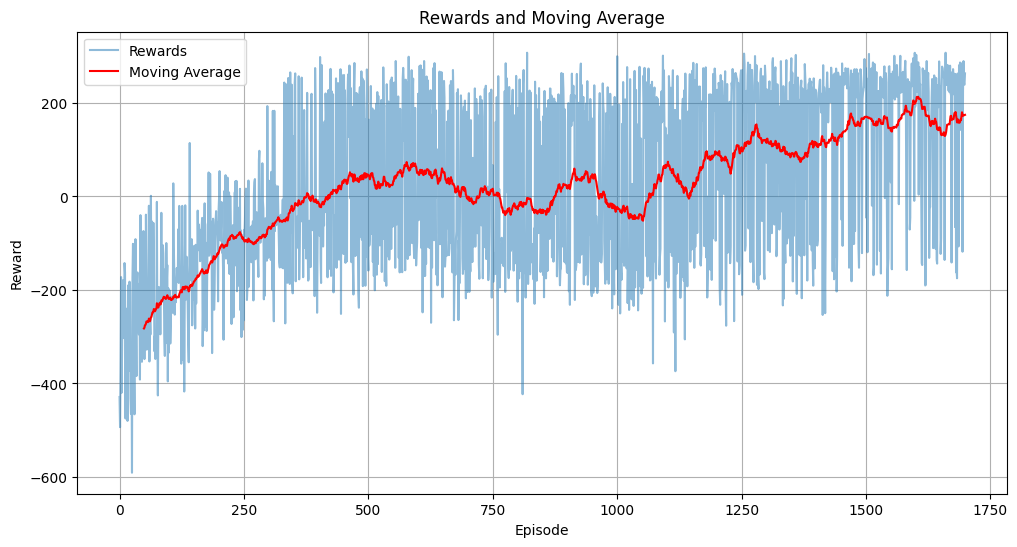

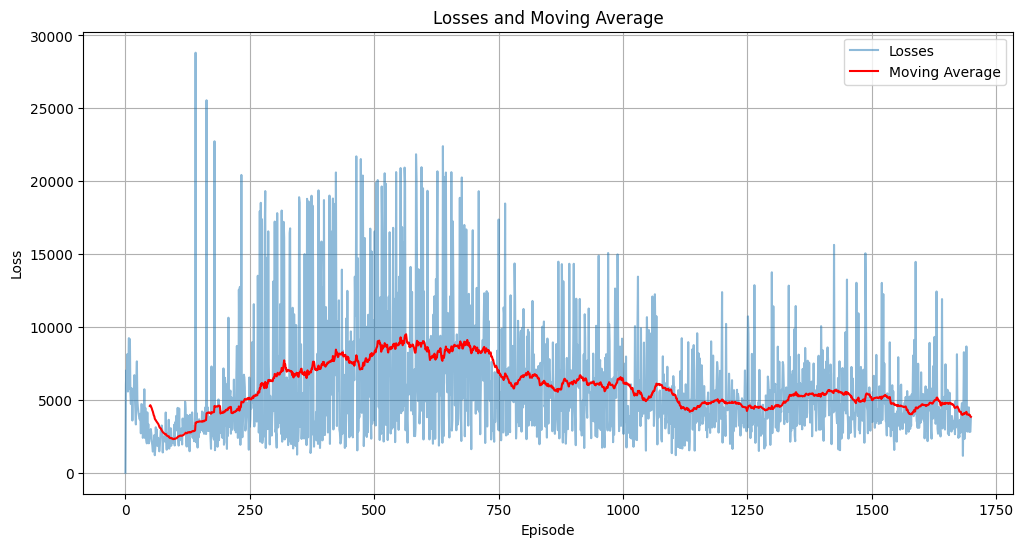

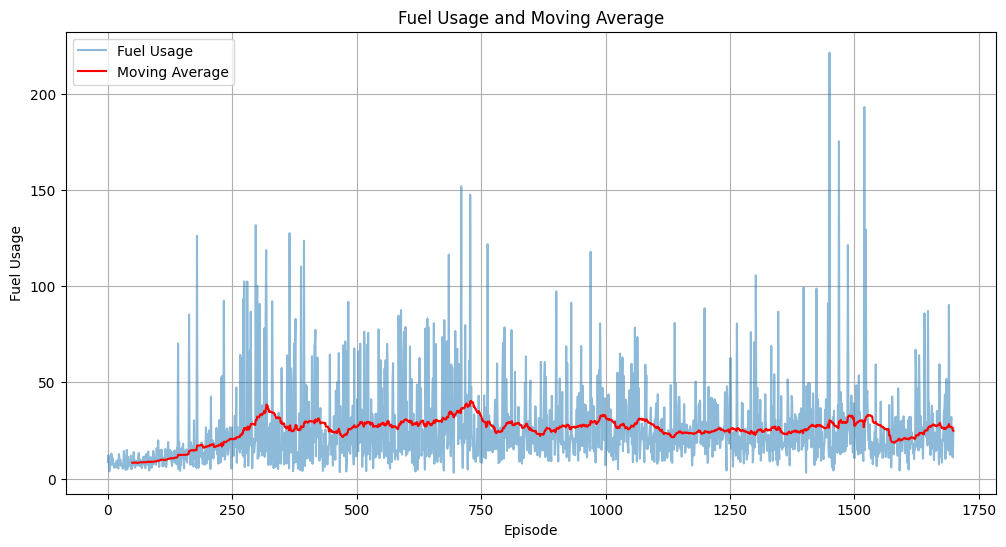

In [ ]:
plot_rewards(rewards)
plot_losses(losses)
plot_fuel_usage(fuel_usage)

In [ ]:
dqn_optim.save_model("dqn_optim_lunarlander-win-env-1.7k-adam.pth")

In [ ]:
dqn_optim.load_model("dqn_optim_lunarlander-win-env-1.7k-adam.pth")

Model loaded successfully.


/tmp/ipykernel_1781/1865257543.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=device)


In [ ]:
dqn_optim.test_model(episodes=500)

Total success:344/500, Average Reward: 170.10, Average Fuel Usage: 21.68


([np.float64(198.31995743940865),
  np.float64(-73.57585468320579),
  np.float64(251.42521728223588),
  np.float64(275.8644019022363),
  np.float64(251.08012771398552),
  np.float64(31.737276074954366),
  np.float64(230.4845332967431),
  np.float64(253.1496099017253),
  np.float64(232.84621960623312),
  np.float64(247.25528170368744),
  np.float64(222.29208766434027),
  np.float64(230.6427142005731),
  np.float64(265.2113083720192),
  np.float64(-12.299289557295154),
  np.float64(255.357328204937),
  np.float64(244.38497176688114),
  np.float64(272.7446029938525),
  np.float64(212.3996205594348),
  np.float64(9.955535503197211),
  np.float64(179.81501816639232),
  np.float64(229.09149067100236),
  np.float64(242.18972772322098),
  np.float64(168.15147405597895),
  np.float64(244.88652093455786),
  np.float64(235.30075181984267),
  np.float64(-112.60332987138885),
  np.float64(224.91624336114796),
  np.float64(252.8916737312259),
  np.float64(199.2614425884098),
  np.float64(212.0618722

In [ ]:
dqn_optim.display_sample_video(sample_video=5)